Epoch 1/20
28/28 [==============================] - 7s 54ms/step - loss: 0.1614 - val_loss: 0.2523
Epoch 2/20
28/28 [==============================] - 0s 7ms/step - loss: 0.0392 - val_loss: 0.2531
Epoch 3/20
28/28 [==============================] - 0s 7ms/step - loss: 0.0308 - val_loss: 0.2541
Epoch 4/20
28/28 [==============================] - 0s 7ms/step - loss: 0.0230 - val_loss: 0.2499
Epoch 5/20
28/28 [==============================] - 0s 8ms/step - loss: 0.0189 - val_loss: 0.2519
Epoch 6/20
28/28 [==============================] - 0s 7ms/step - loss: 0.0186 - val_loss: 0.2454
Epoch 7/20
28/28 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.2456
Epoch 8/20
28/28 [==============================] - 0s 8ms/step - loss: 0.0182 - val_loss: 0.2364
Epoch 9/20
28/28 [==============================] - 0s 8ms/step - loss: 0.0149 - val_loss: 0.2308
Epoch 10/20
28/28 [==============================] - 0s 8ms/step - loss: 0.0133 - val_loss: 0.2101
Epoch 11/20
28/28 

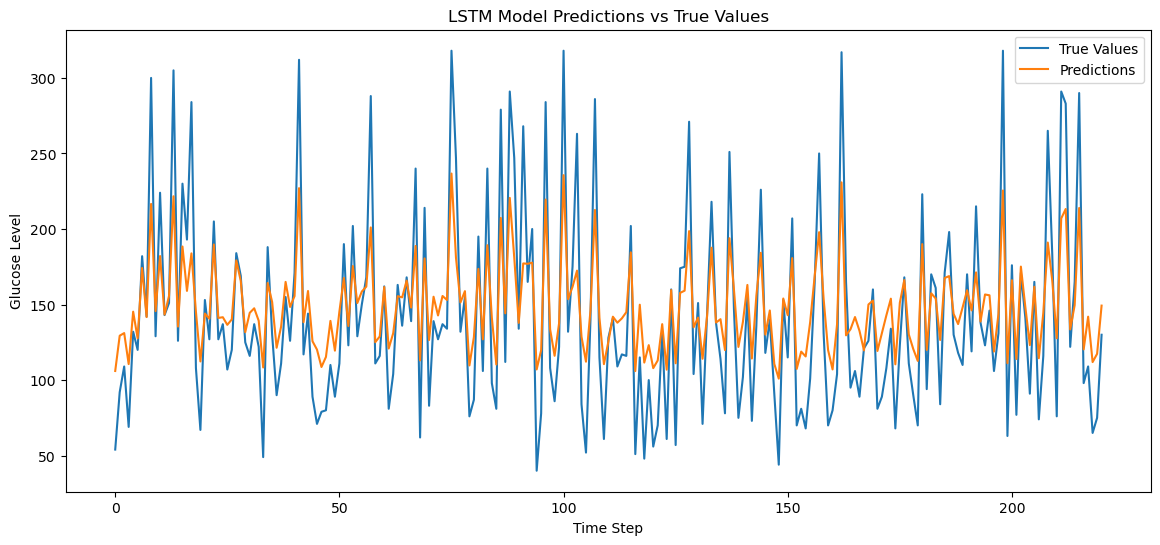

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from helperFunctions import createDataSet

# Load and preprocess the data using helperFunctions.py
file ="../../data/Ohio2020_processed/train/540-ws-training_processed.csv"
data_list = createDataSet(file)

# Combine data into a single DataFrame
data = pd.concat(data_list, ignore_index=True)

# Split the data into features (X) and target (y)
X = data.drop(['cbg'], axis=1)
y = data['cbg']

# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Reshape X for LSTM input (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

def create_model(input_shape):
    model = Sequential([
        LSTM(64, activation='tanh', input_shape=input_shape, return_sequences=True),
        BatchNormalization(),
        LSTM(32, activation='tanh'),
        BatchNormalization(),
        Dense(16, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss='mse')
    return model

def train_model(X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
    model = create_model((X_train.shape[1], X_train.shape[2]))
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])
    return model, history

# Train the model
model, history = train_model(X_train, y_train, X_val, y_val)

# Evaluate the model on the validation set
val_loss = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")

# Make predictions on the validation set
y_pred_scaled = model.predict(X_val)

# Inverse scale the predictions and true values
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_val)

# Plot the predictions vs the true values
plt.figure(figsize=(14, 6))
plt.plot(y_true, label="True Values")
plt.plot(y_pred, label="Predictions")
plt.xlabel("Time Step")
plt.ylabel("Glucose Level")
plt.title("LSTM Model Predictions vs True Values")
plt.legend()
plt.show()


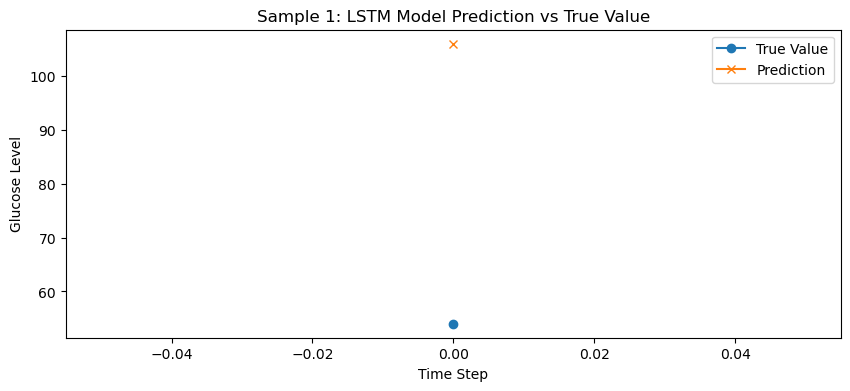

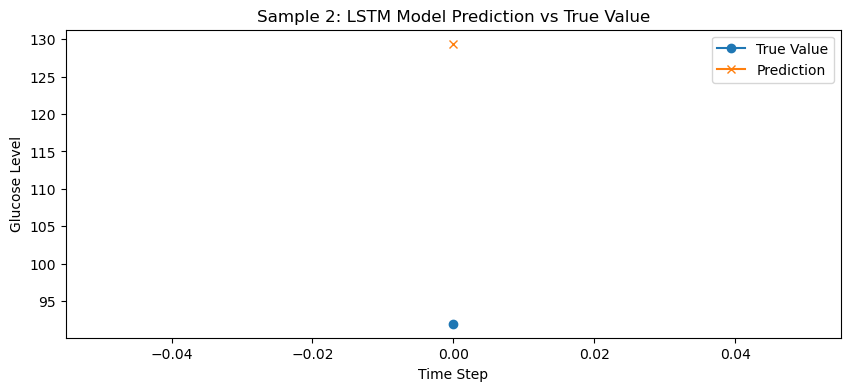

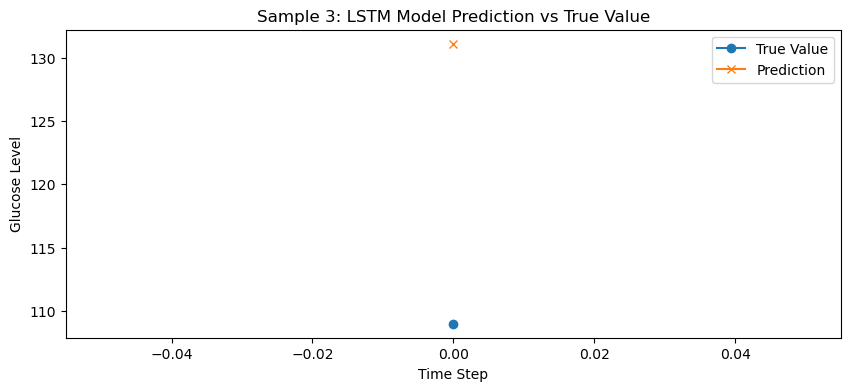

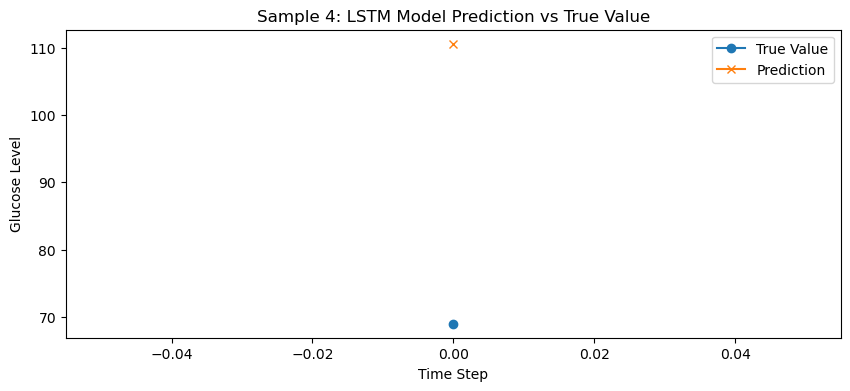

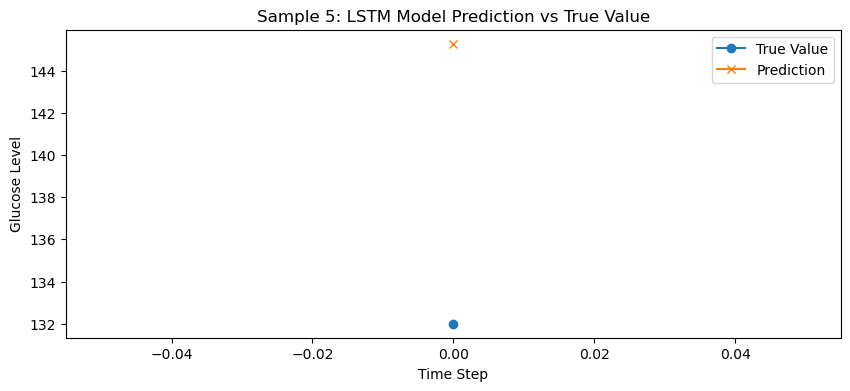

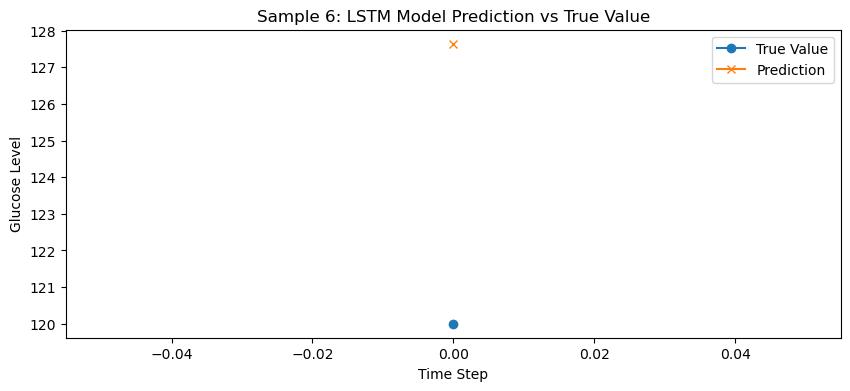

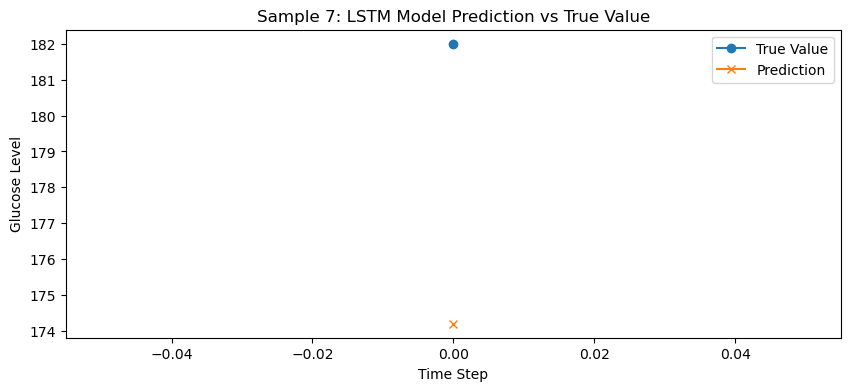

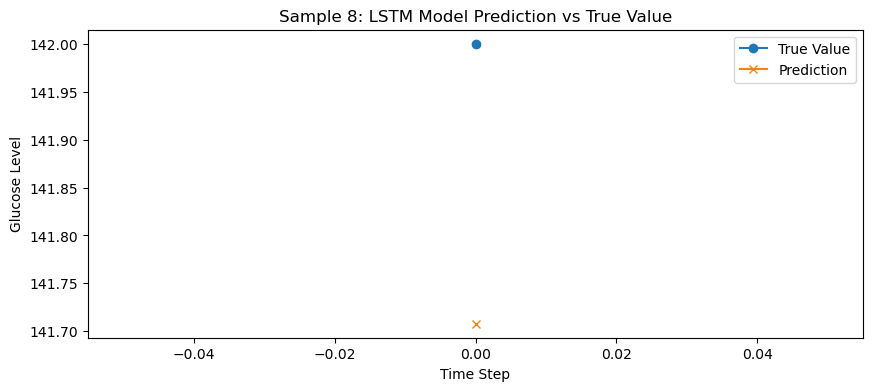

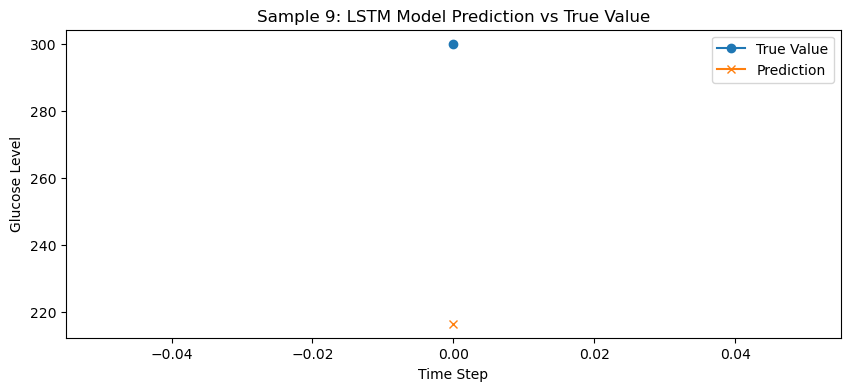

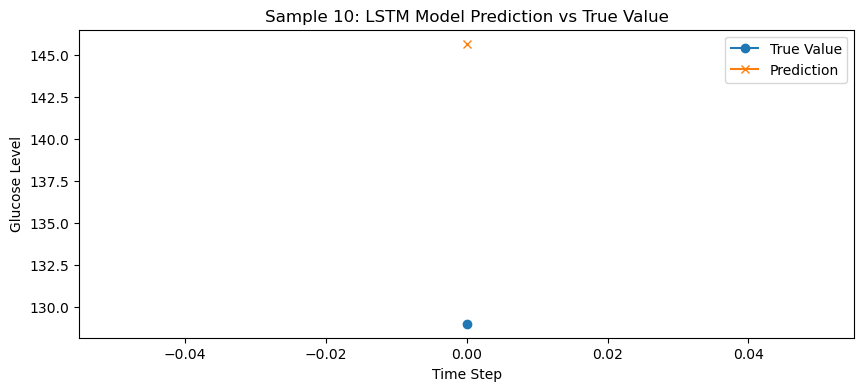

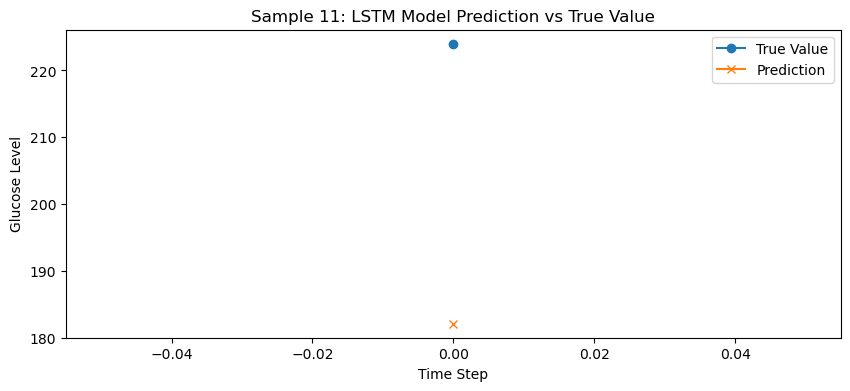

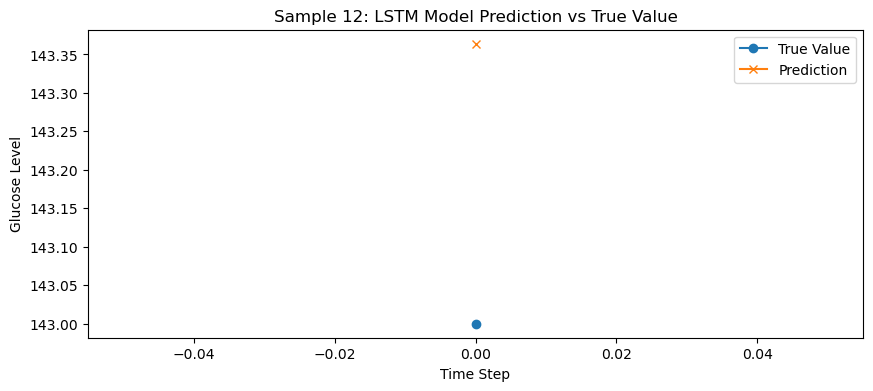

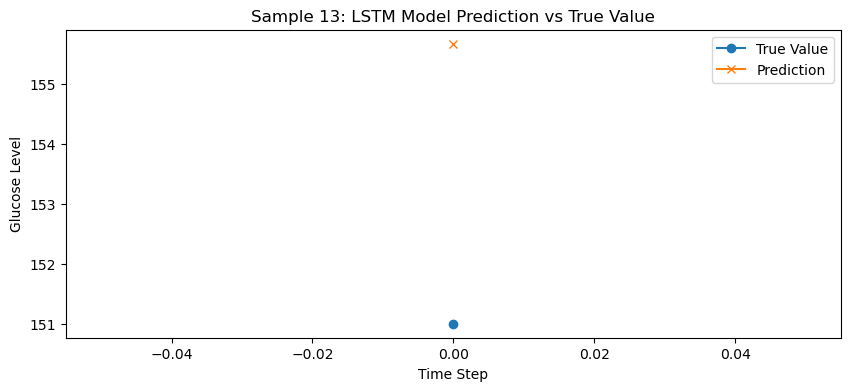

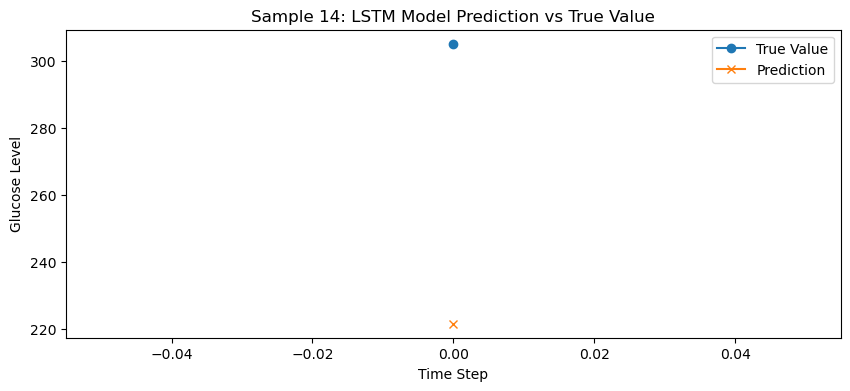

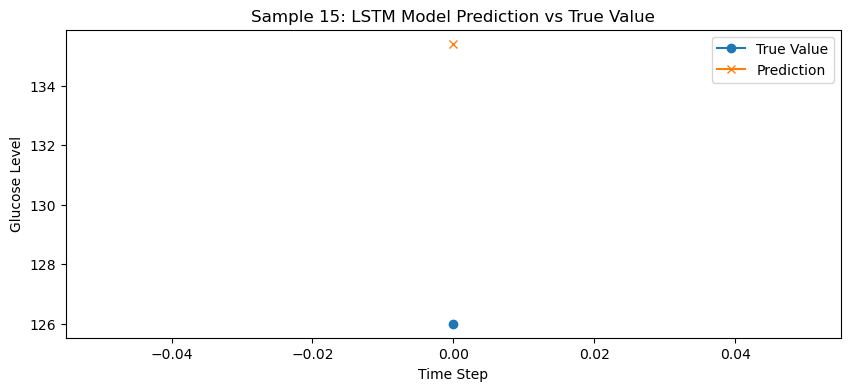

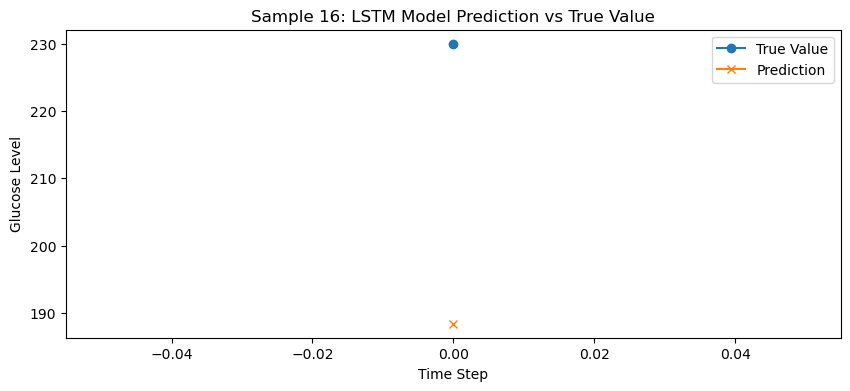

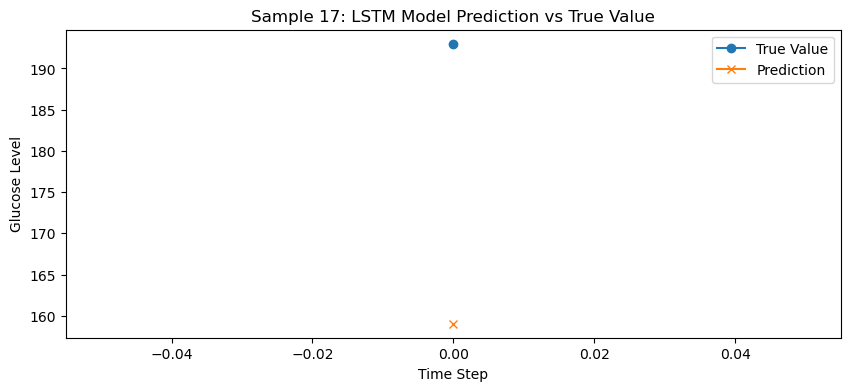

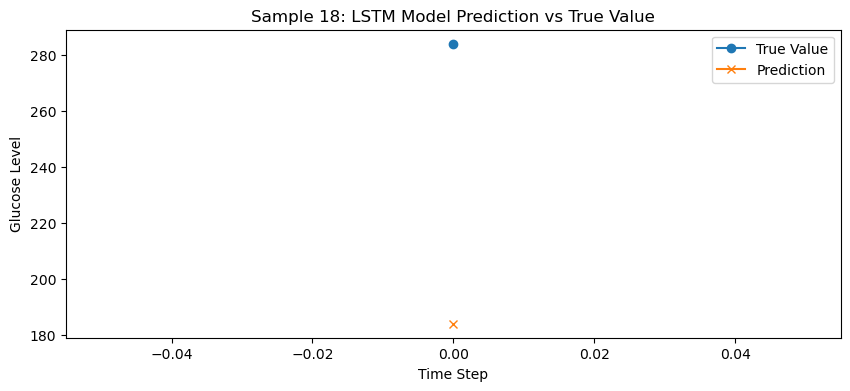

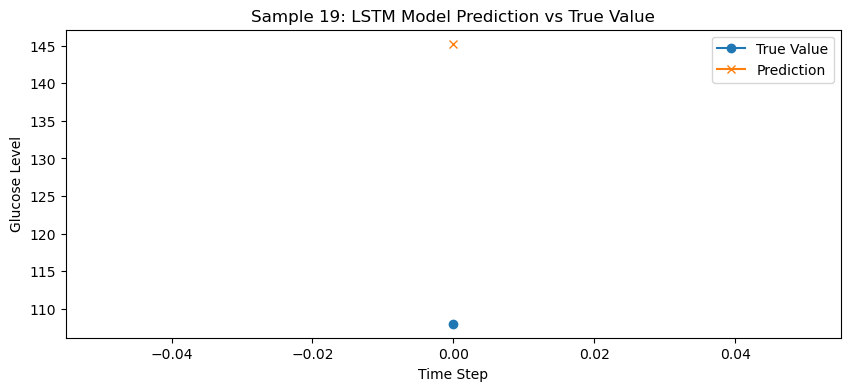

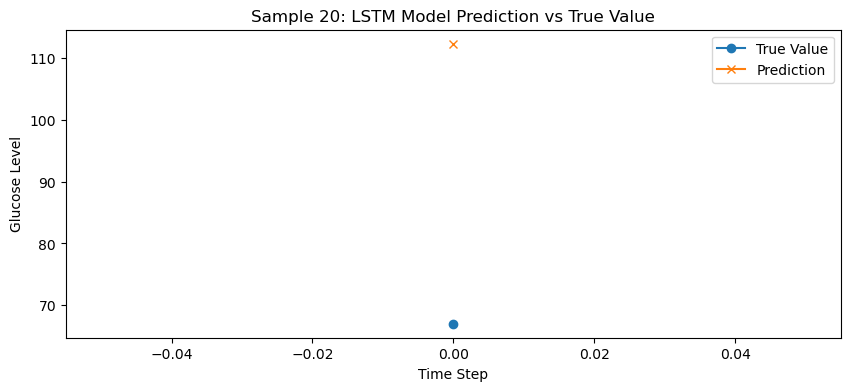

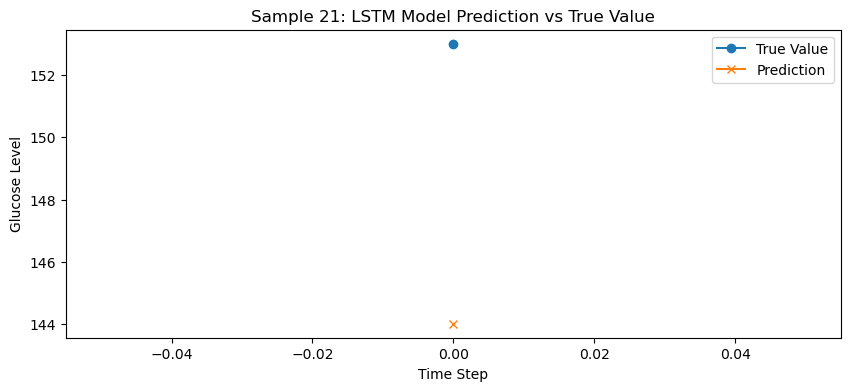

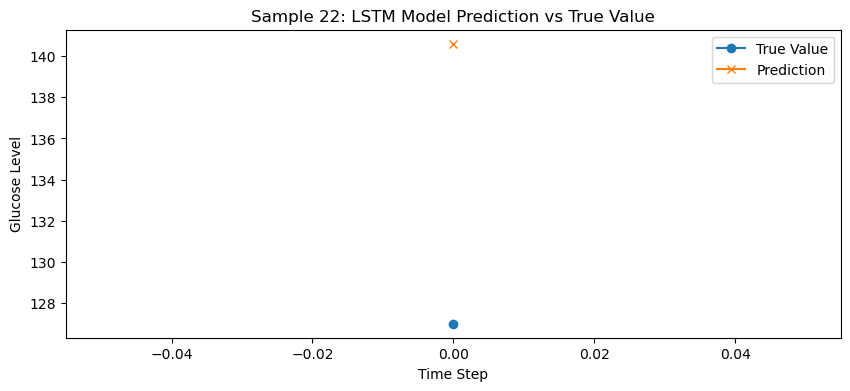

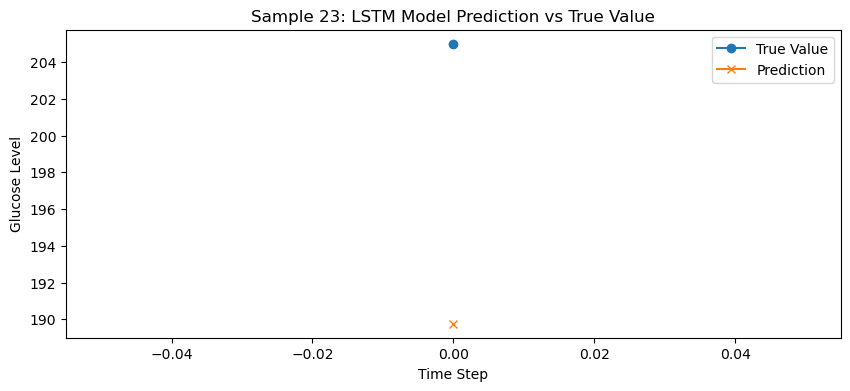

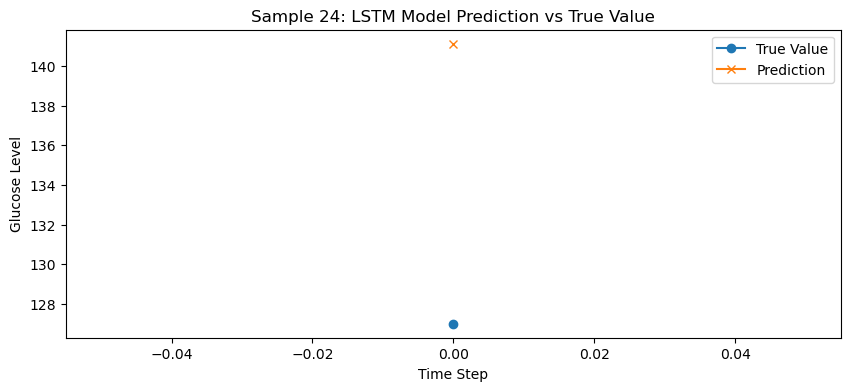

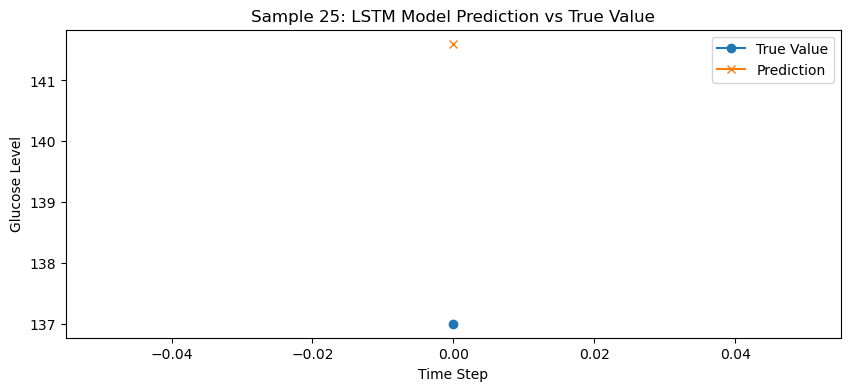

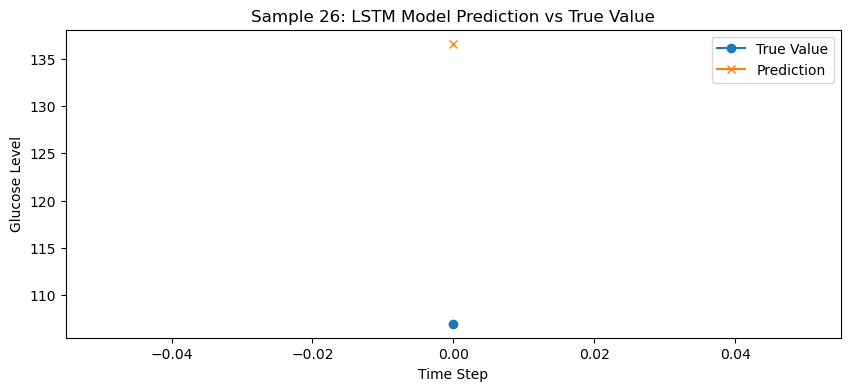

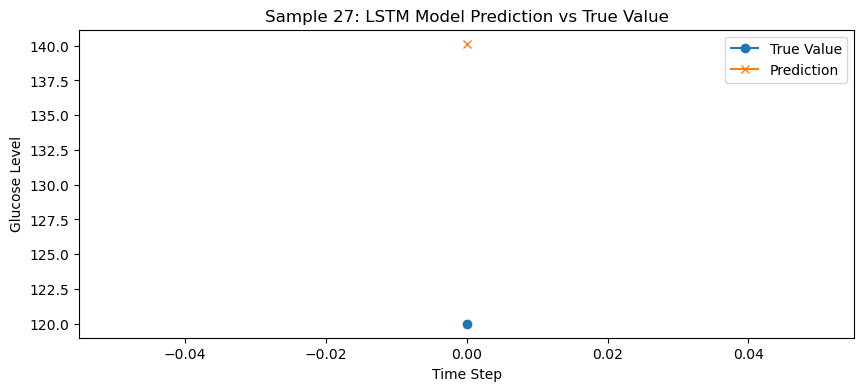

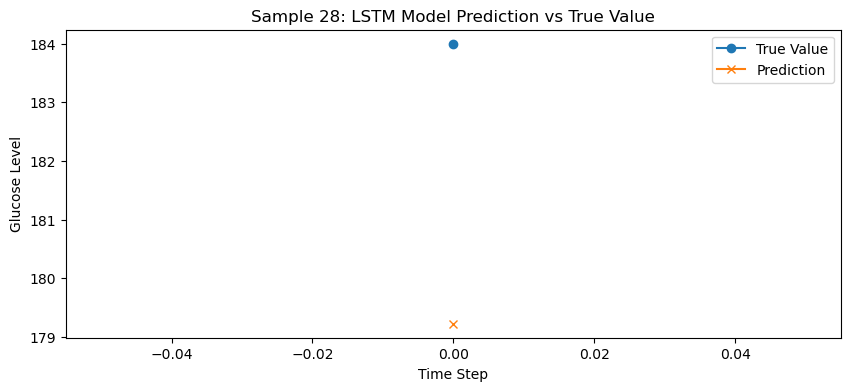

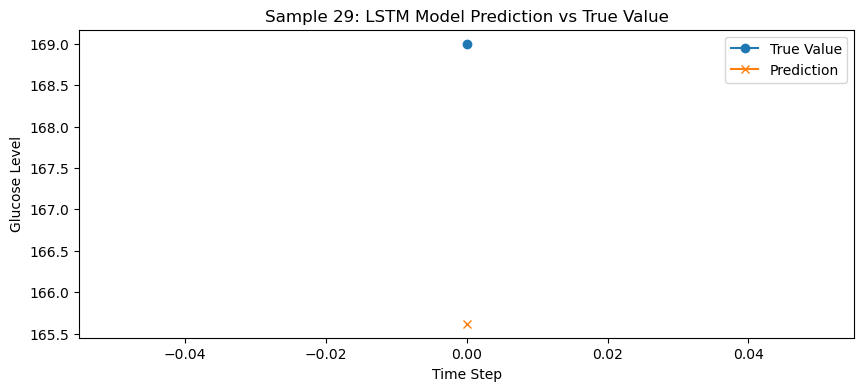

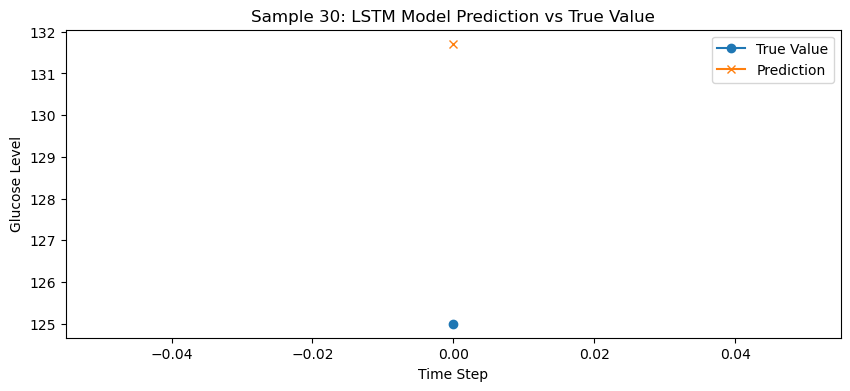

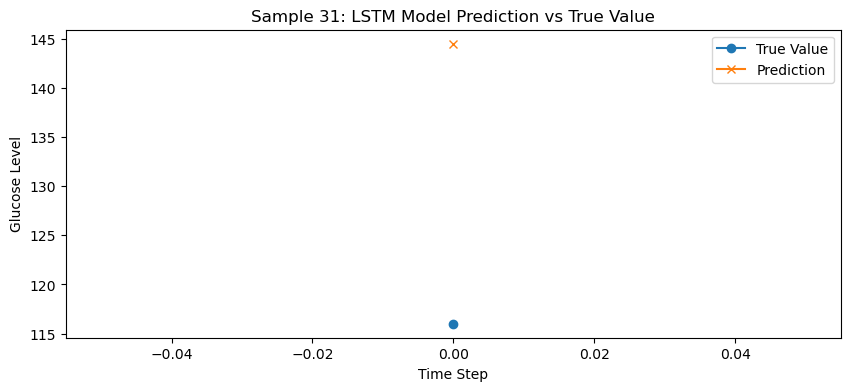

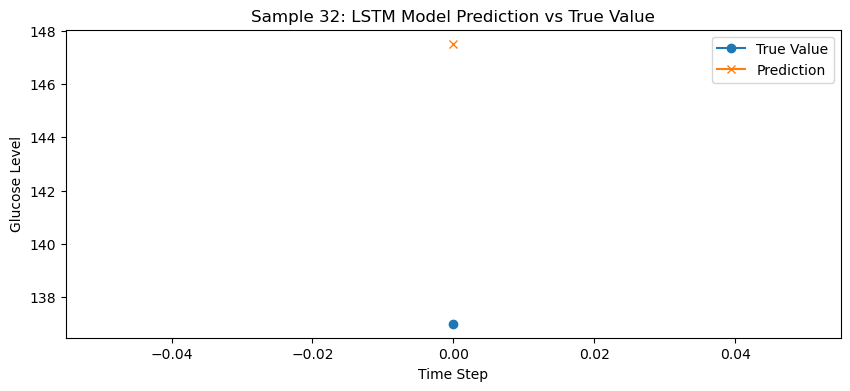

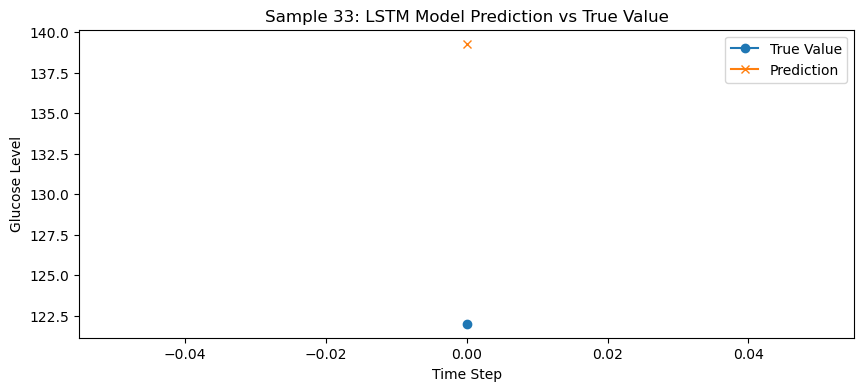

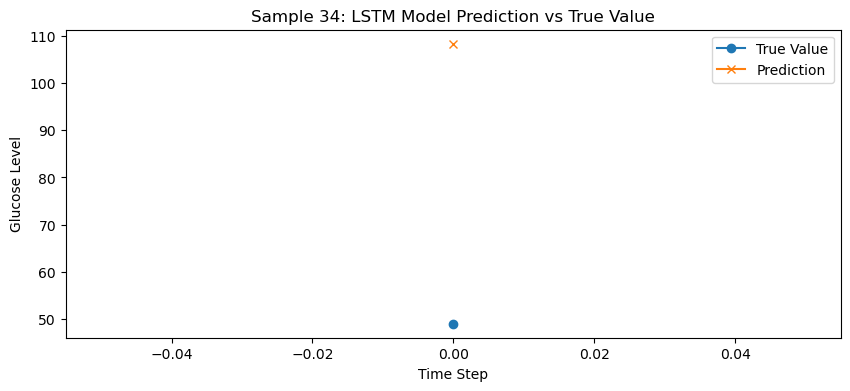

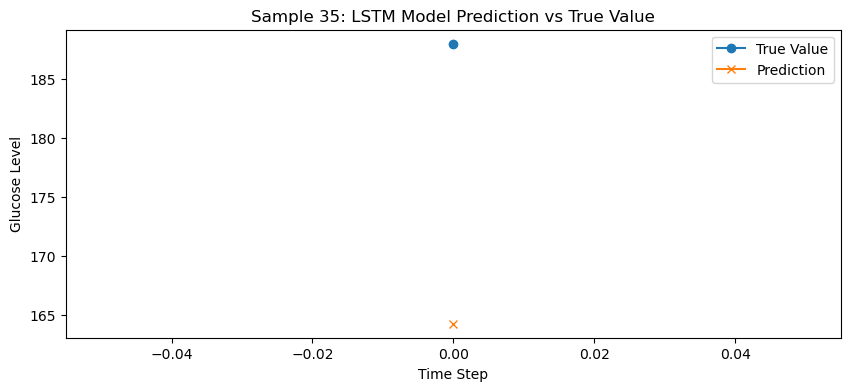

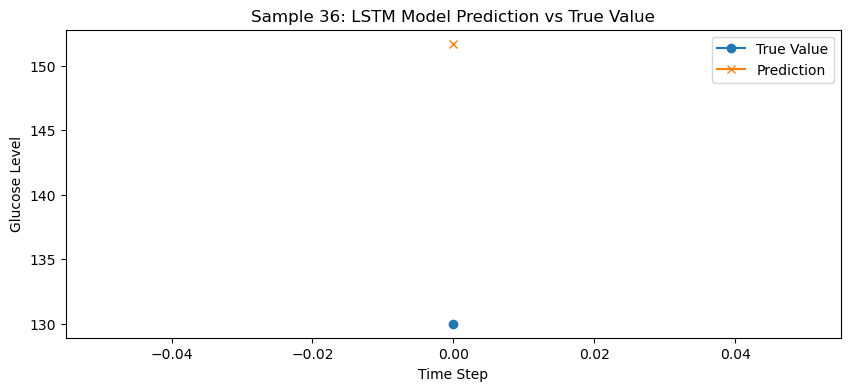

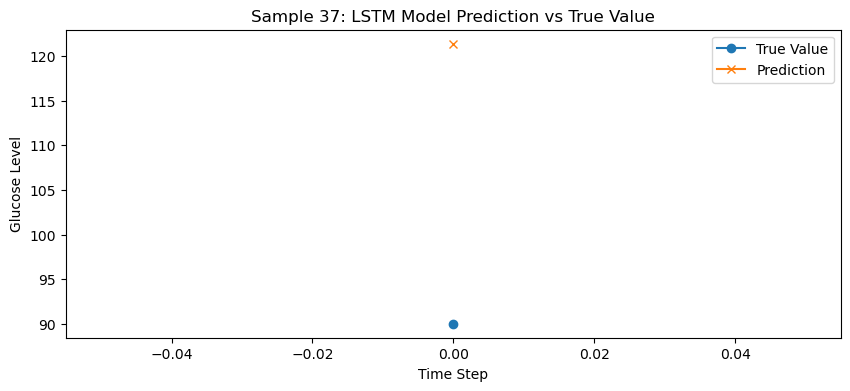

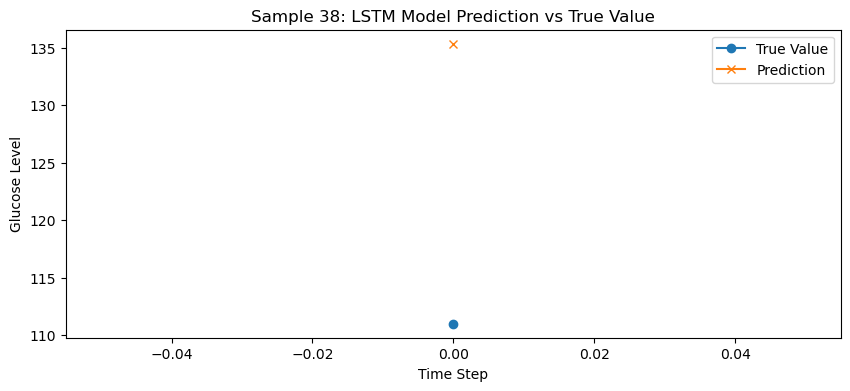

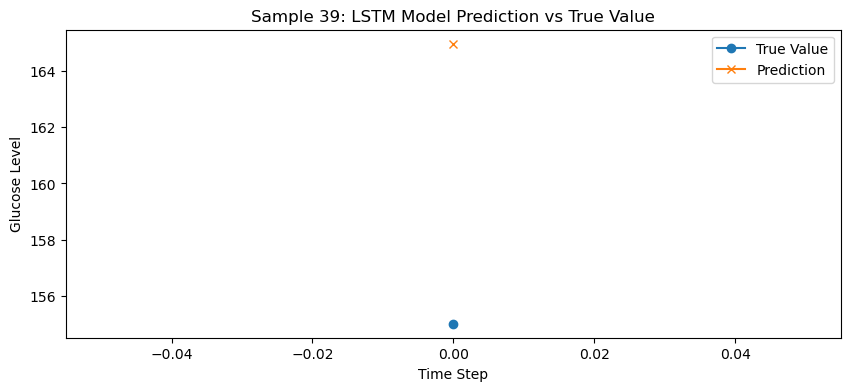

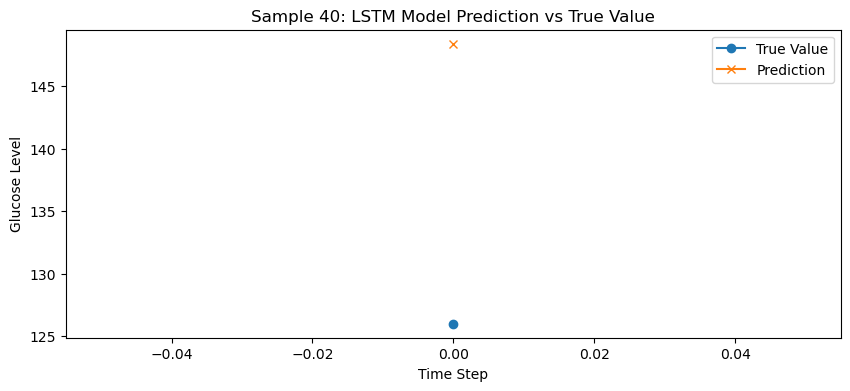

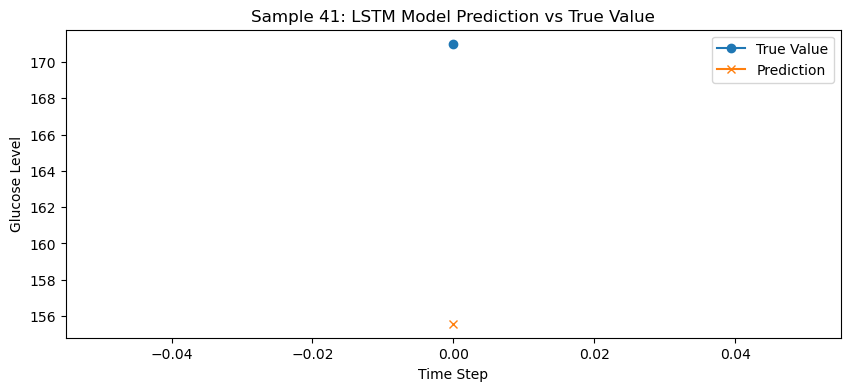

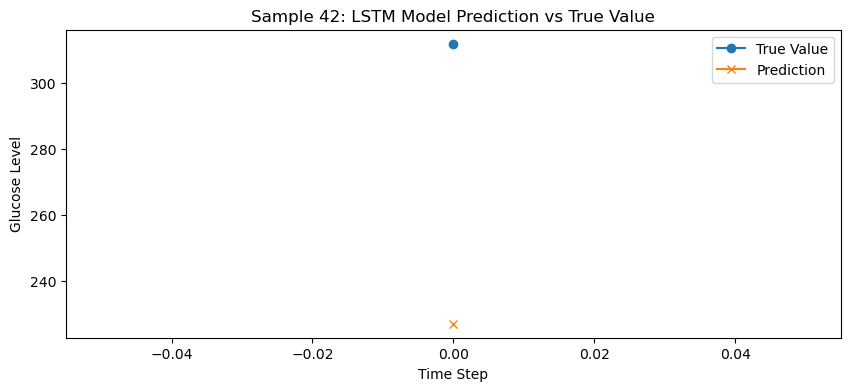

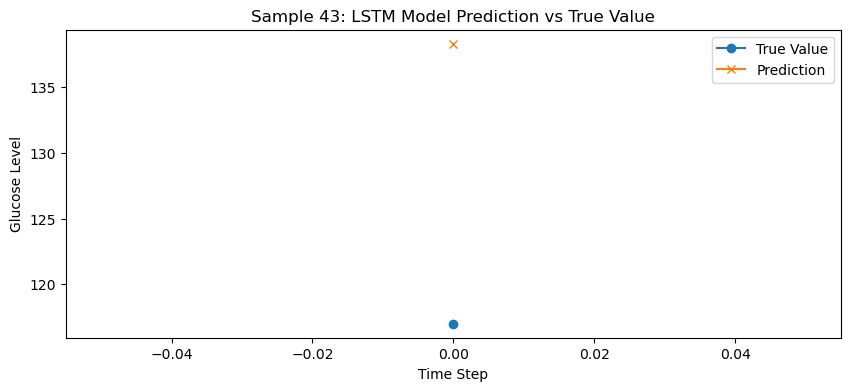

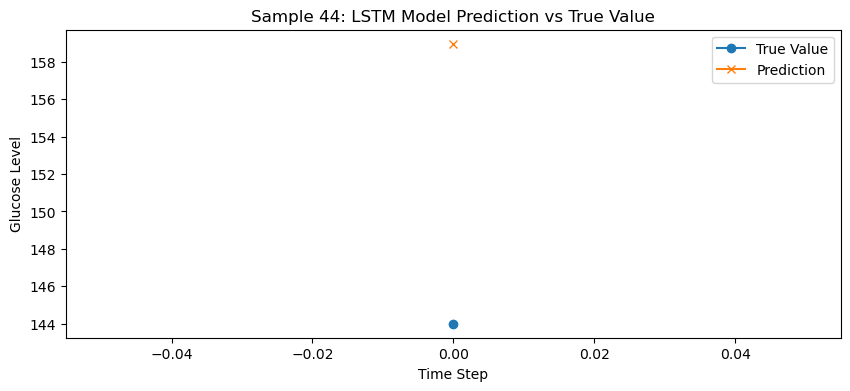

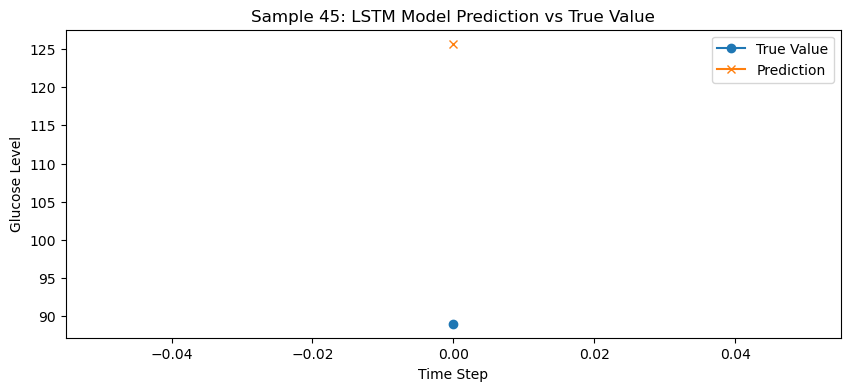

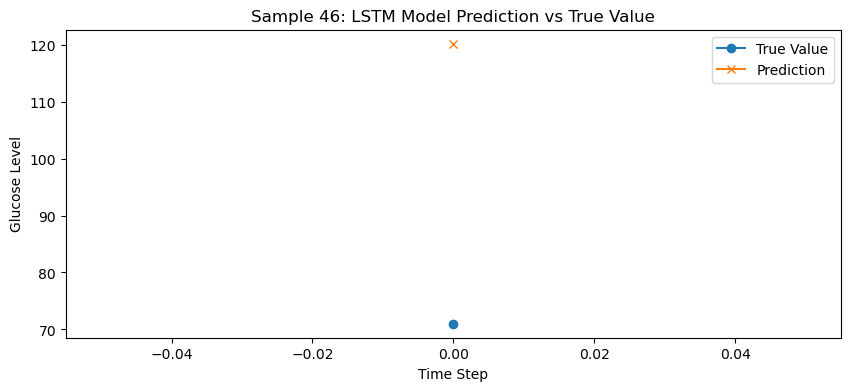

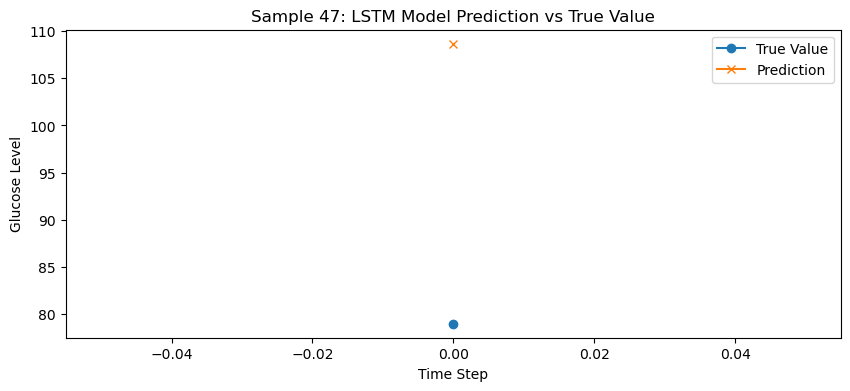

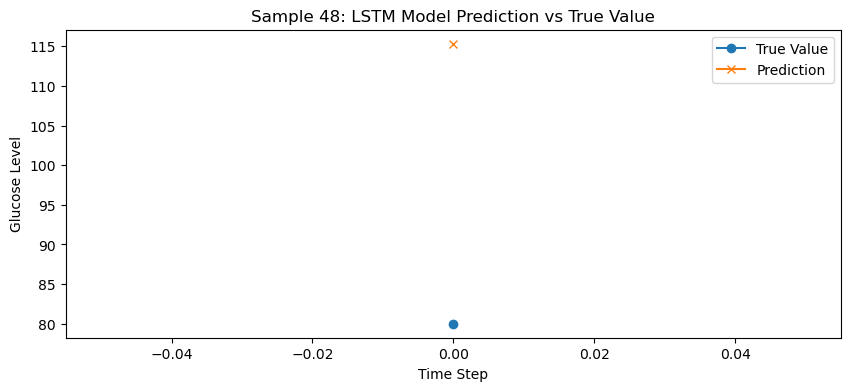

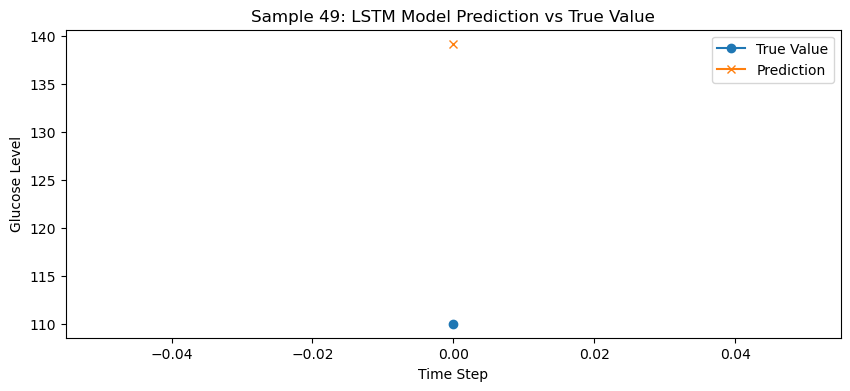

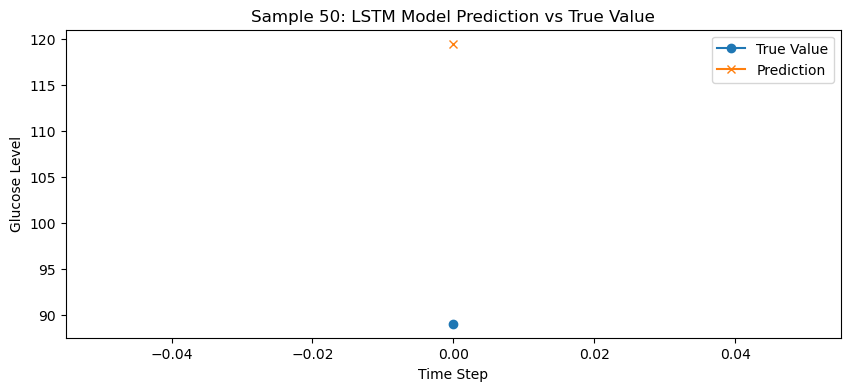

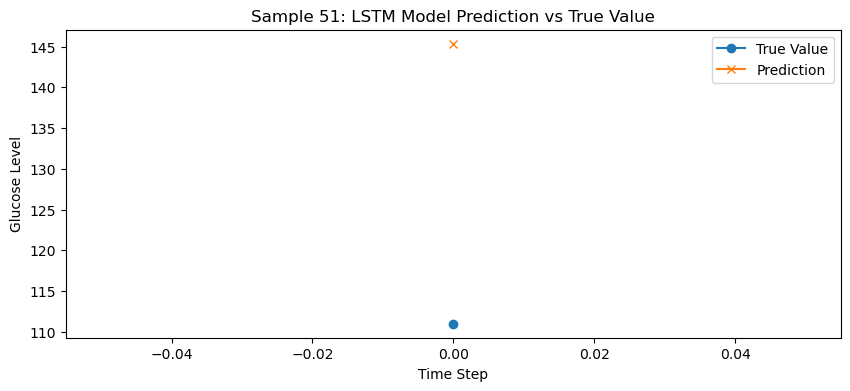

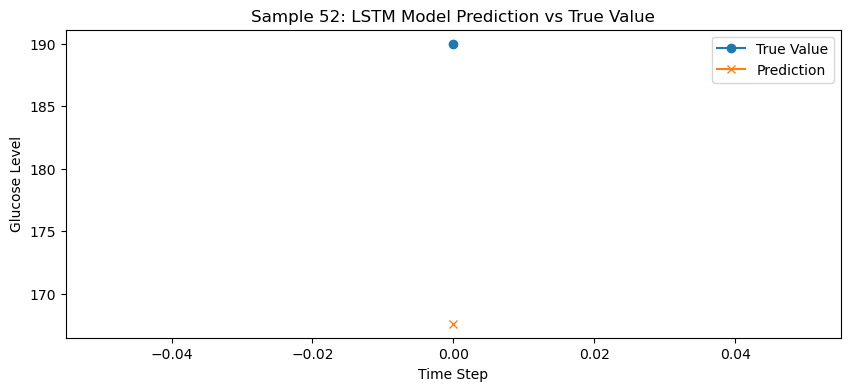

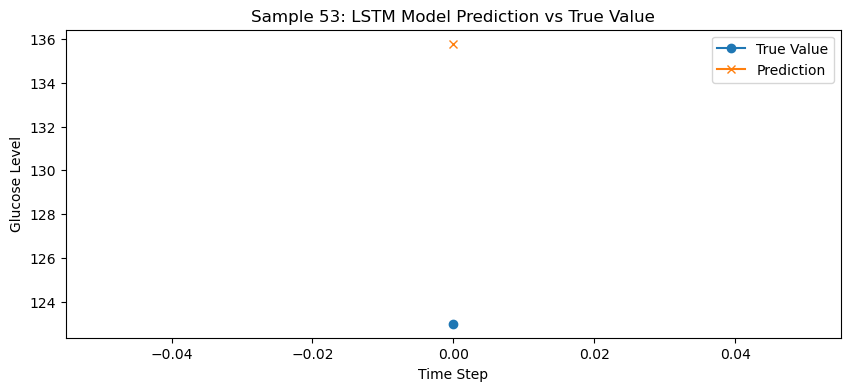

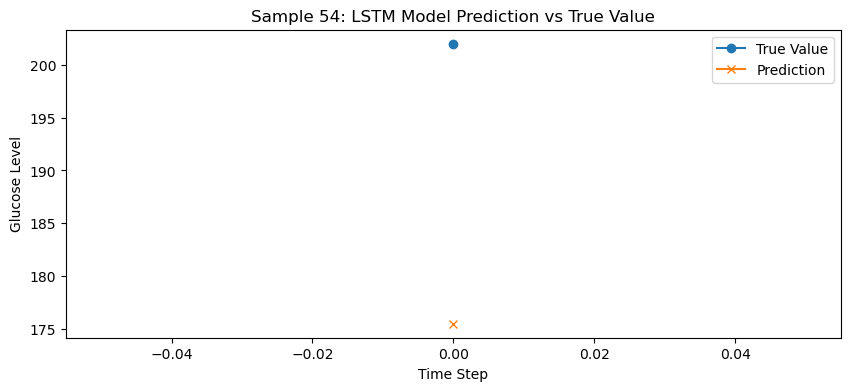

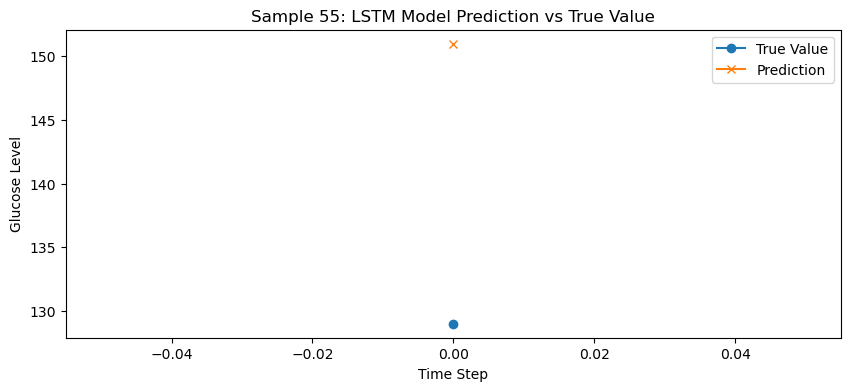

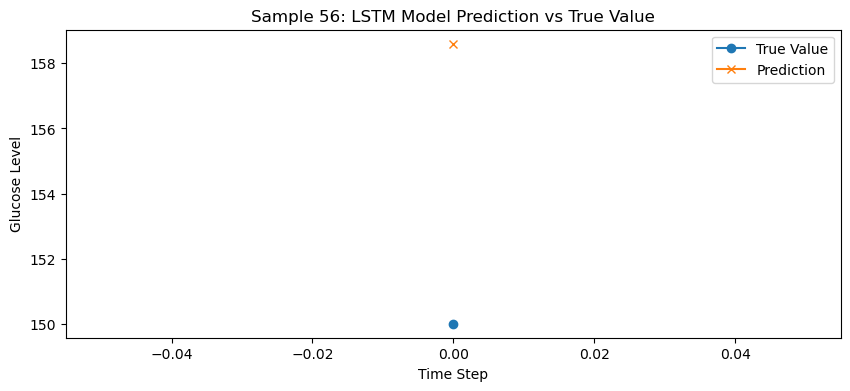

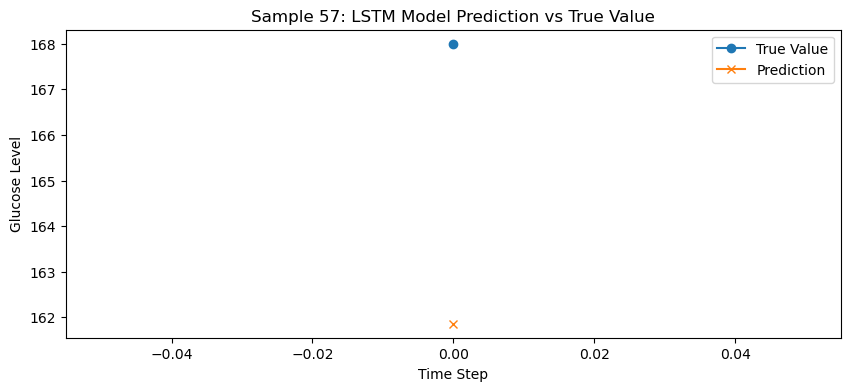

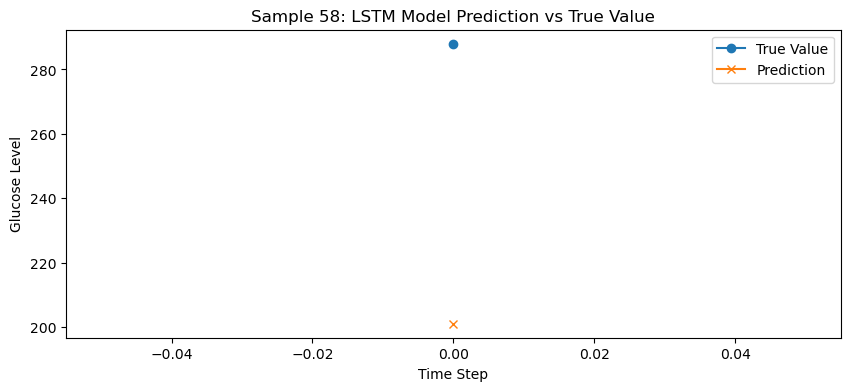

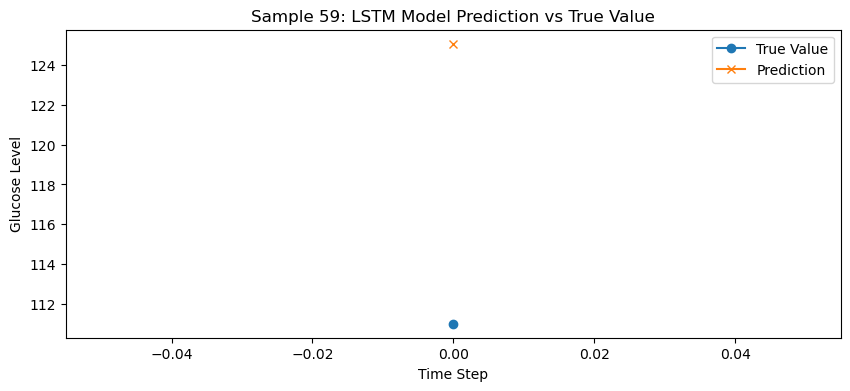

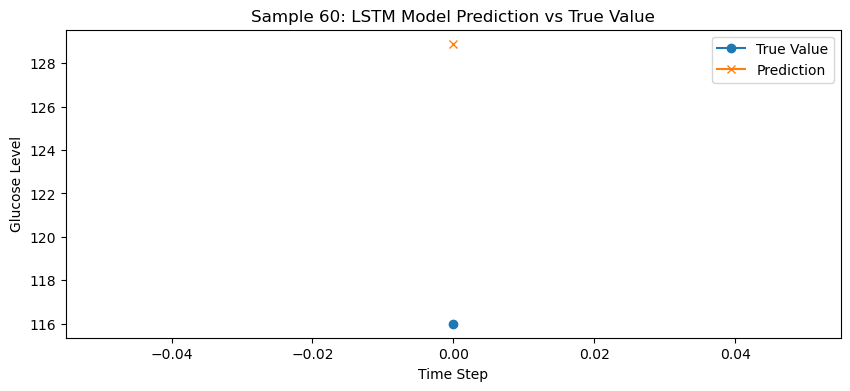

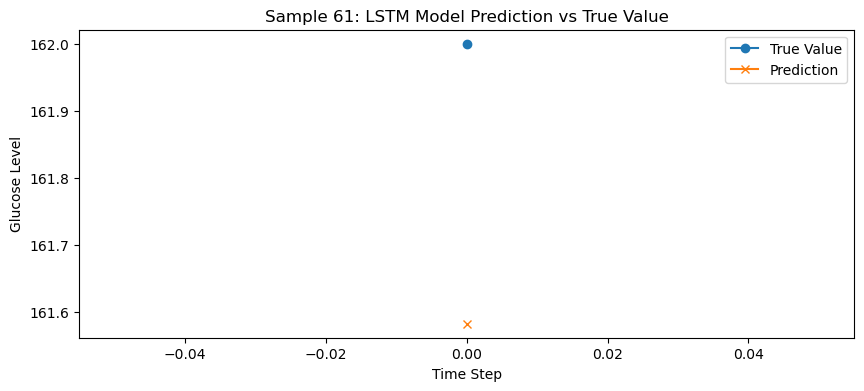

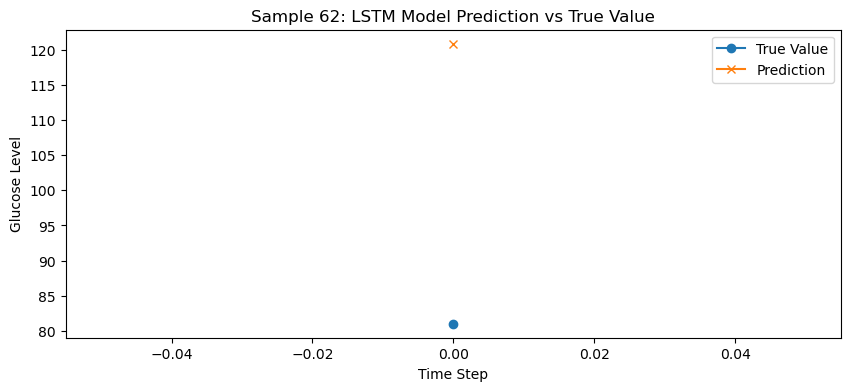

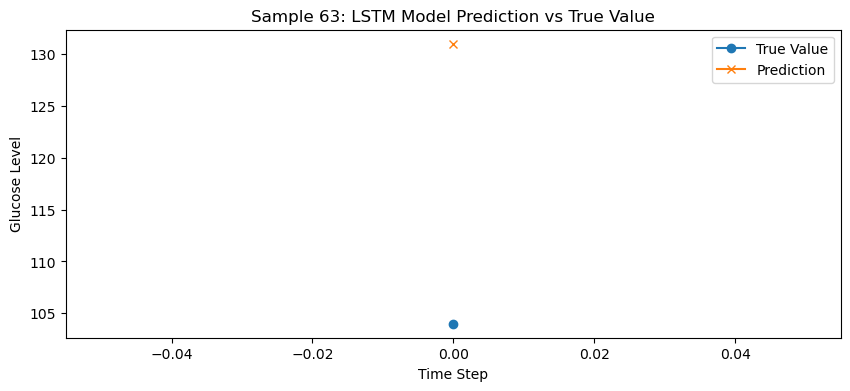

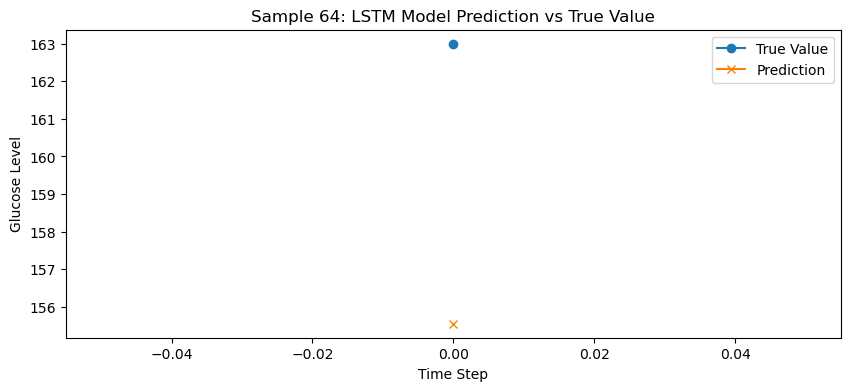

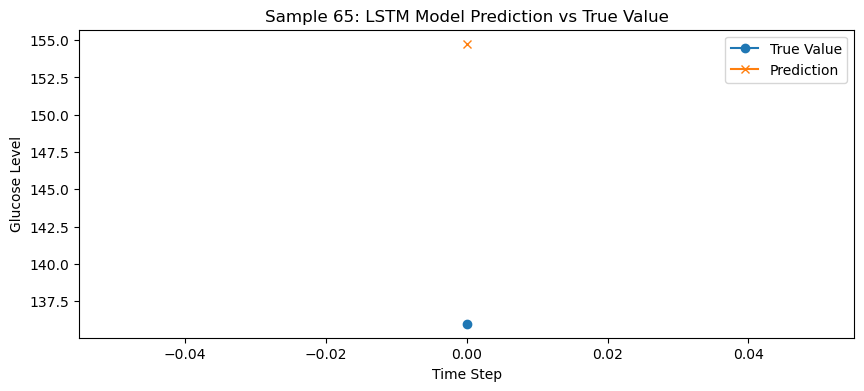

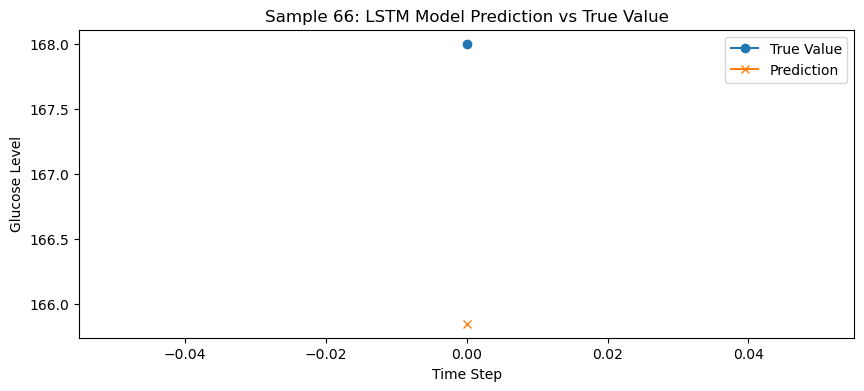

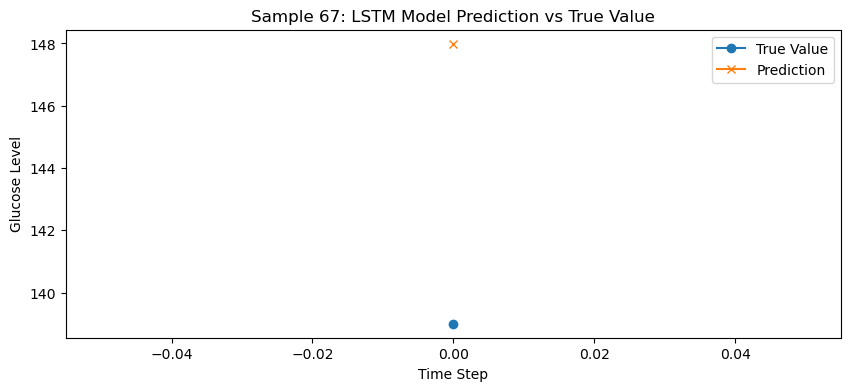

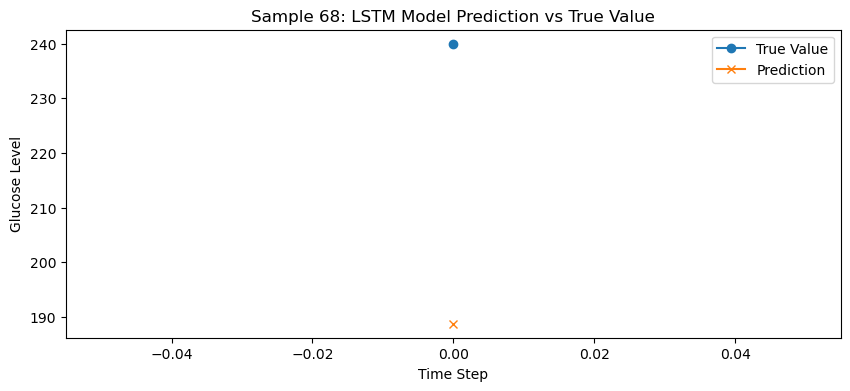

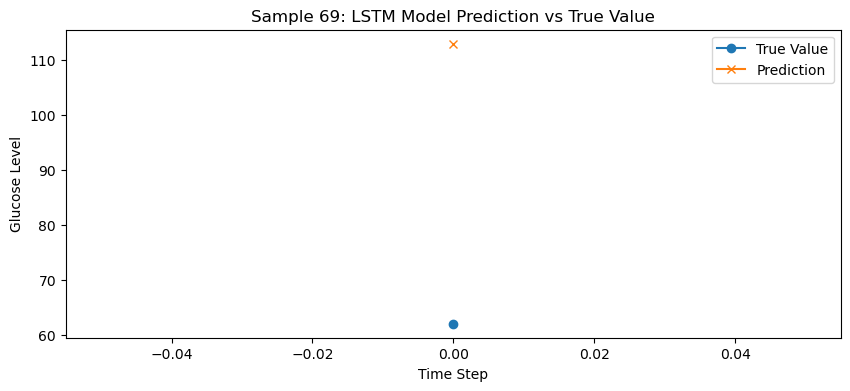

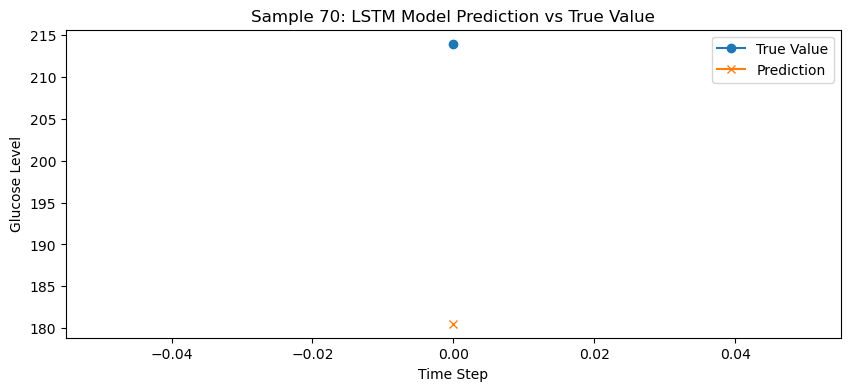

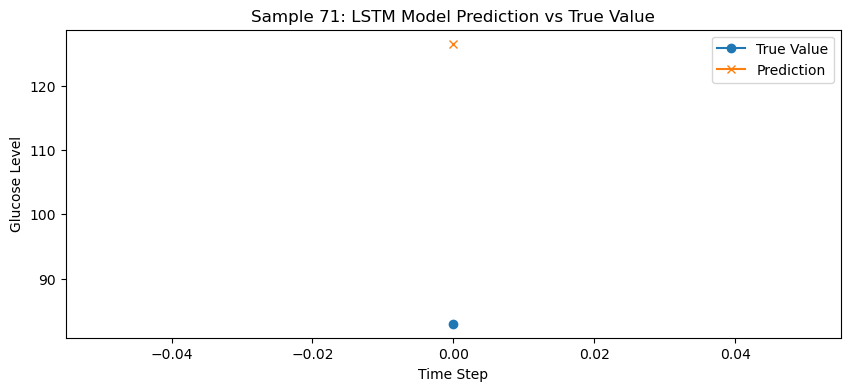

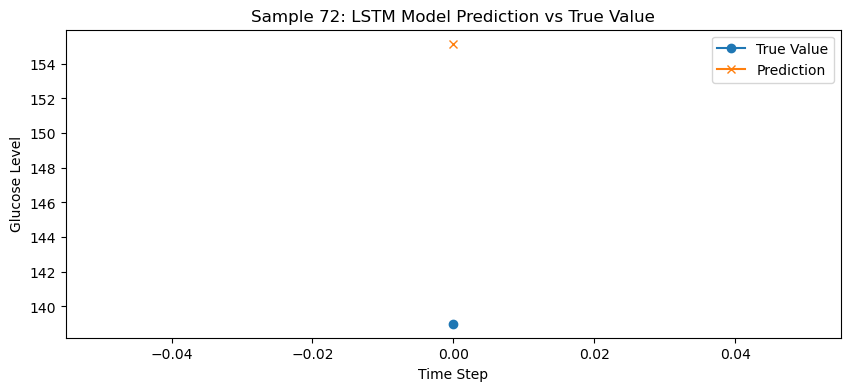

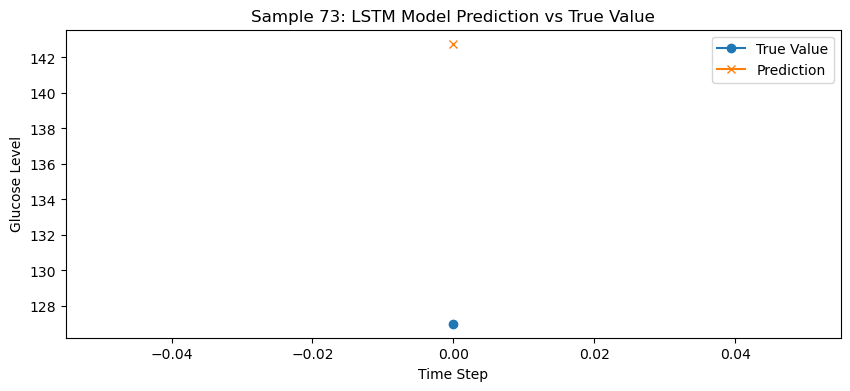

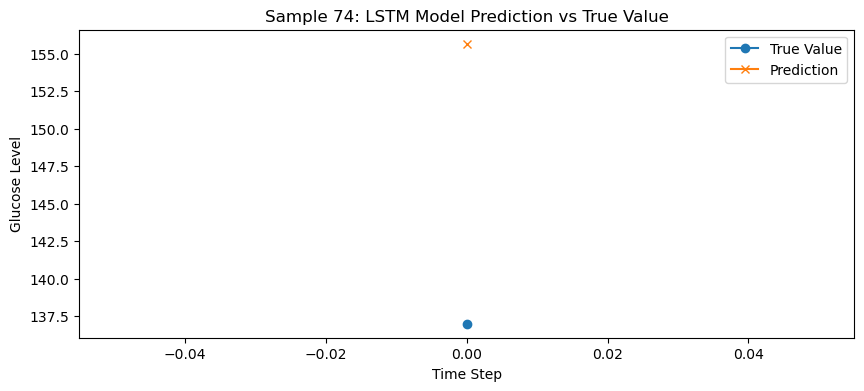

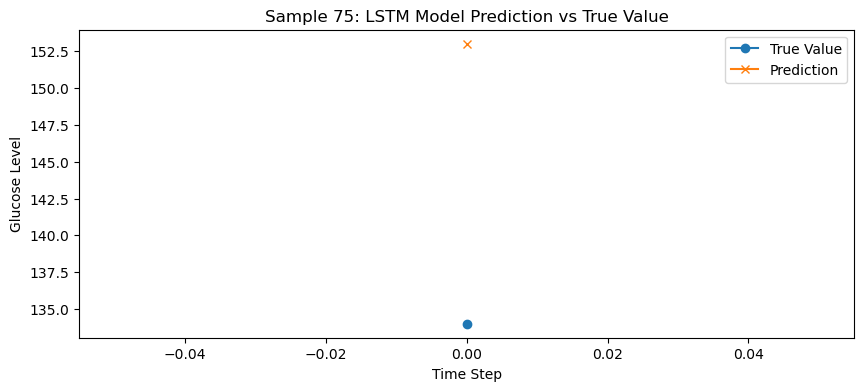

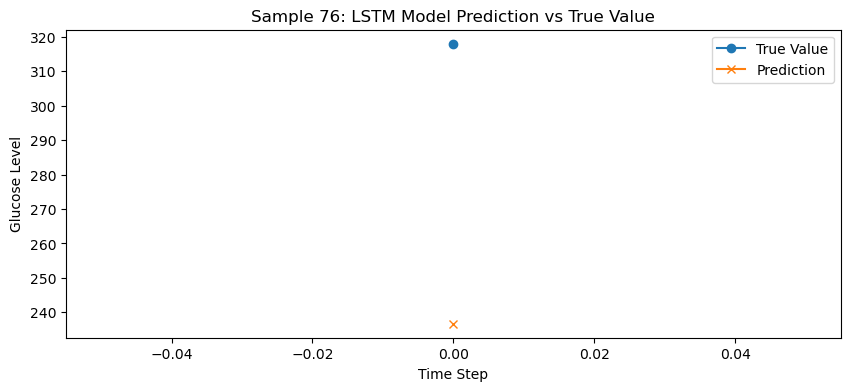

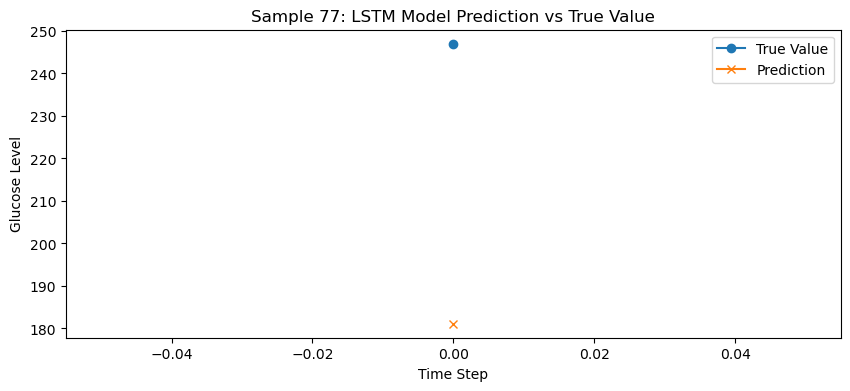

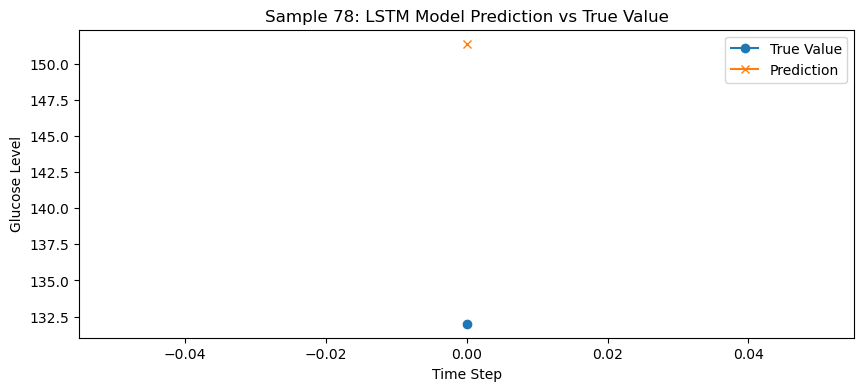

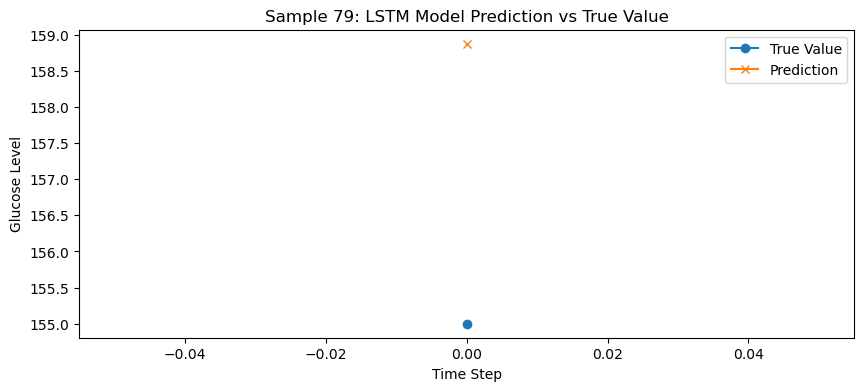

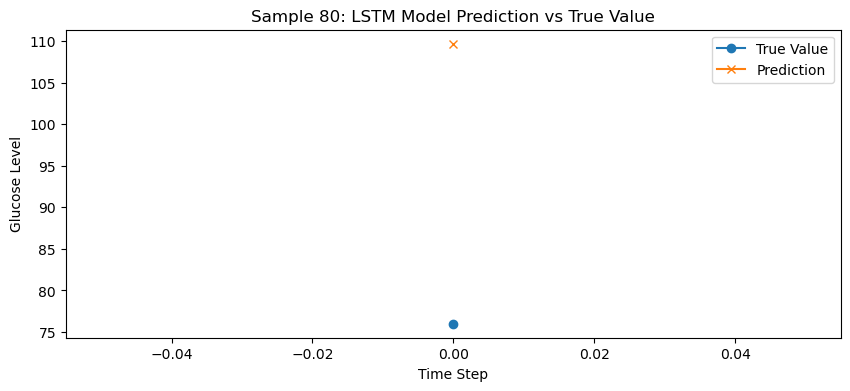

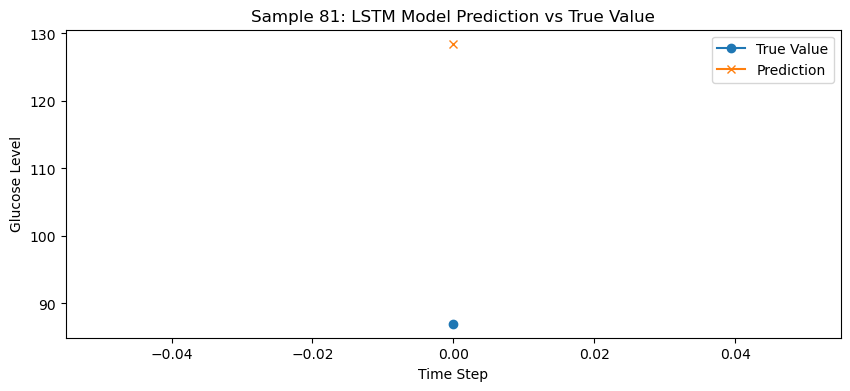

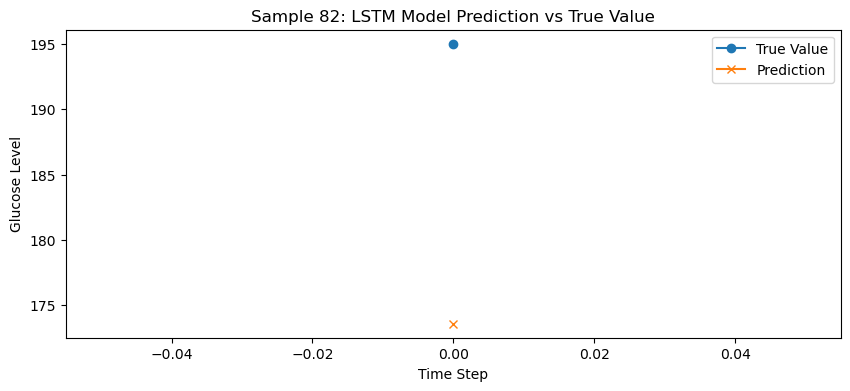

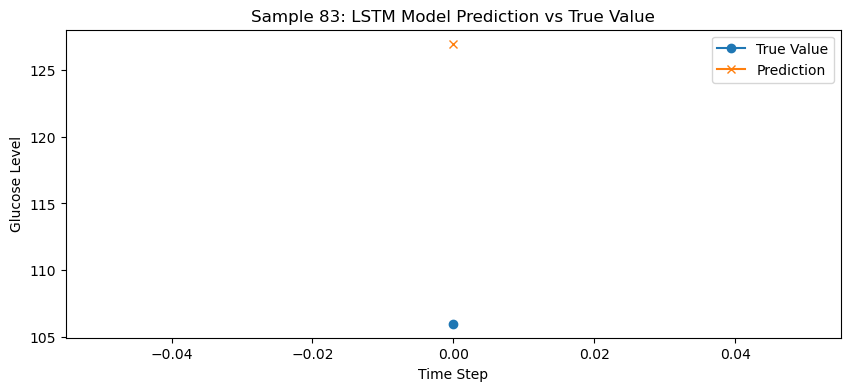

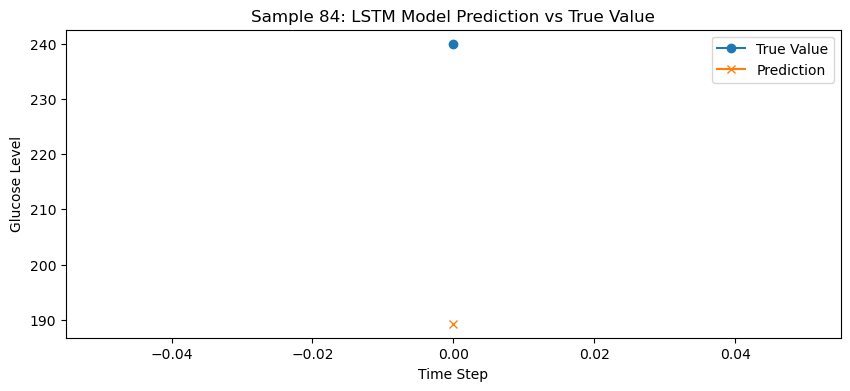

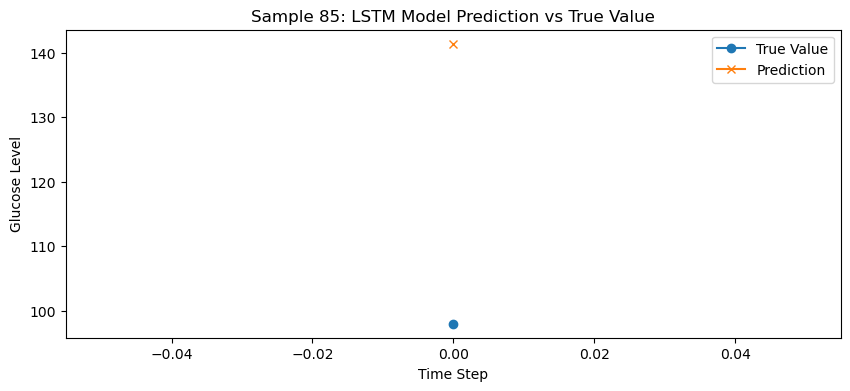

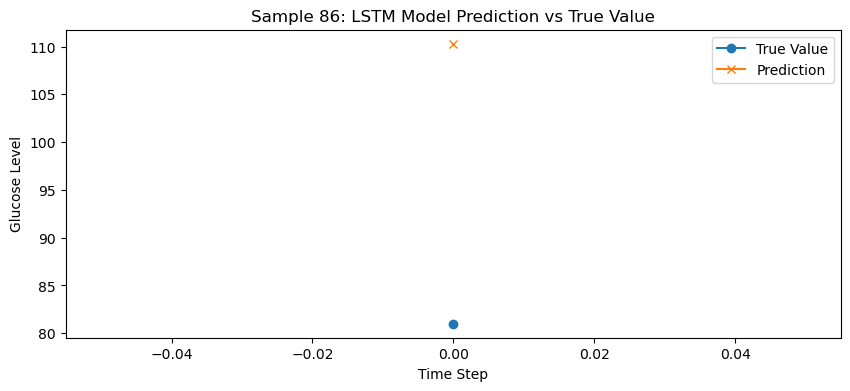

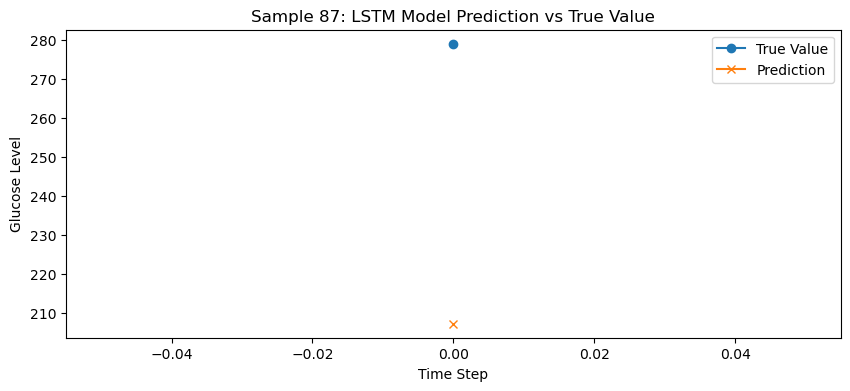

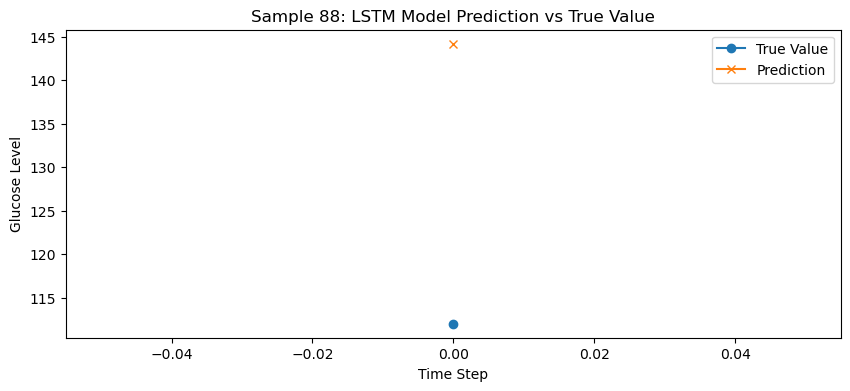

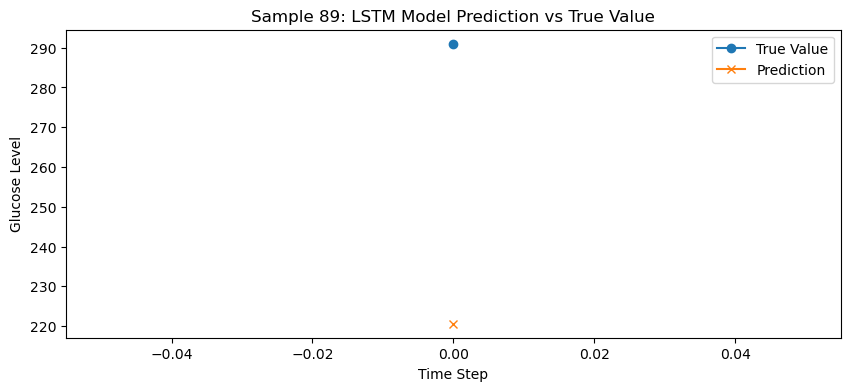

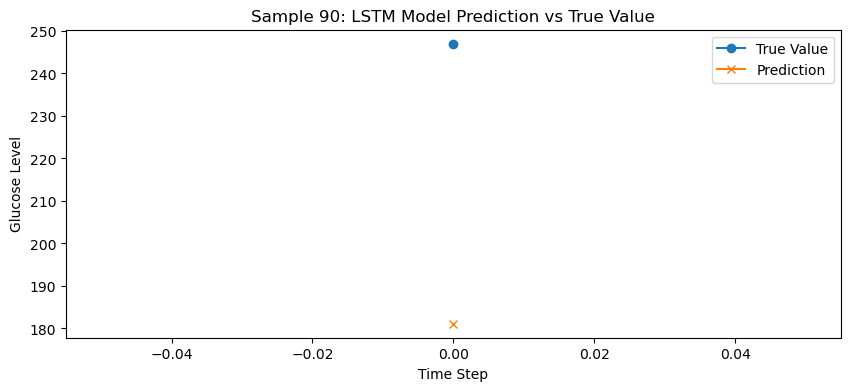

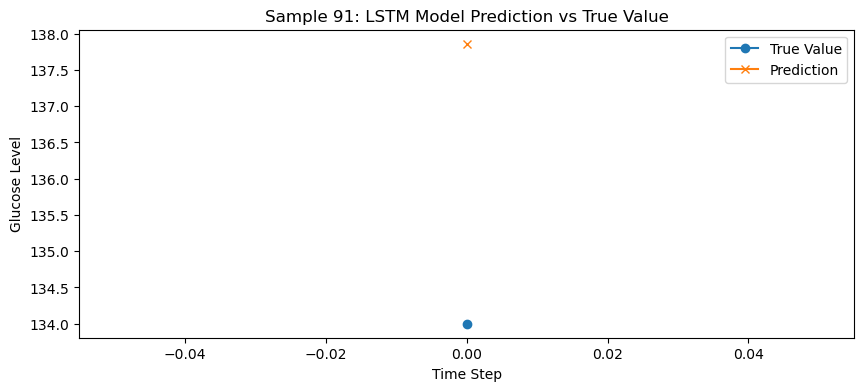

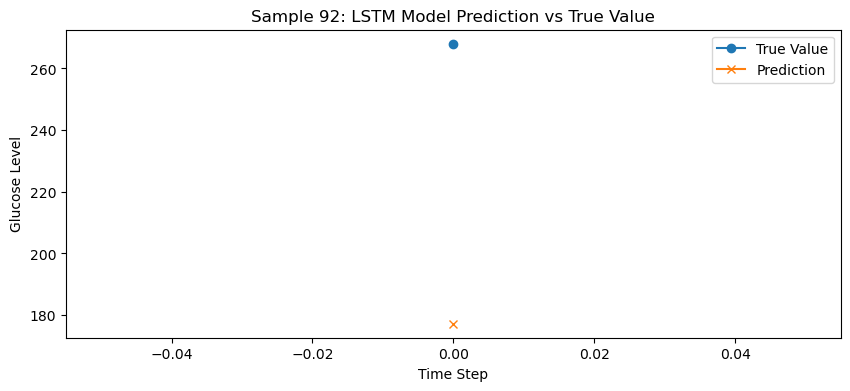

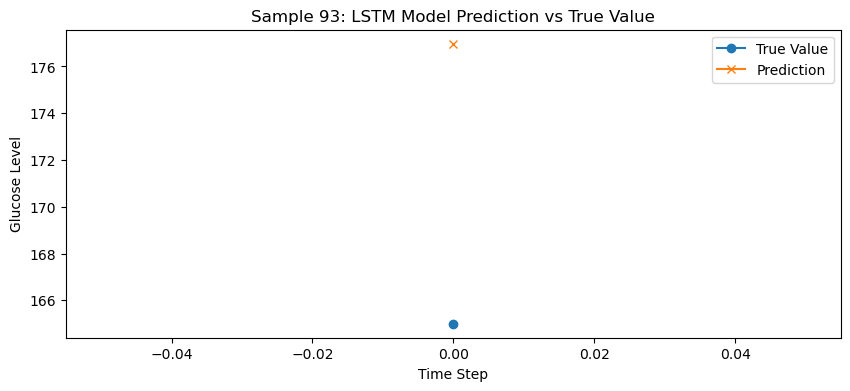

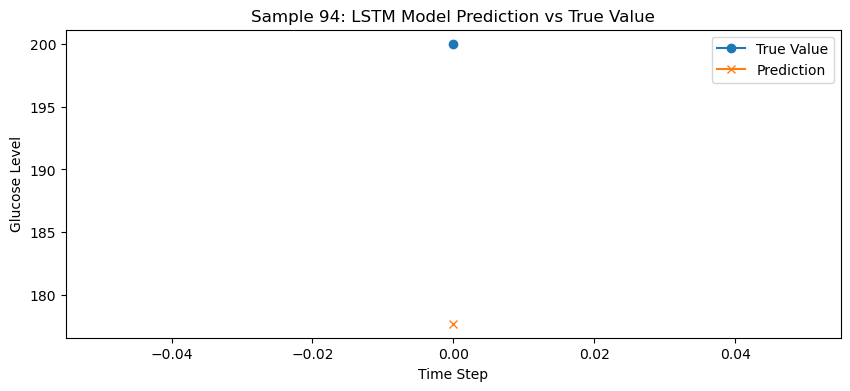

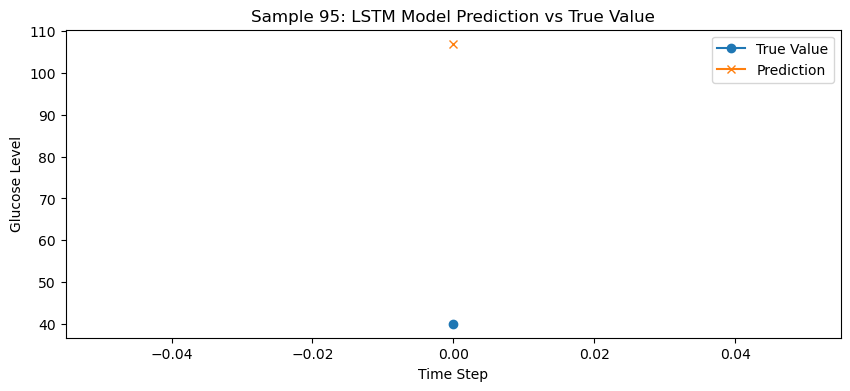

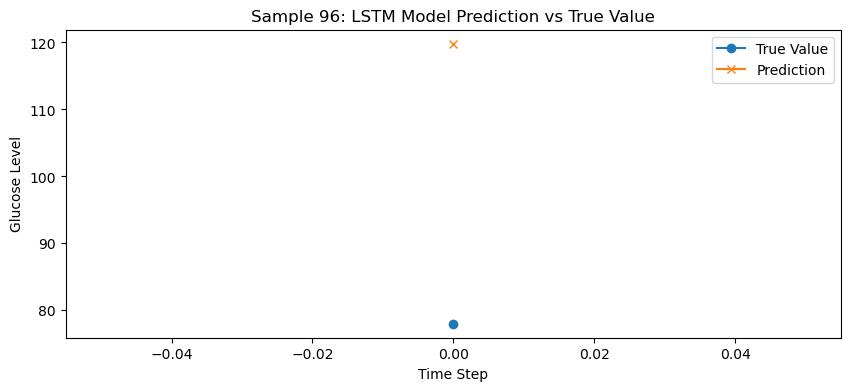

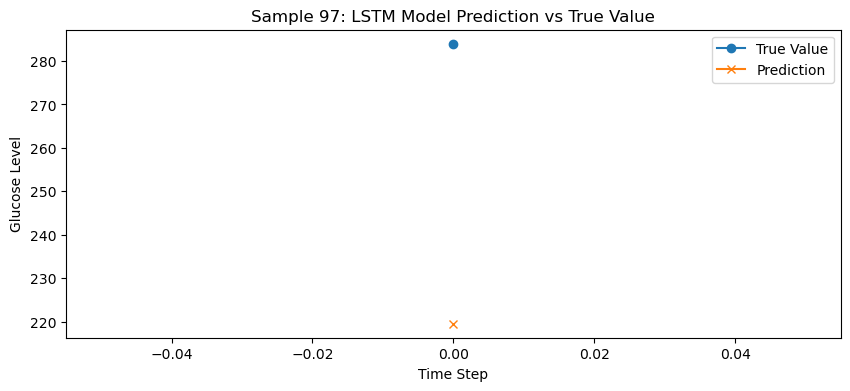

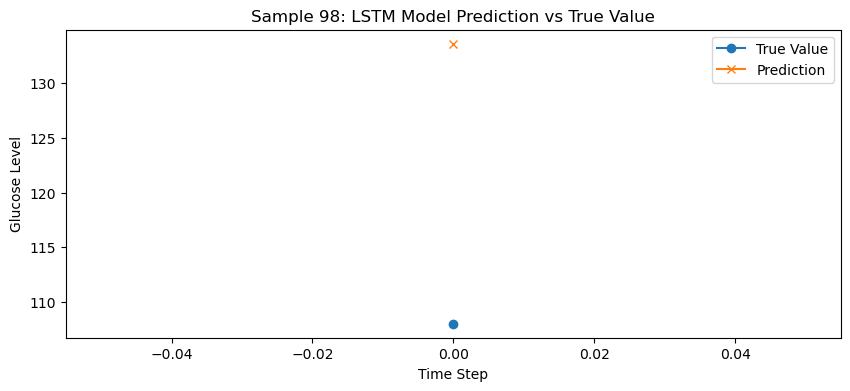

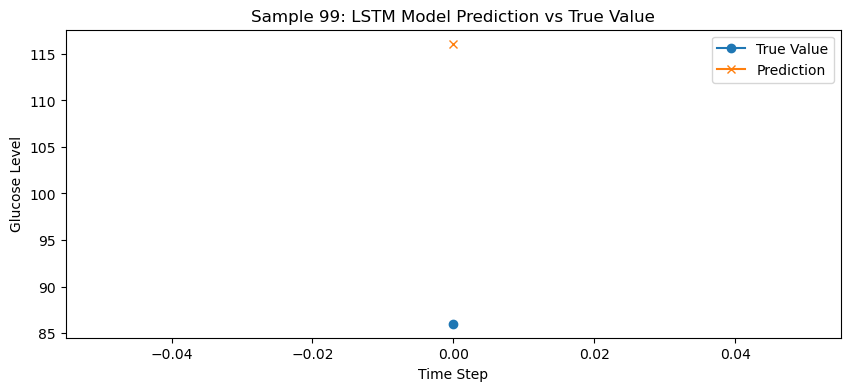

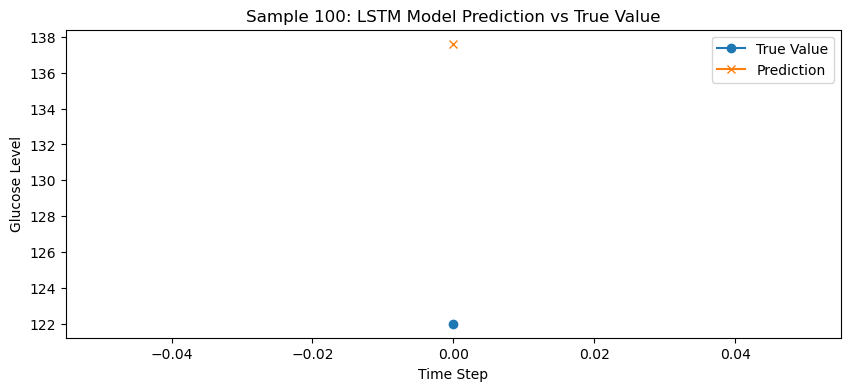

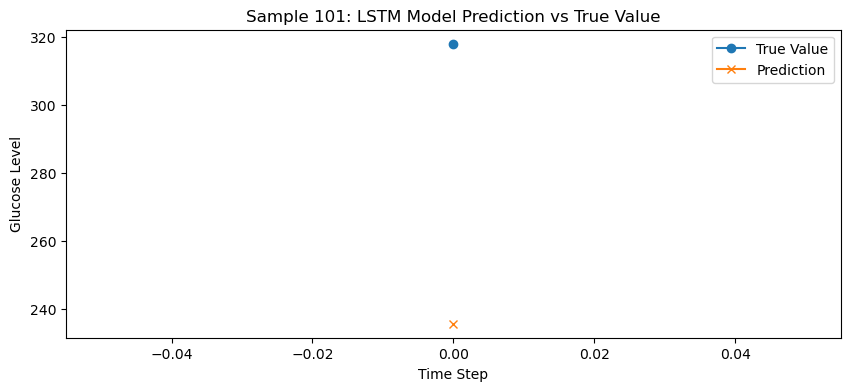

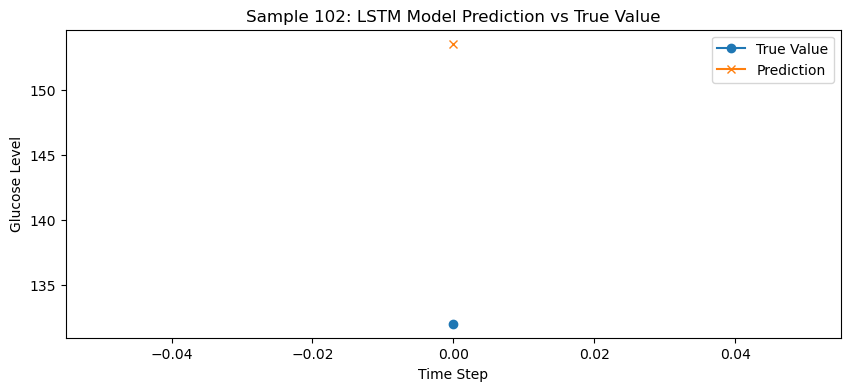

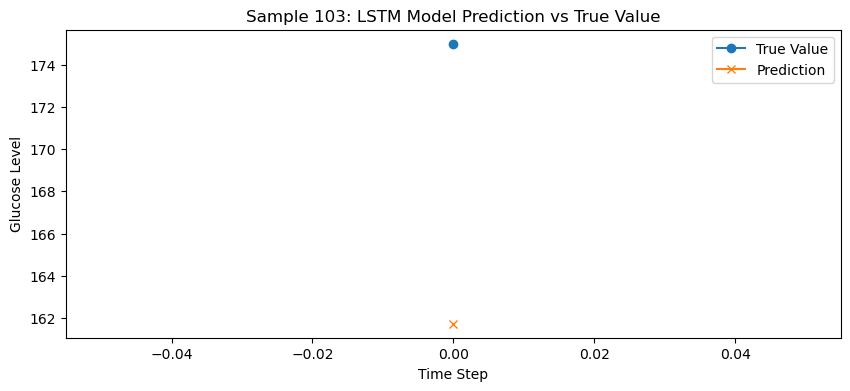

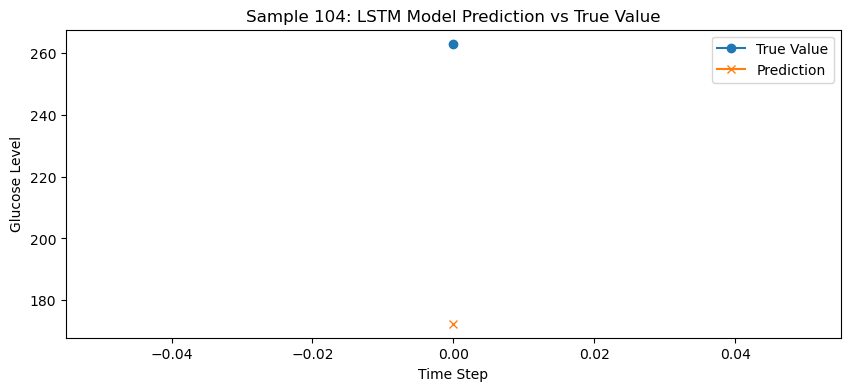

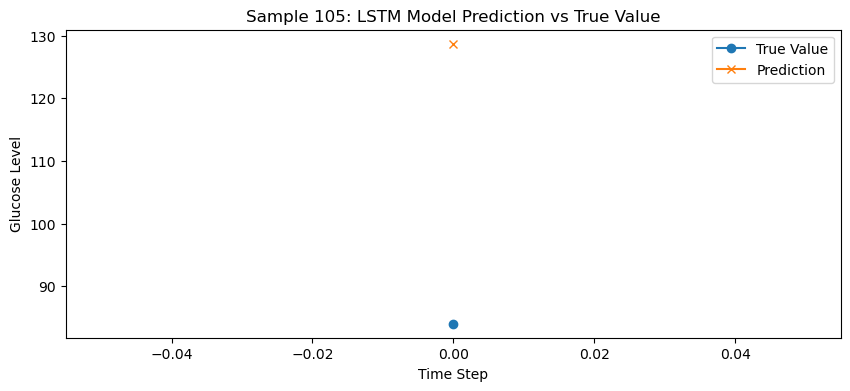

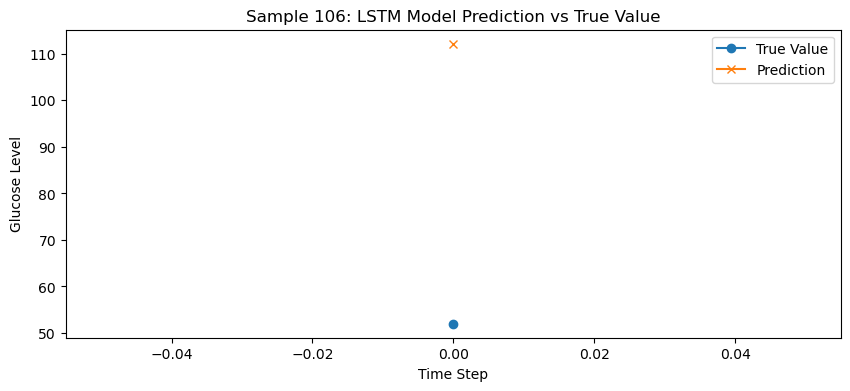

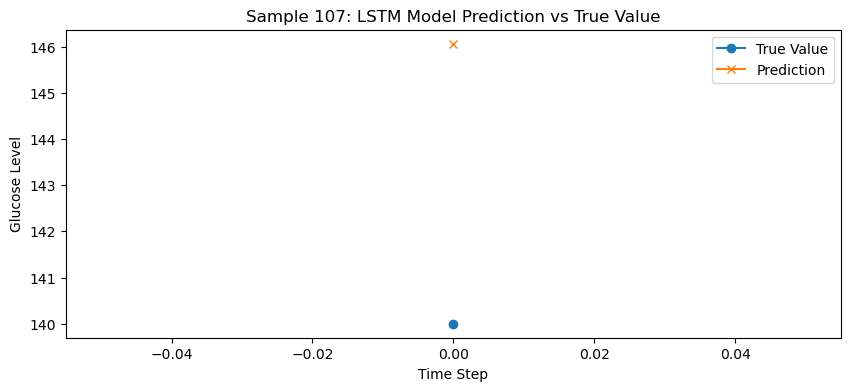

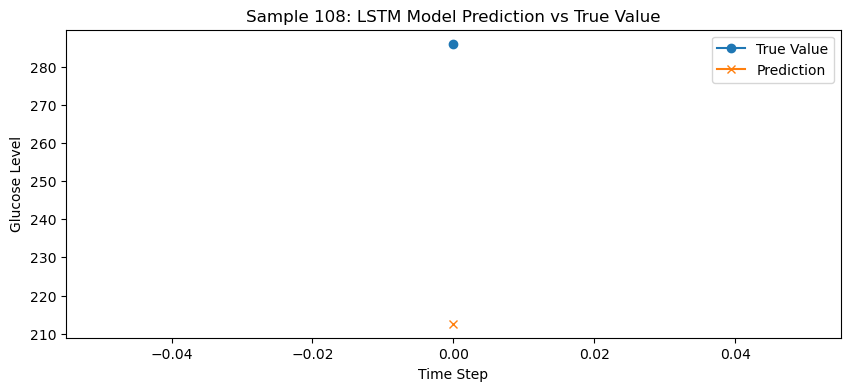

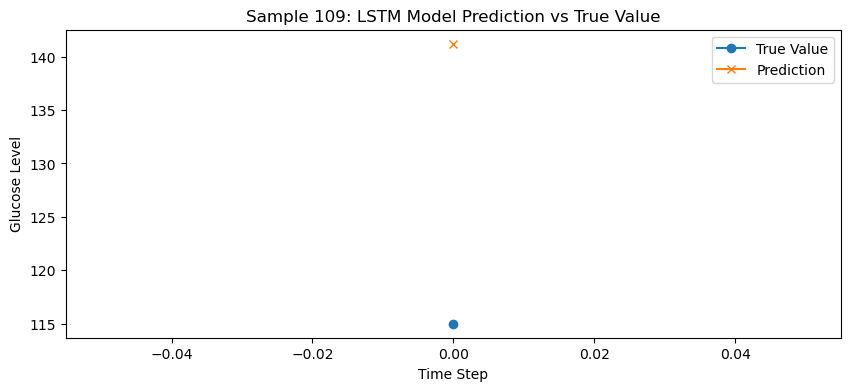

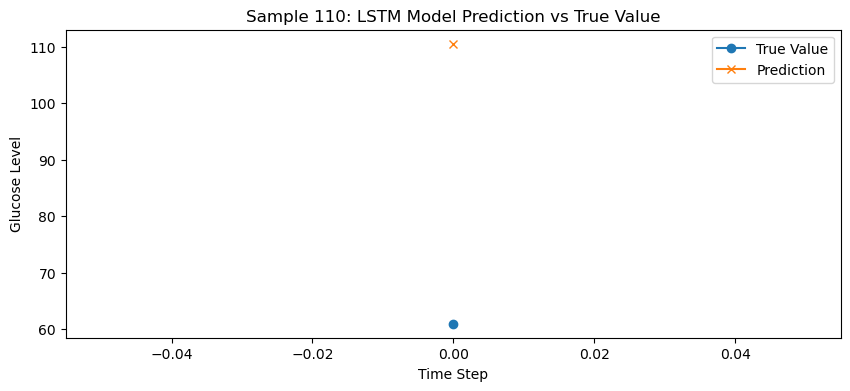

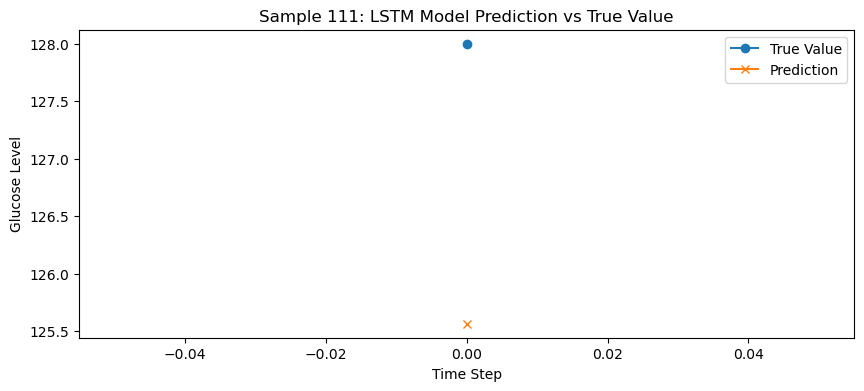

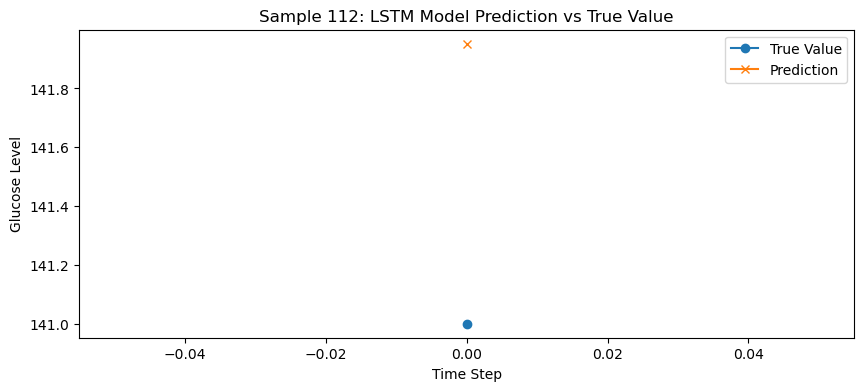

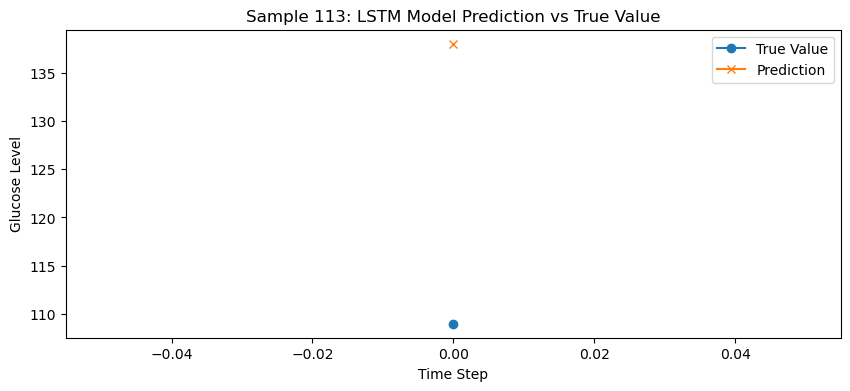

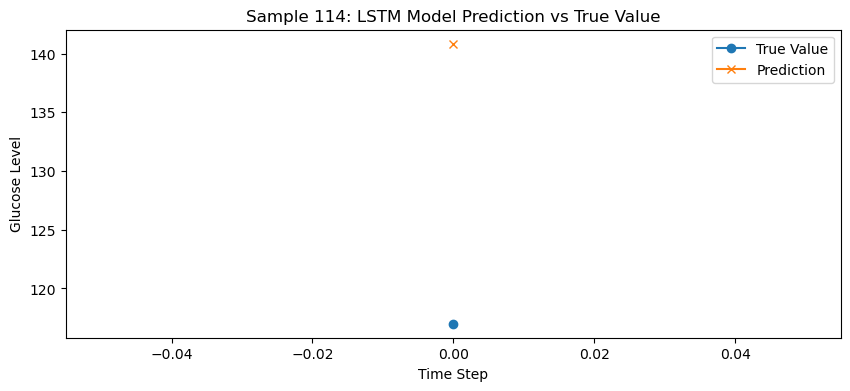

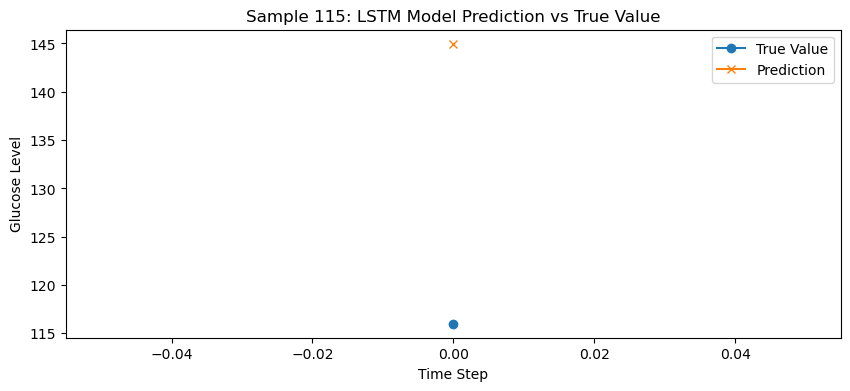

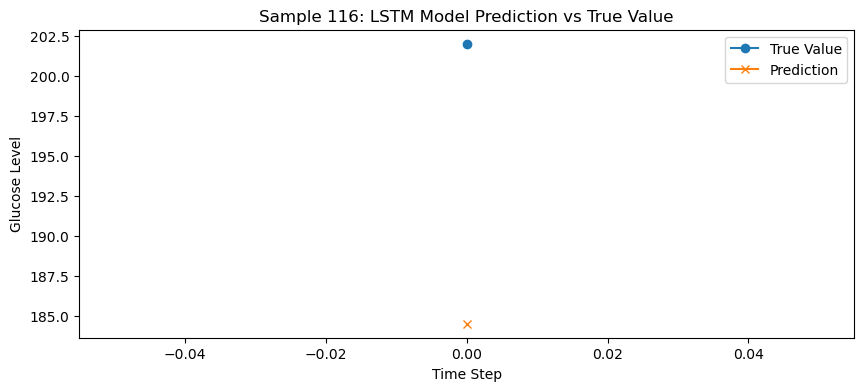

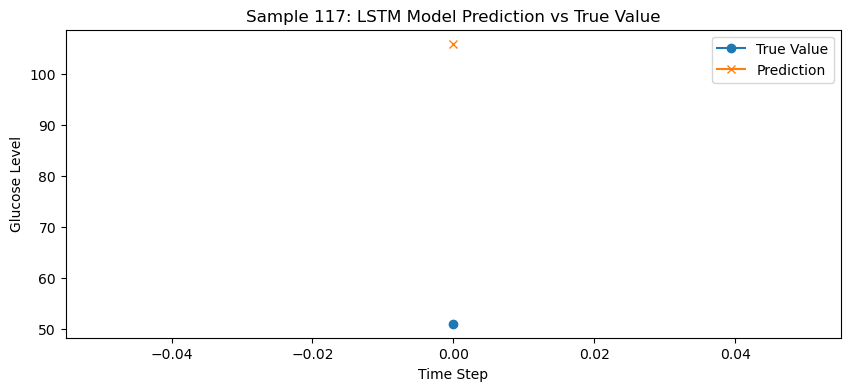

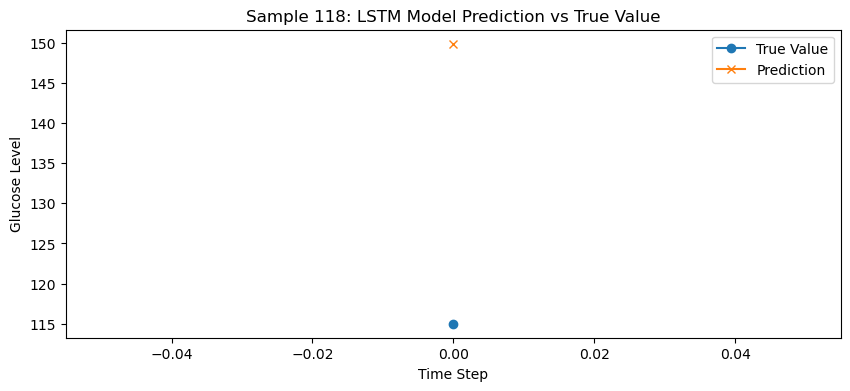

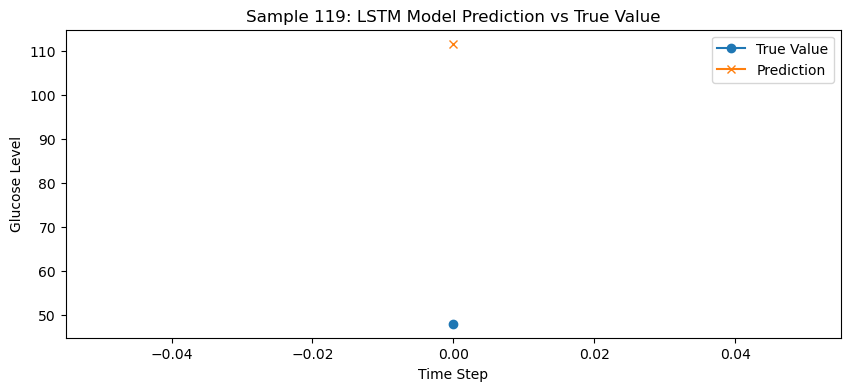

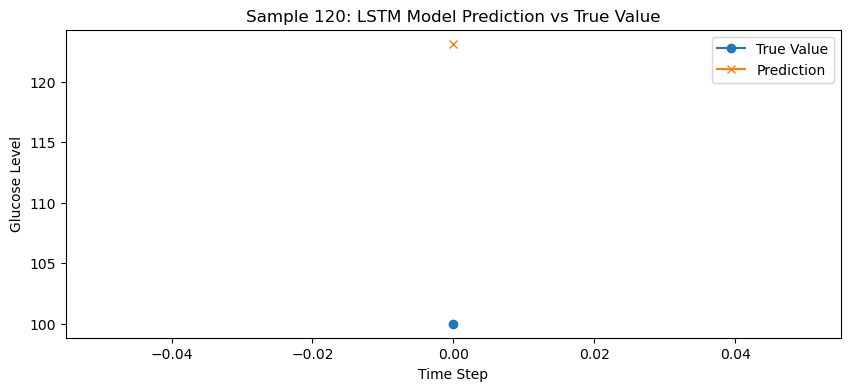

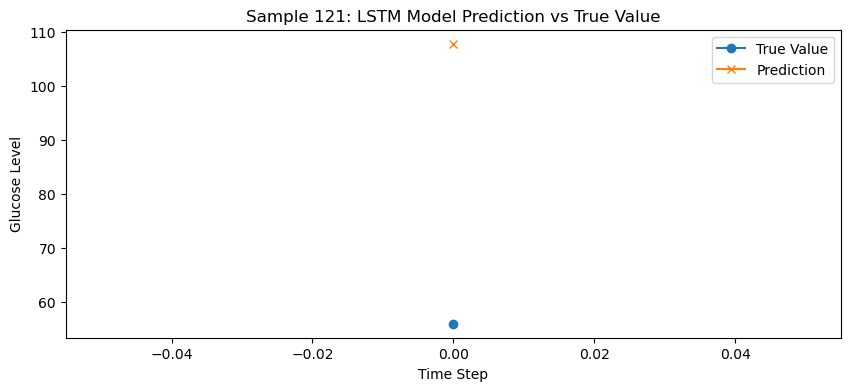

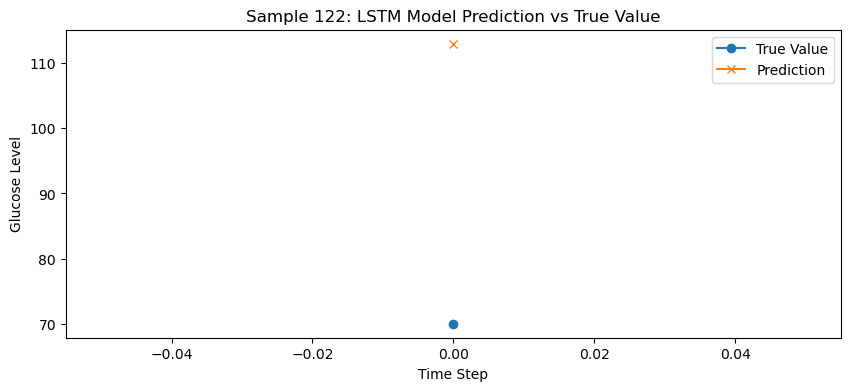

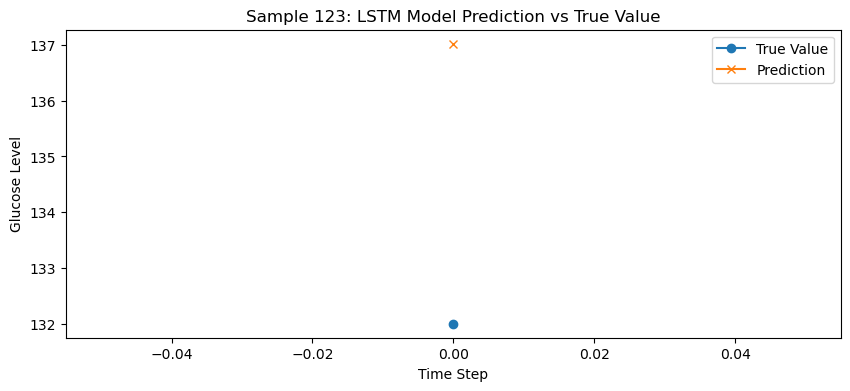

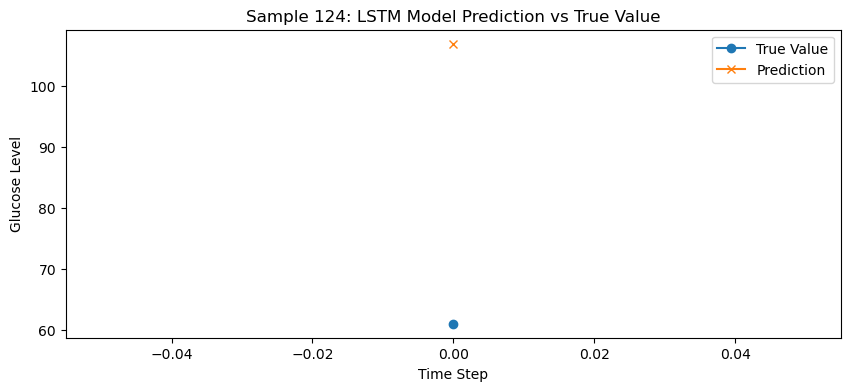

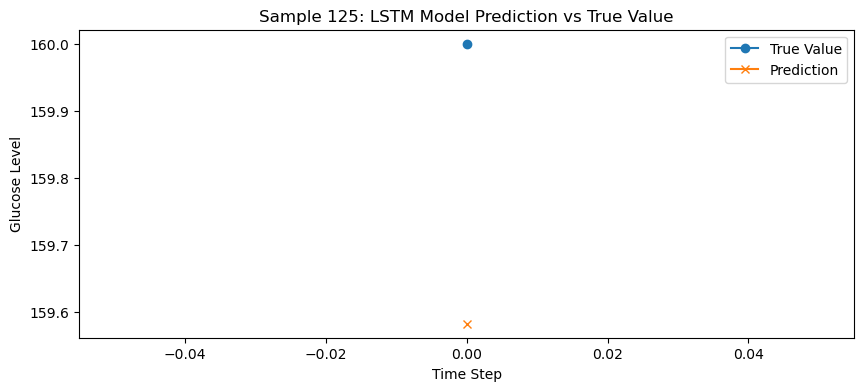

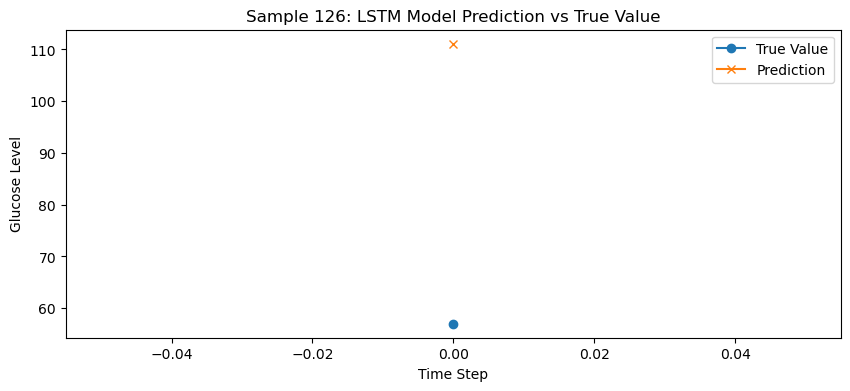

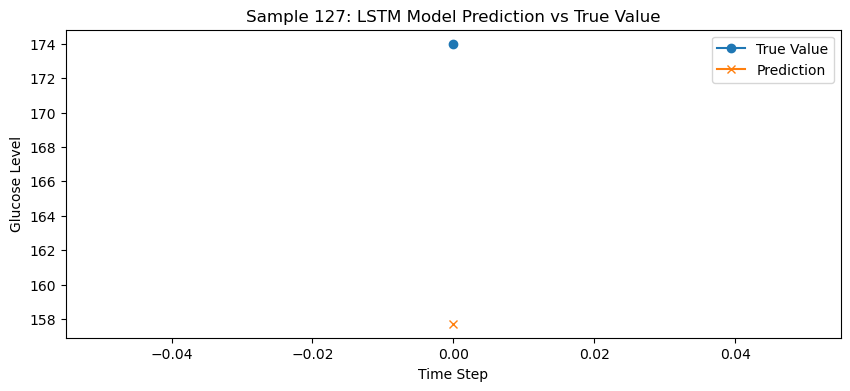

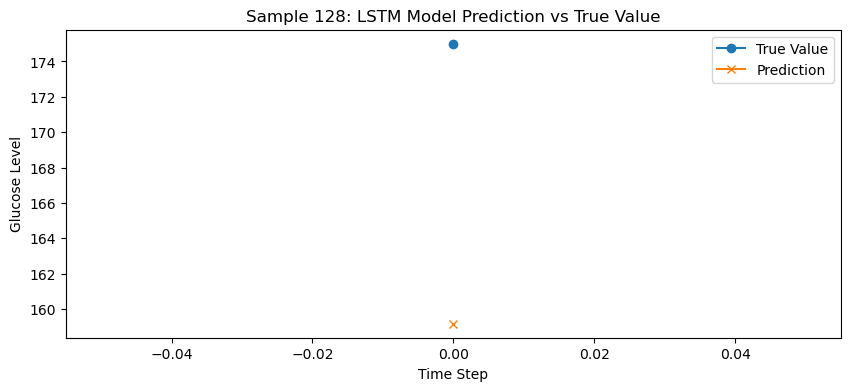

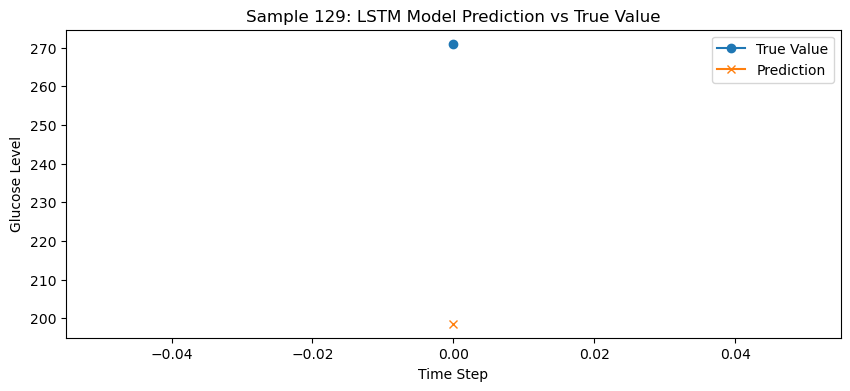

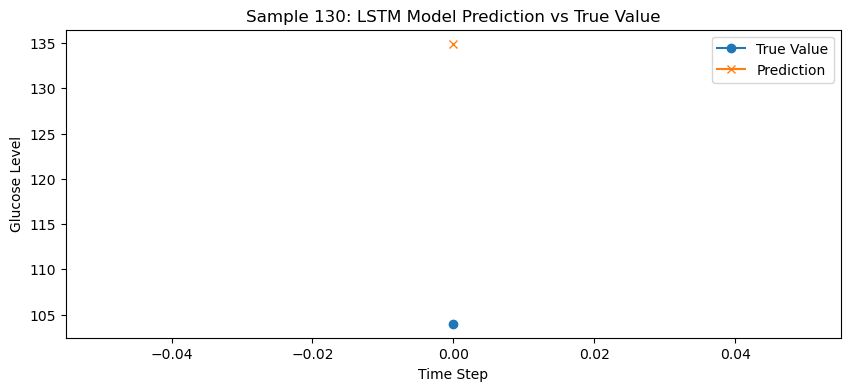

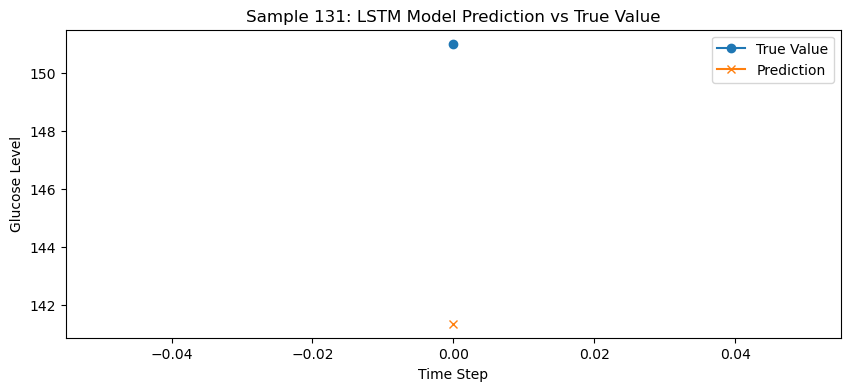

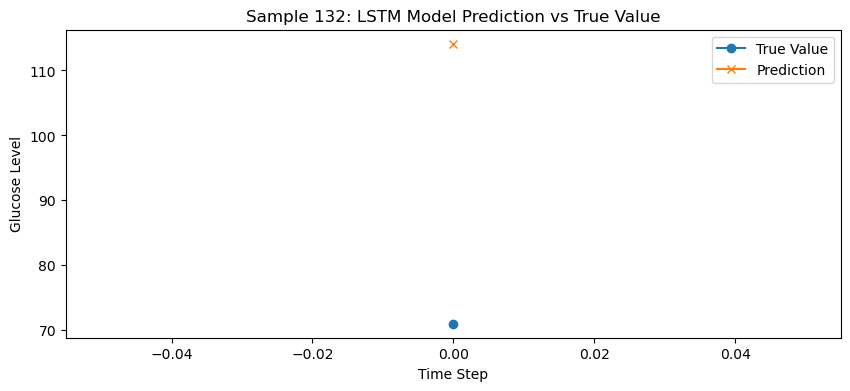

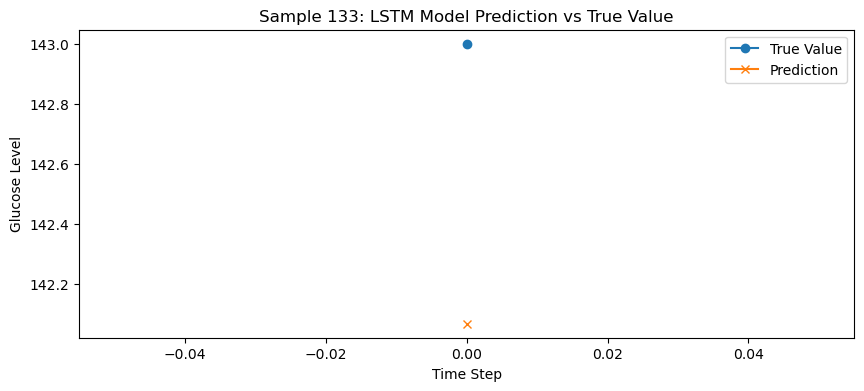

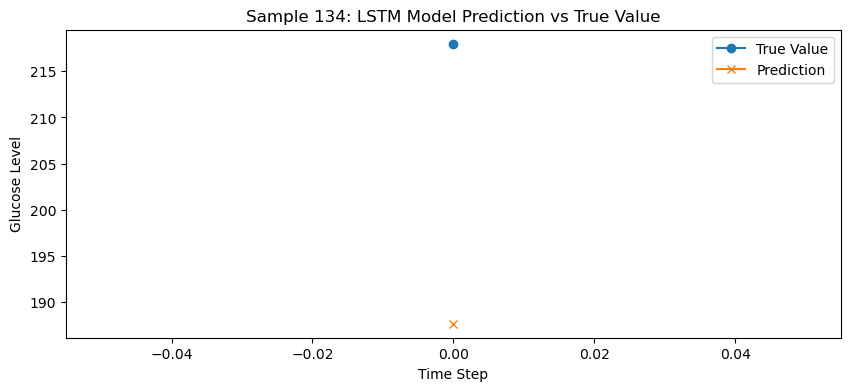

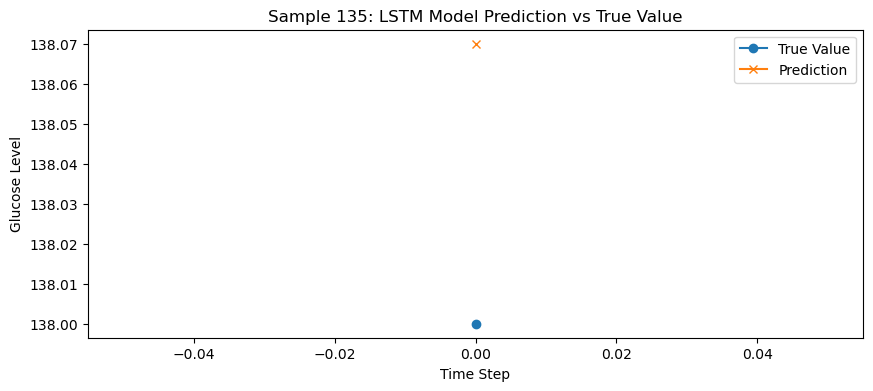

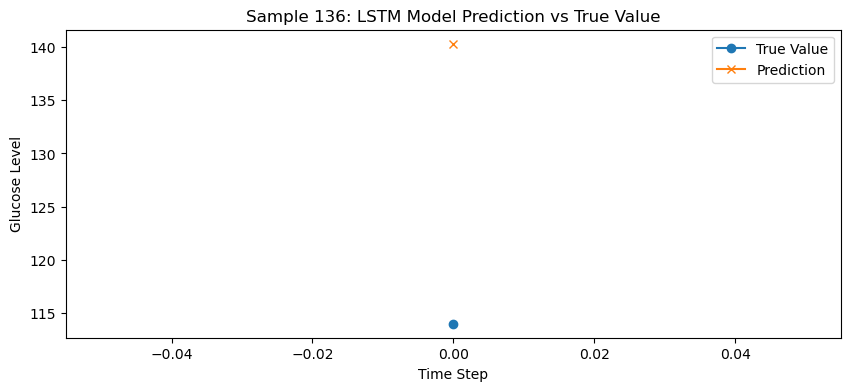

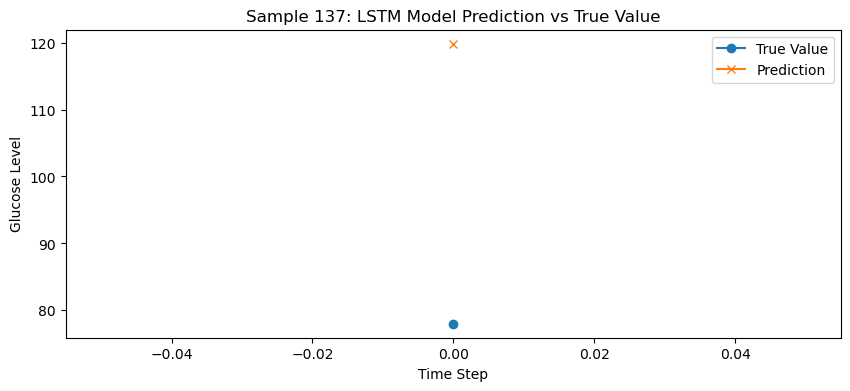

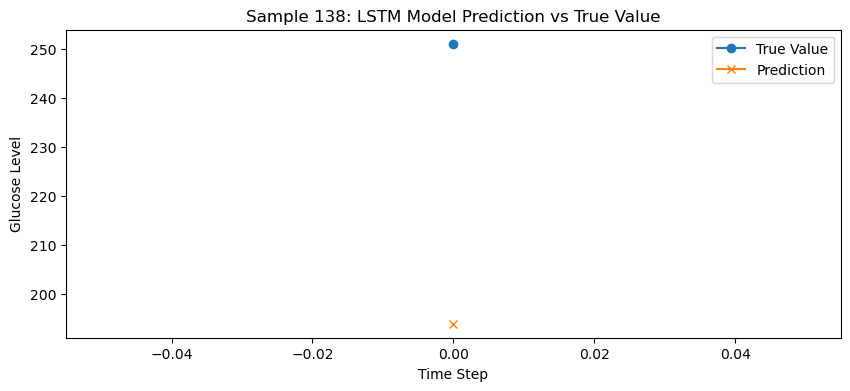

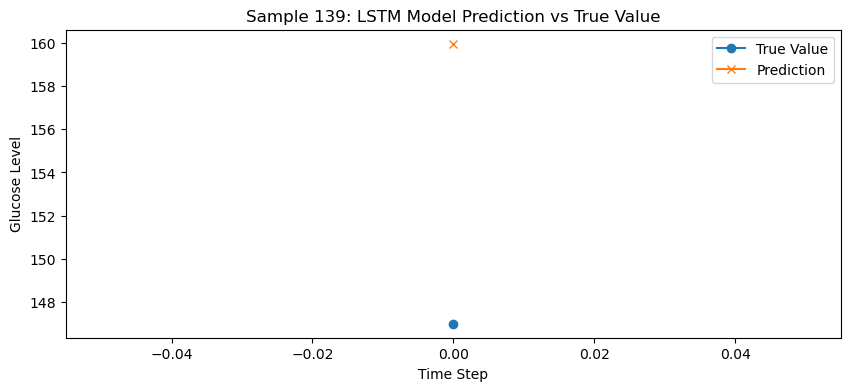

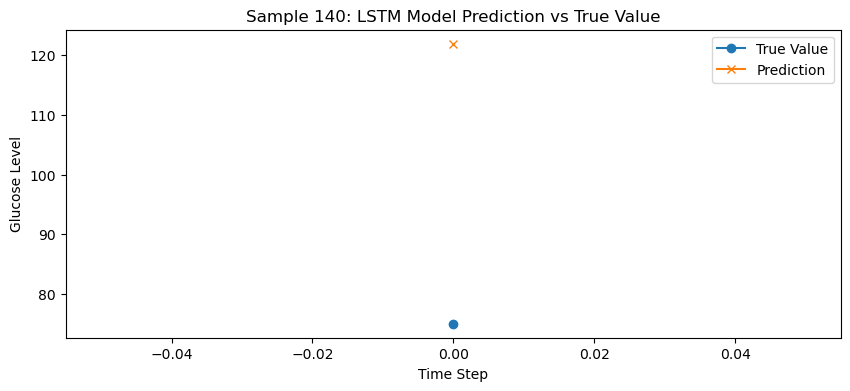

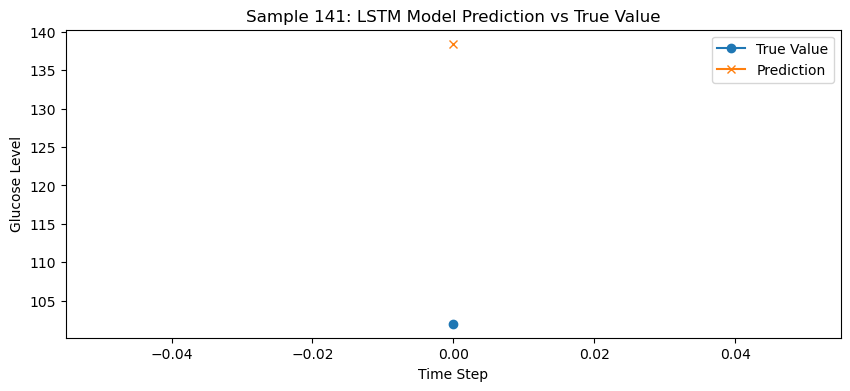

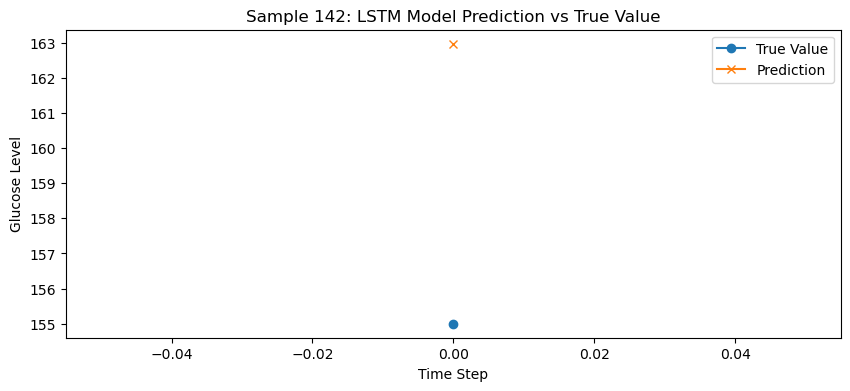

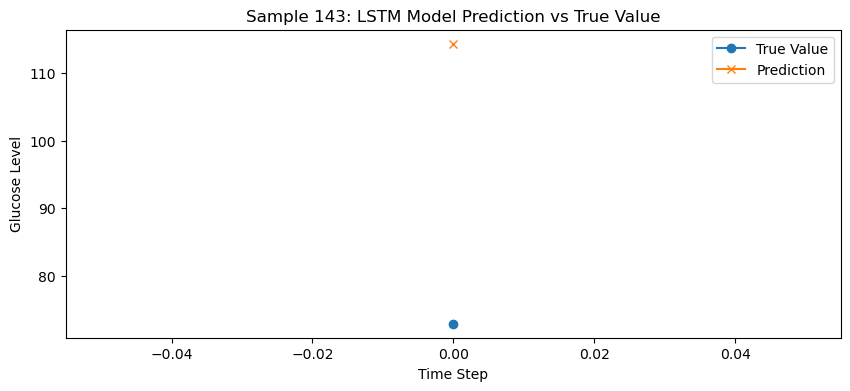

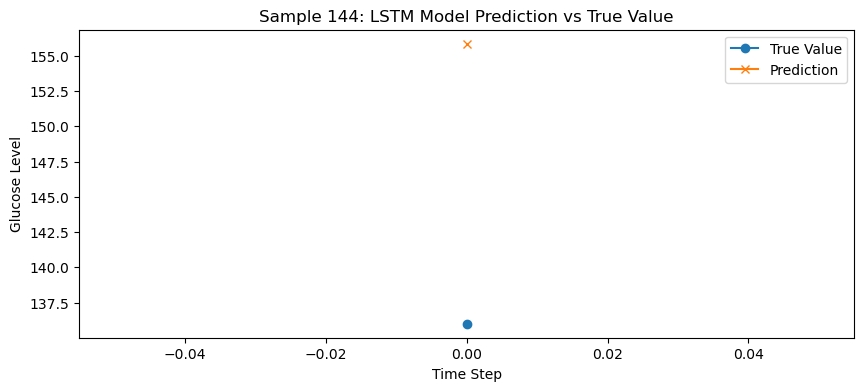

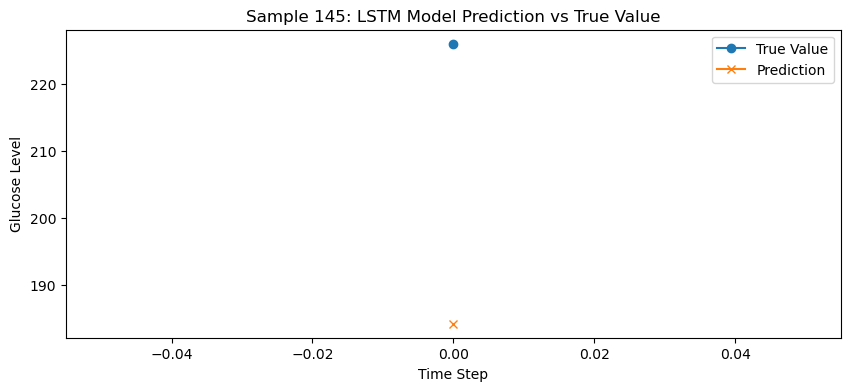

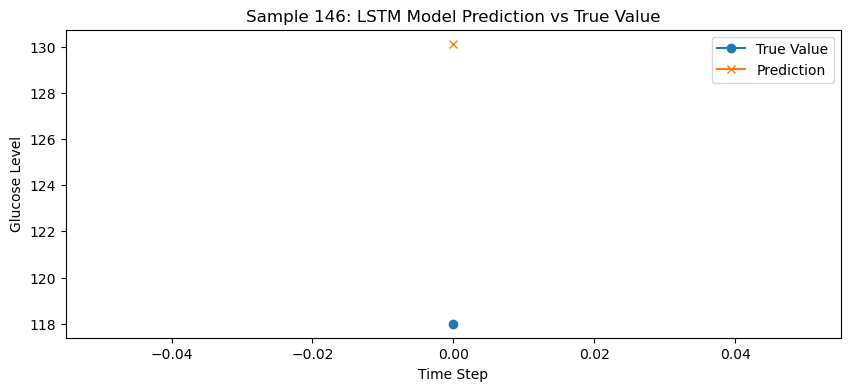

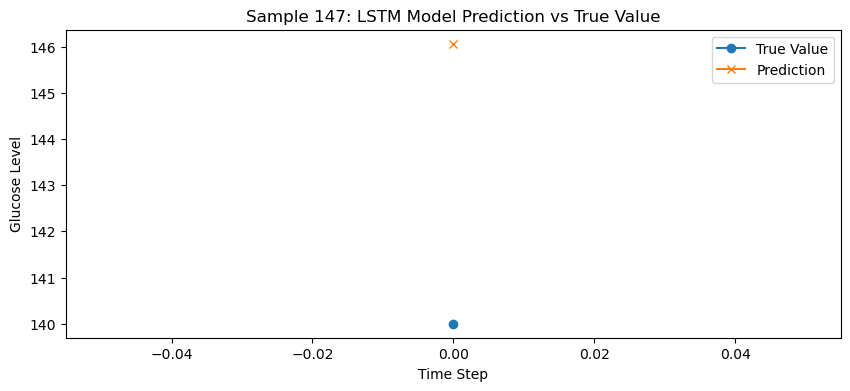

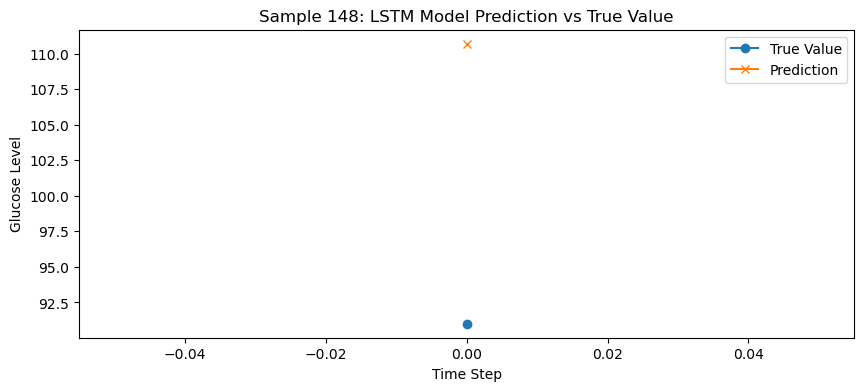

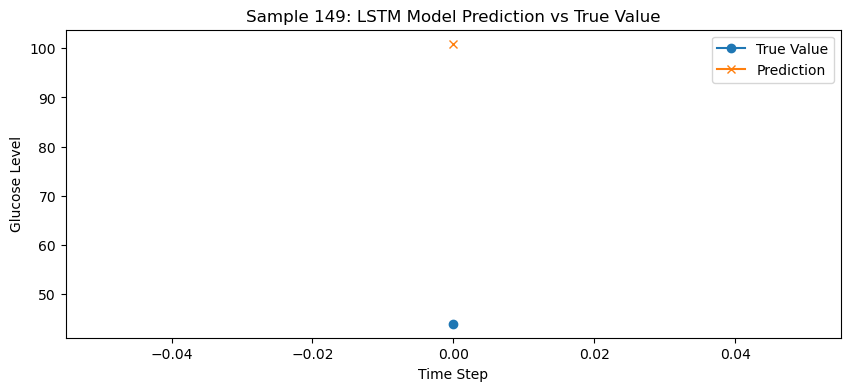

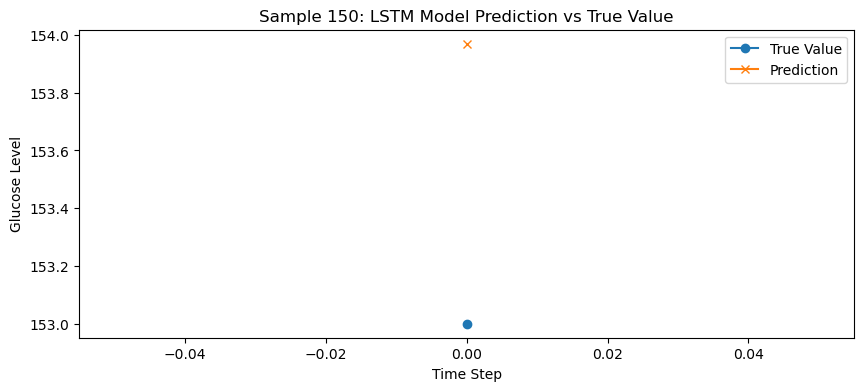

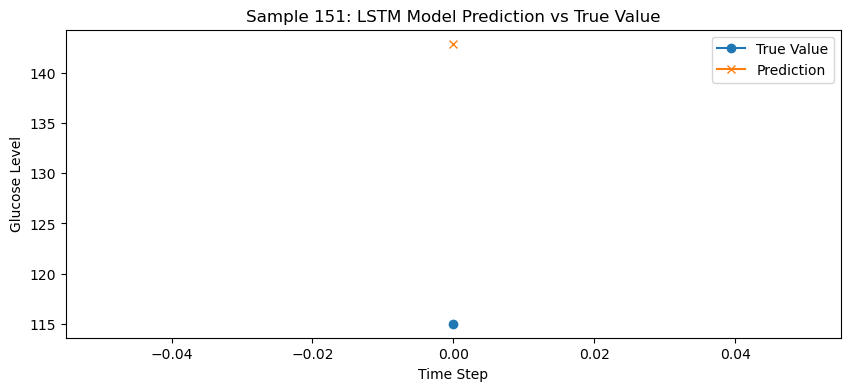

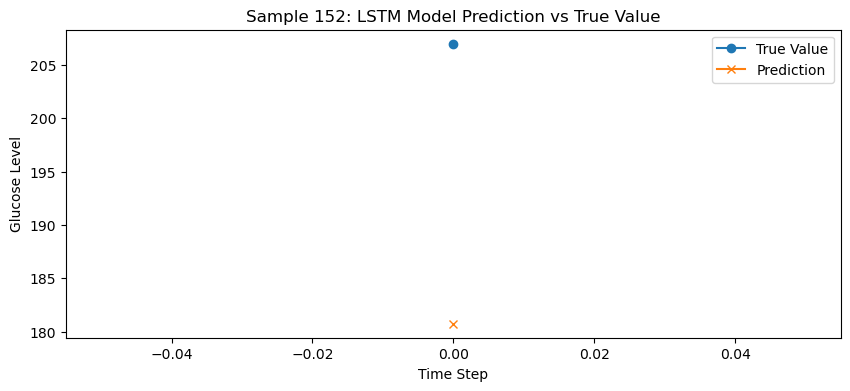

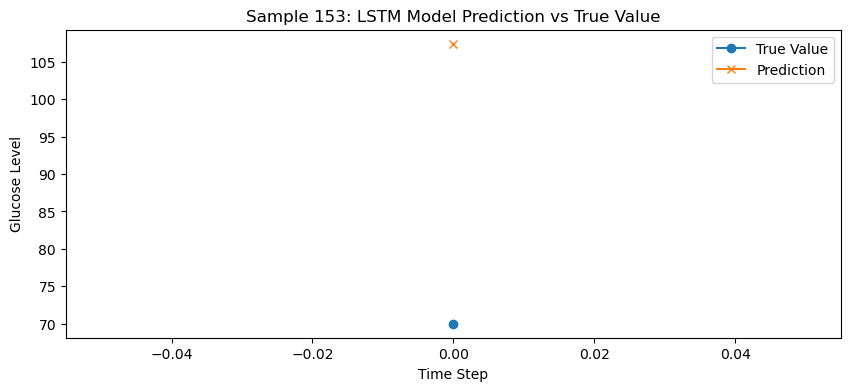

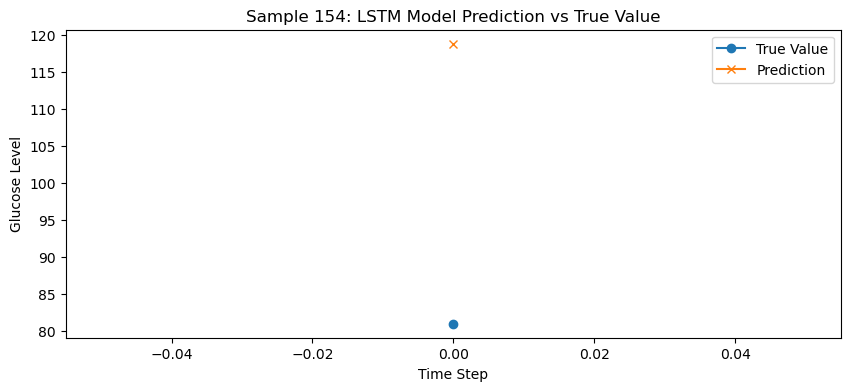

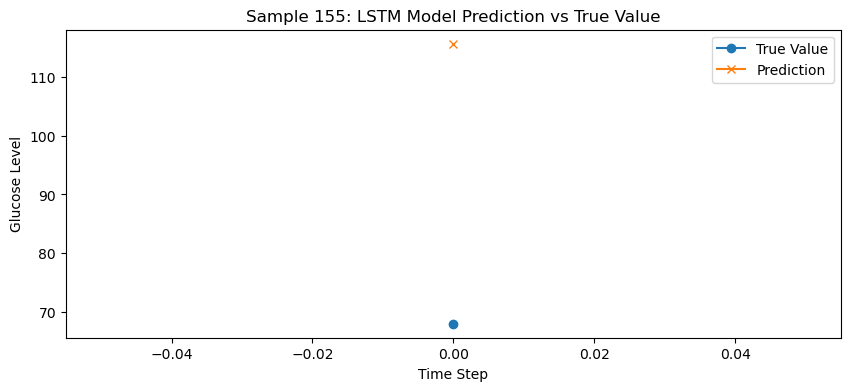

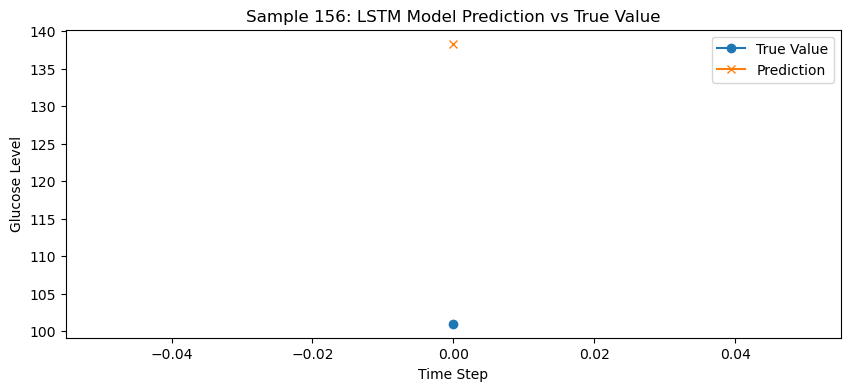

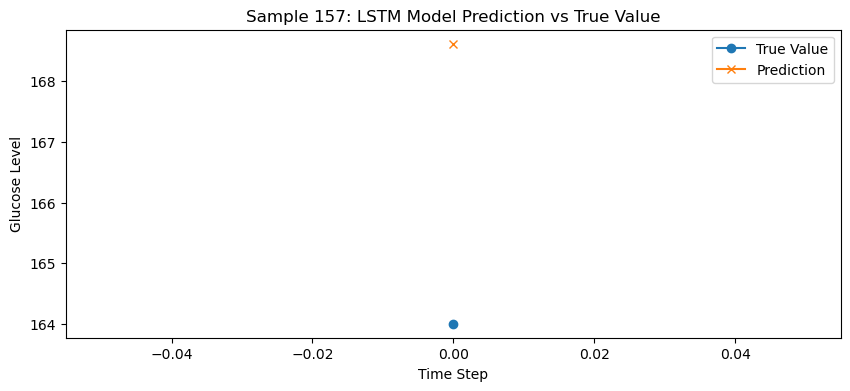

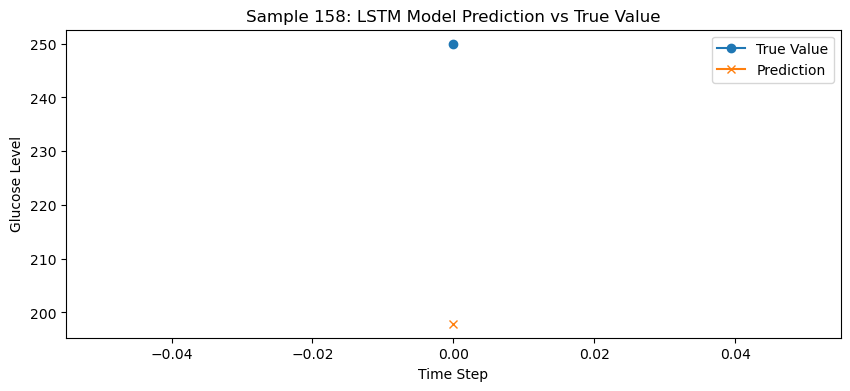

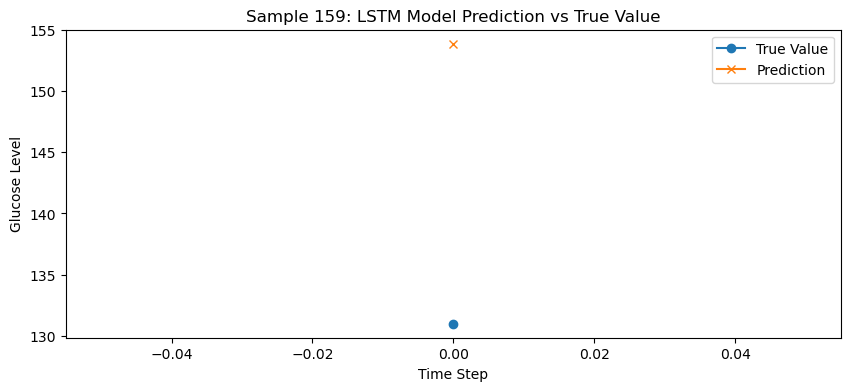

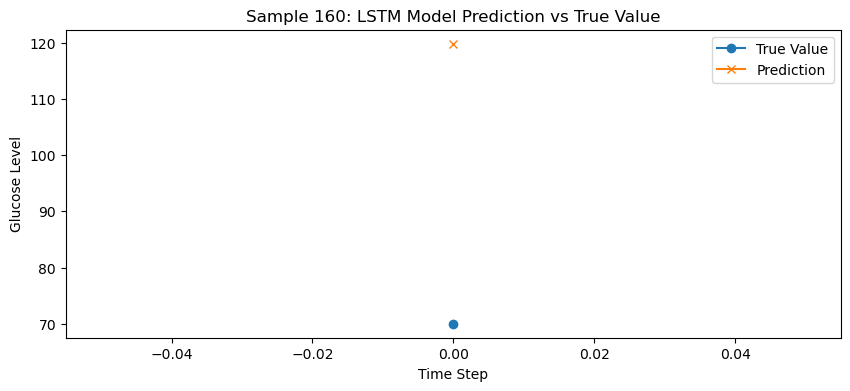

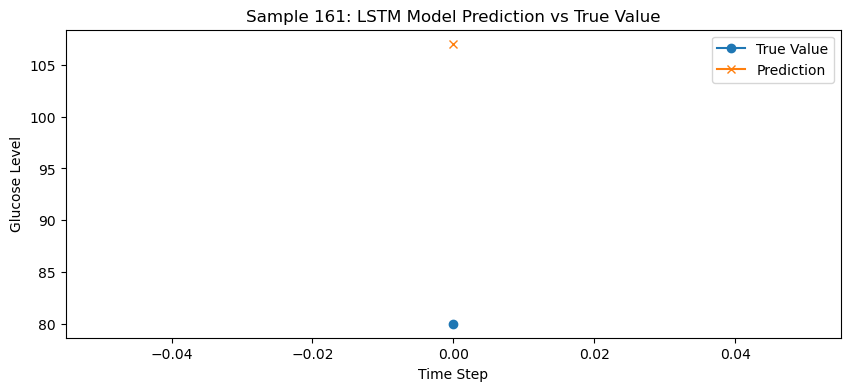

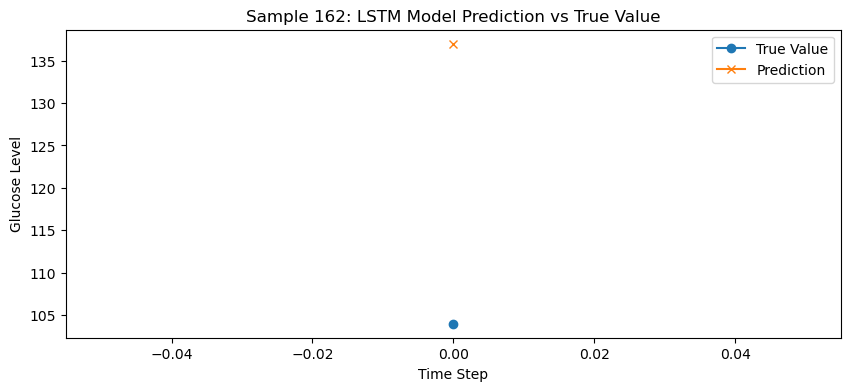

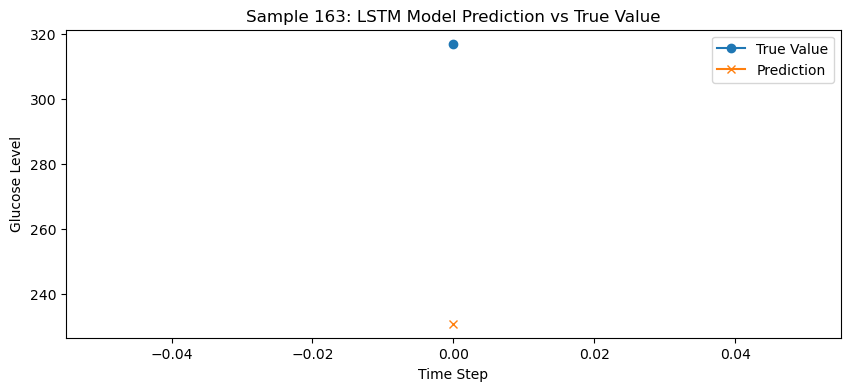

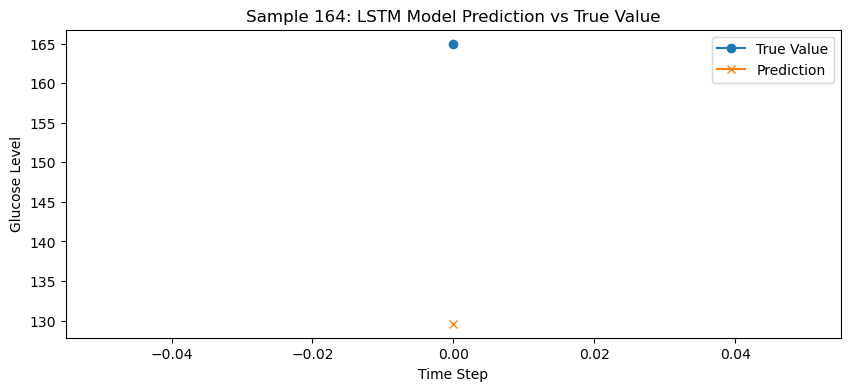

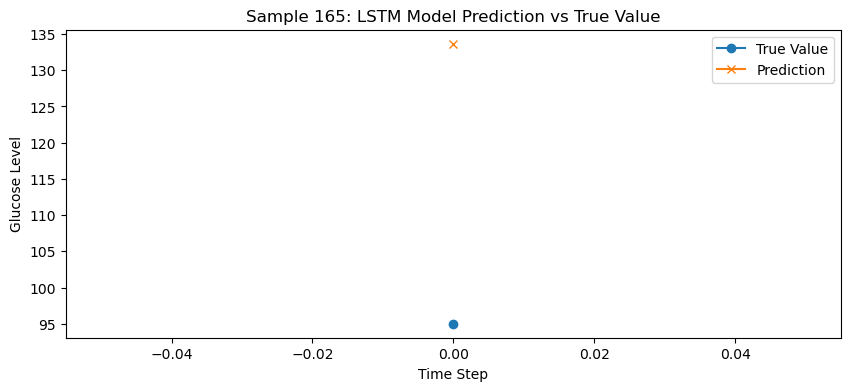

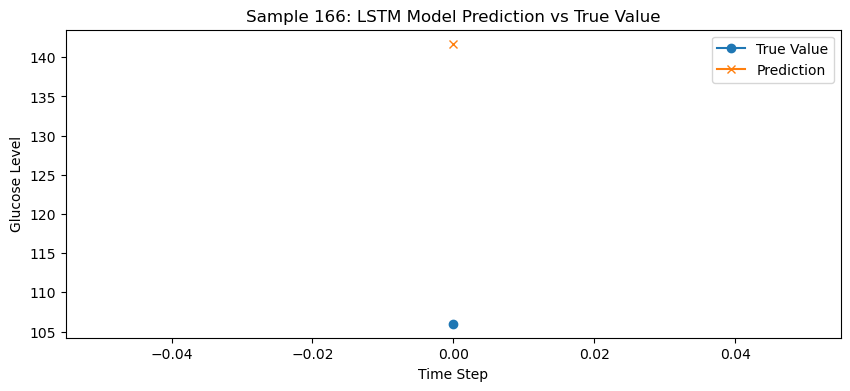

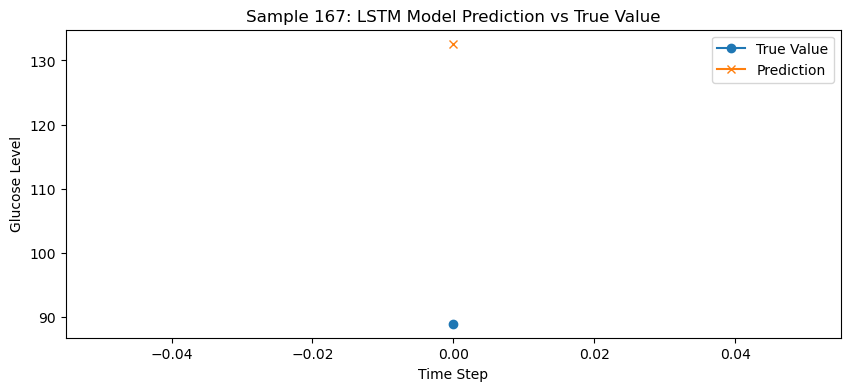

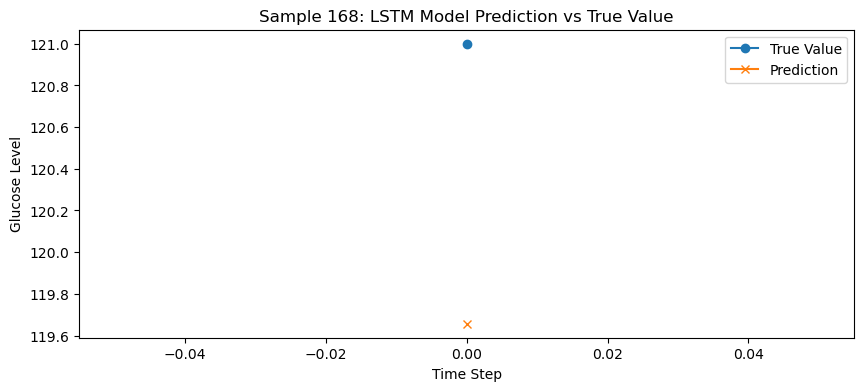

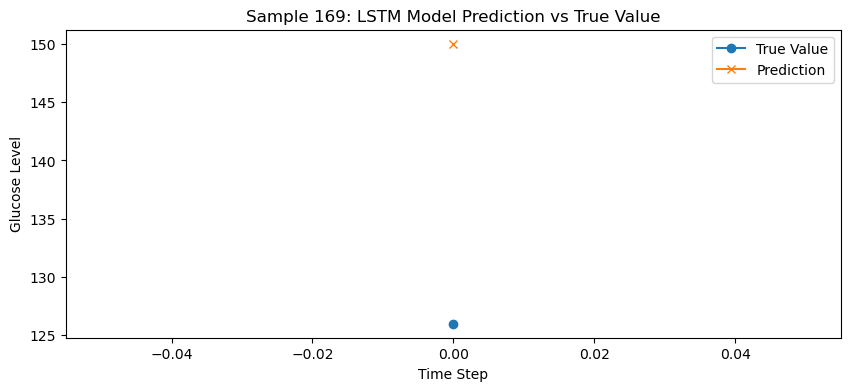

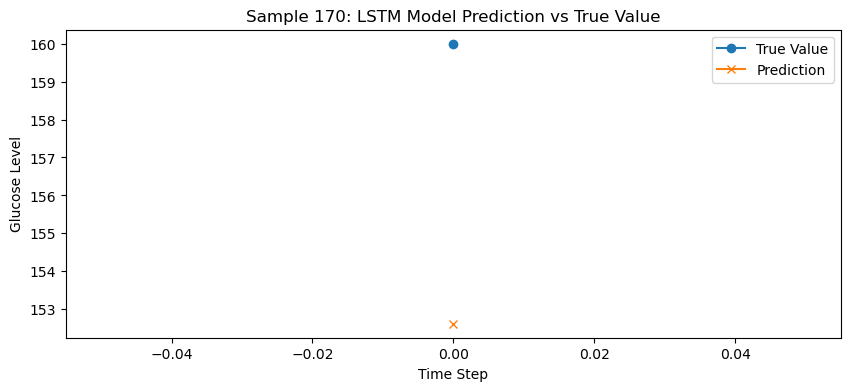

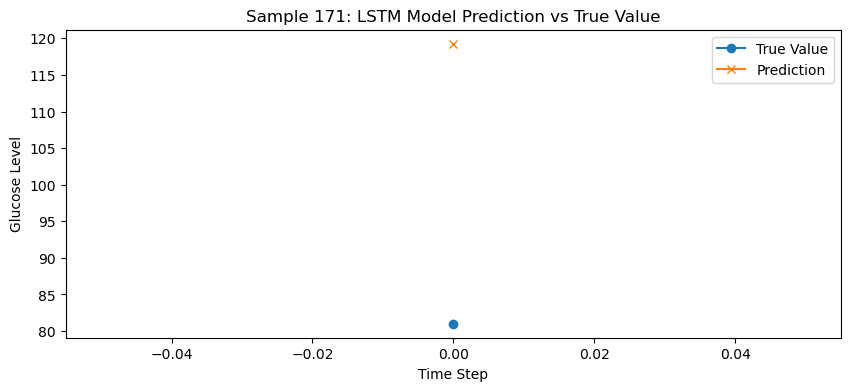

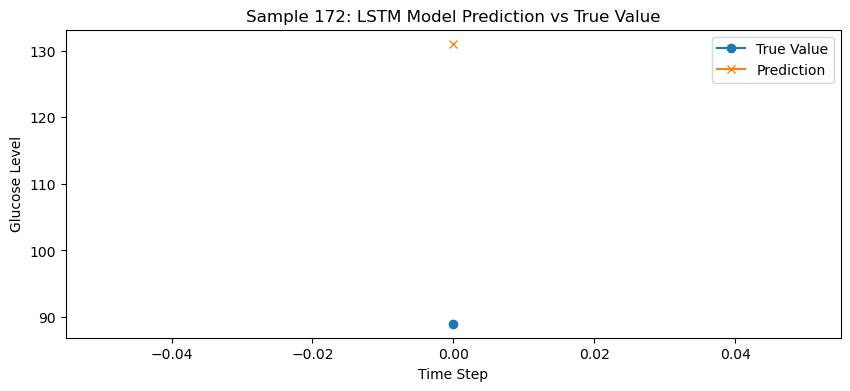

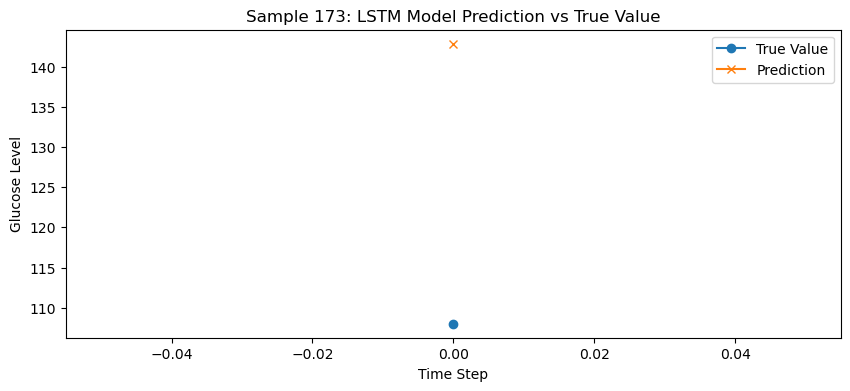

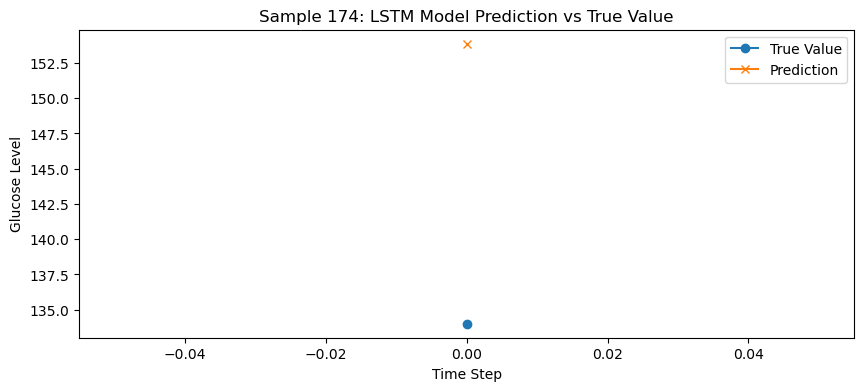

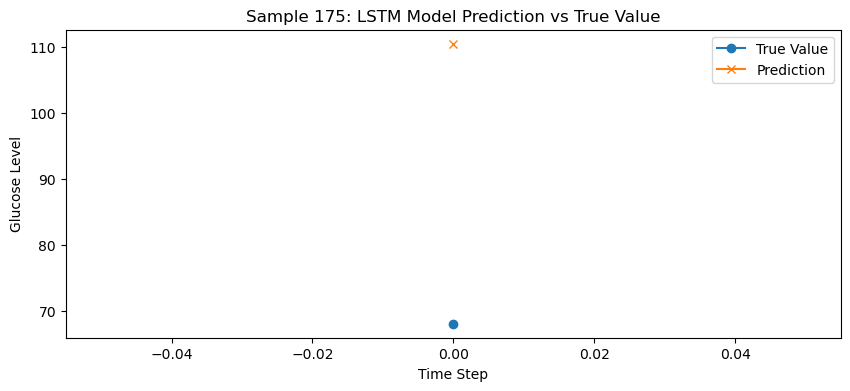

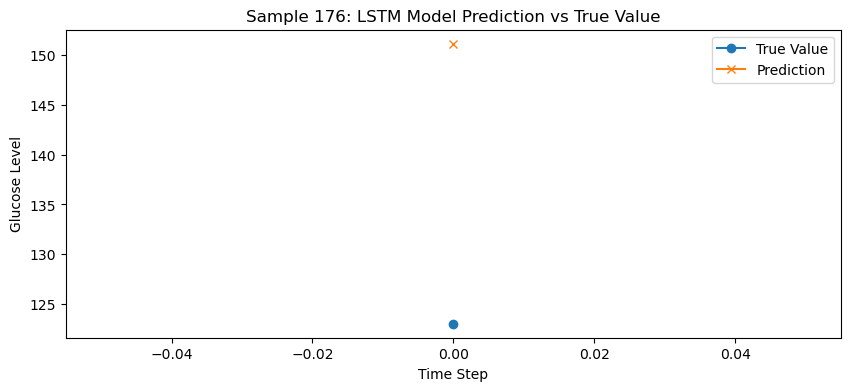

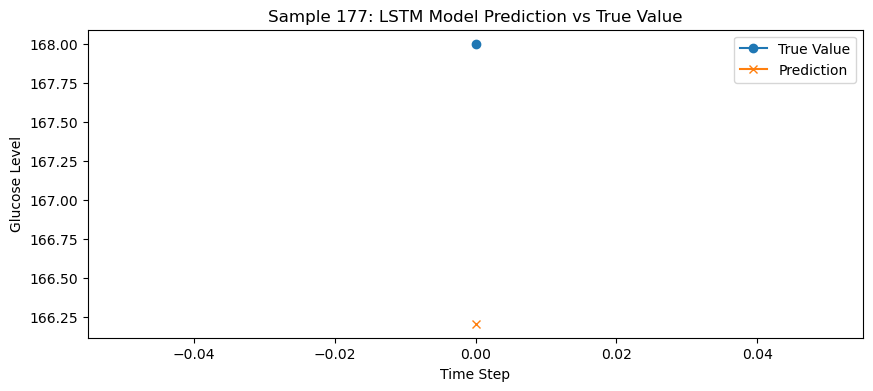

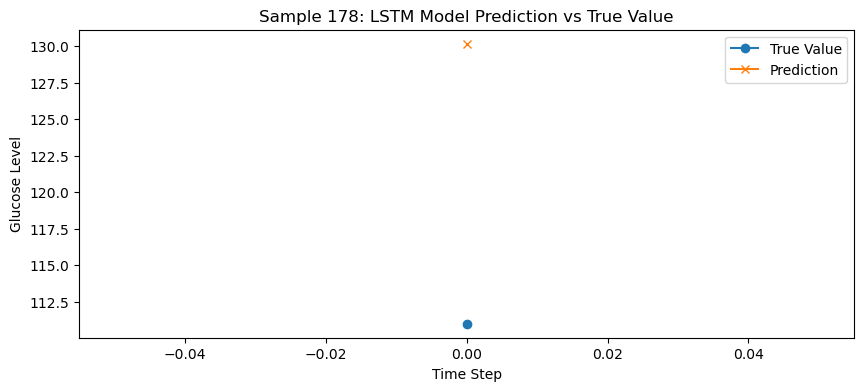

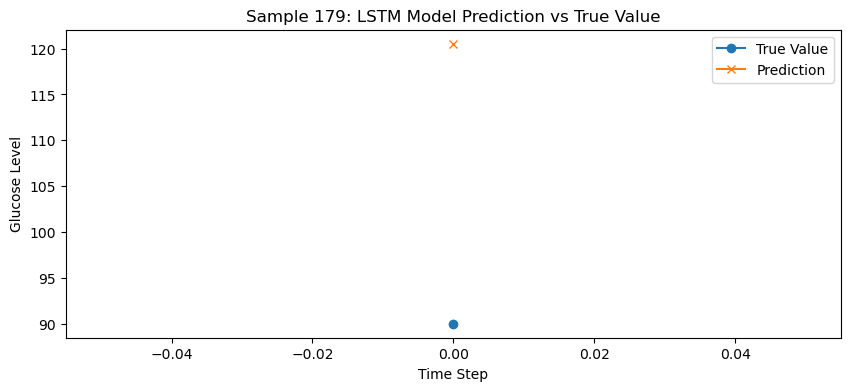

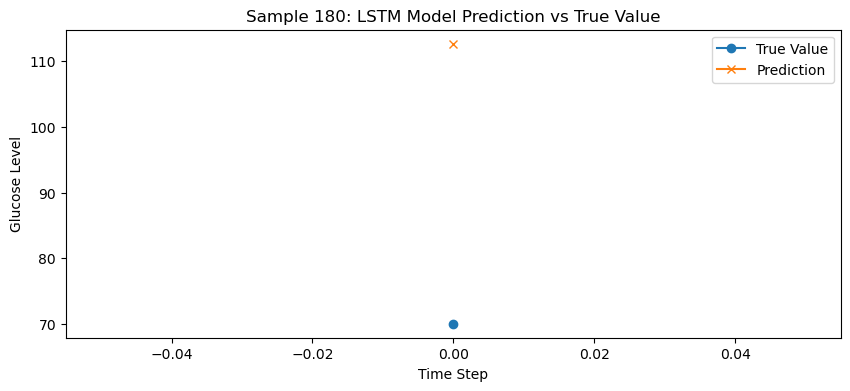

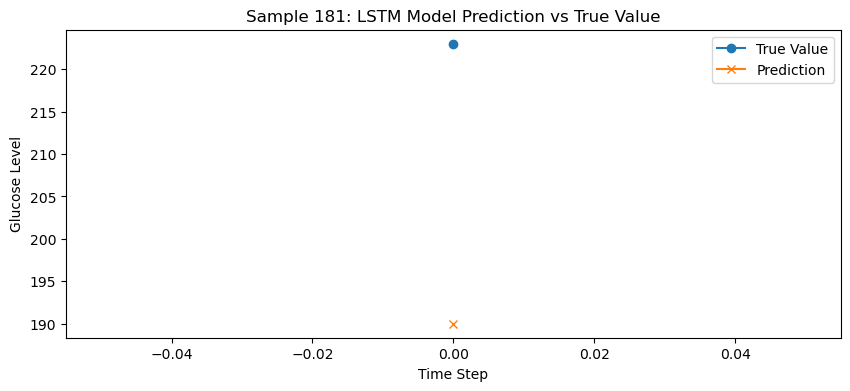

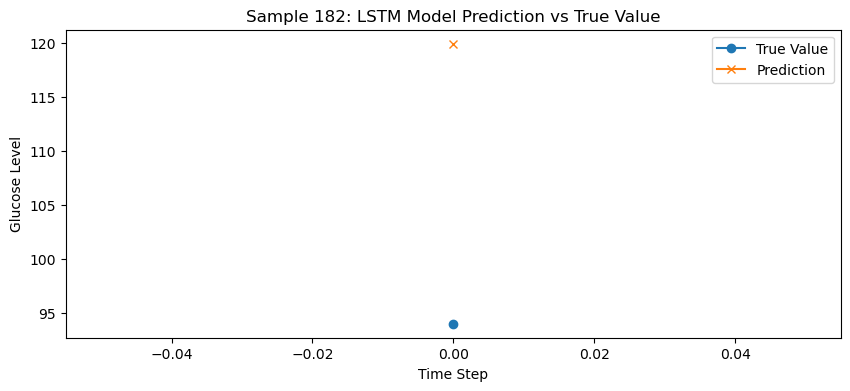

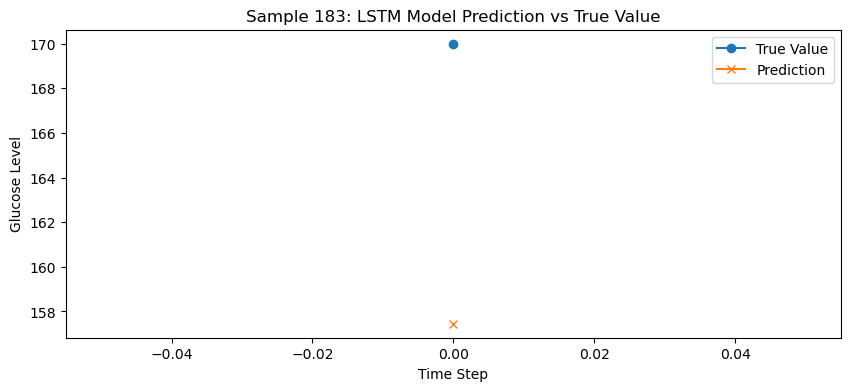

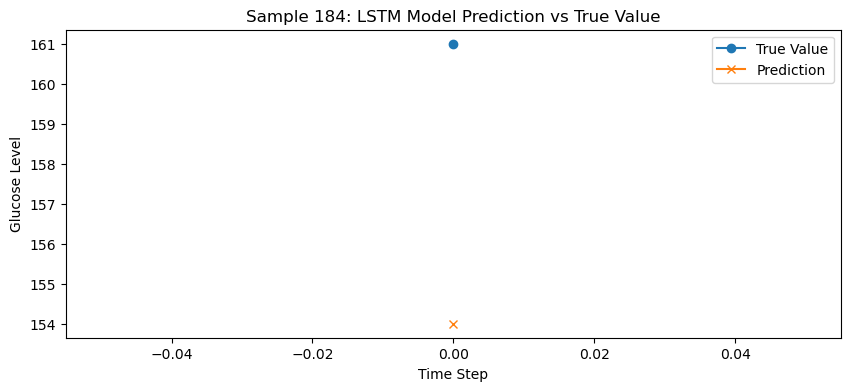

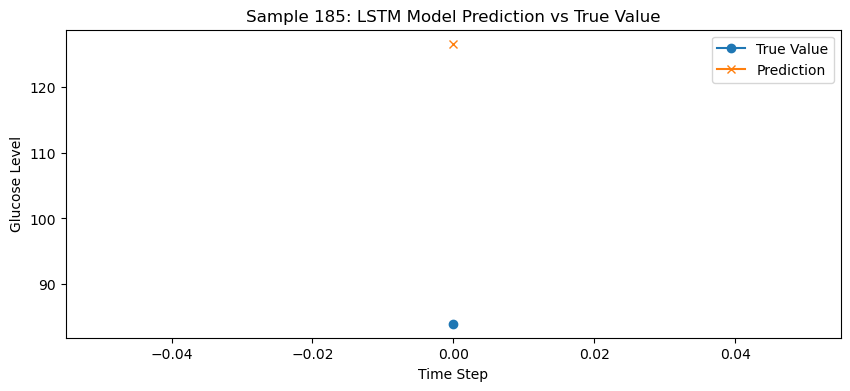

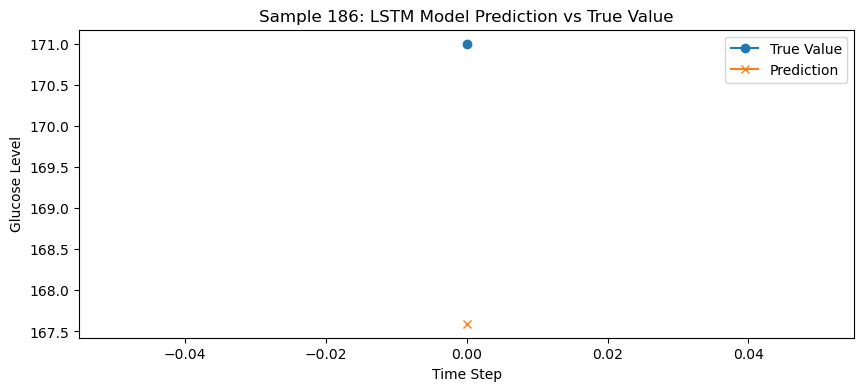

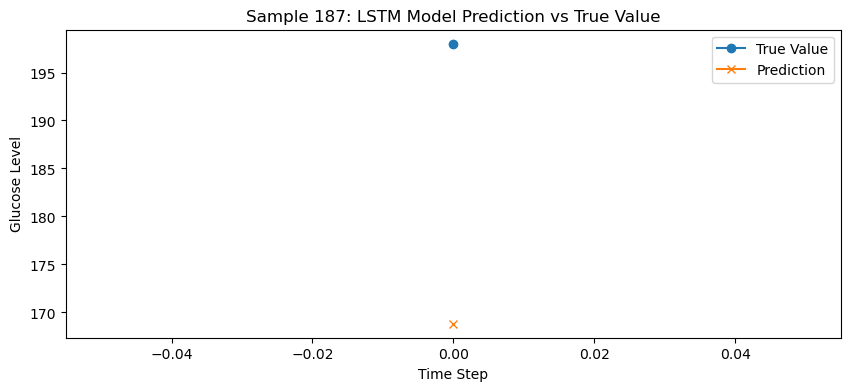

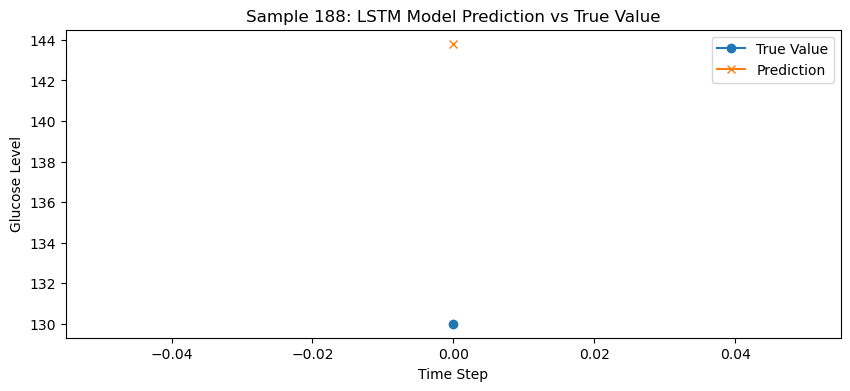

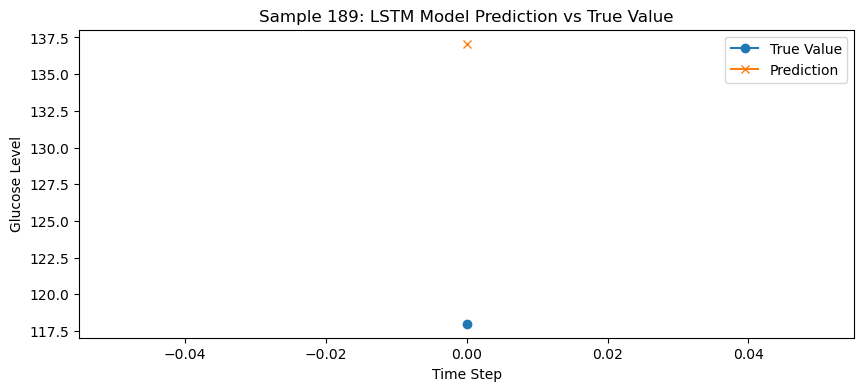

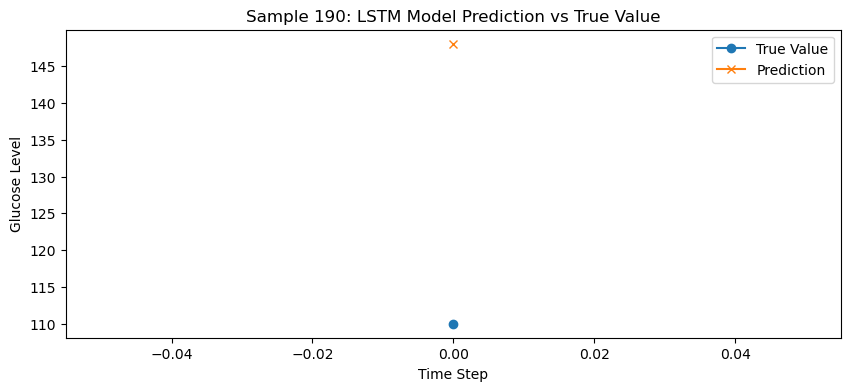

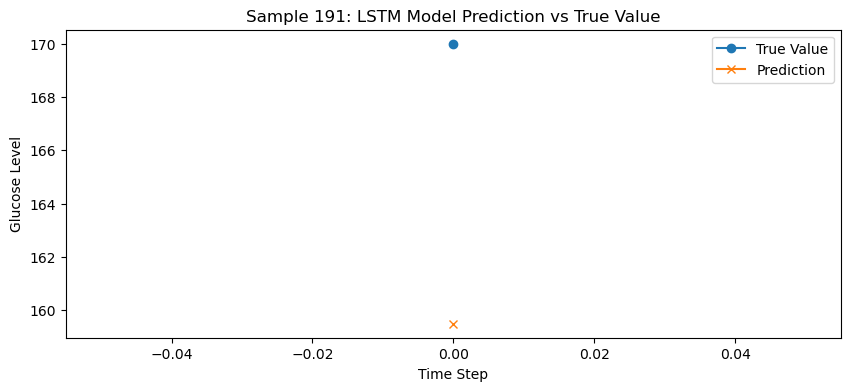

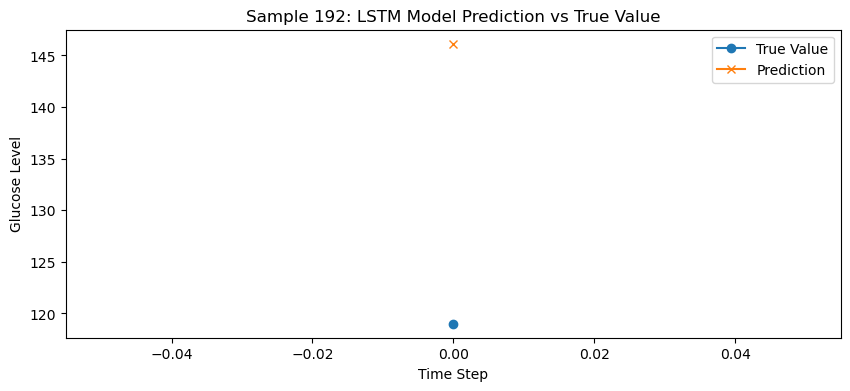

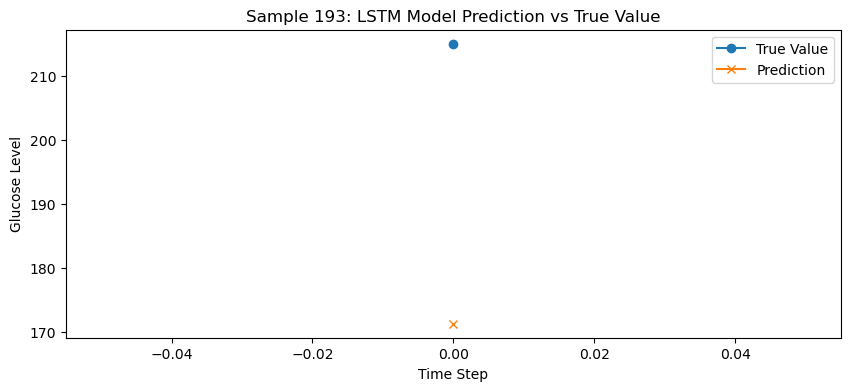

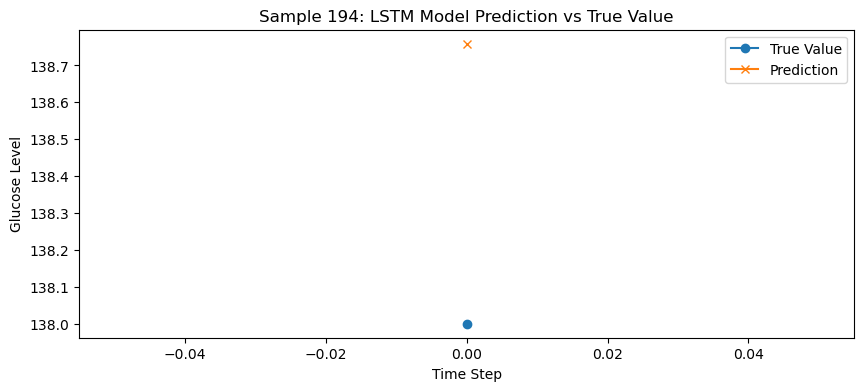

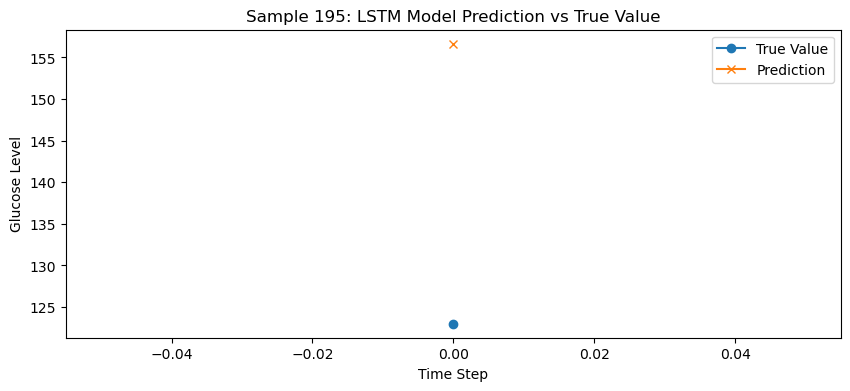

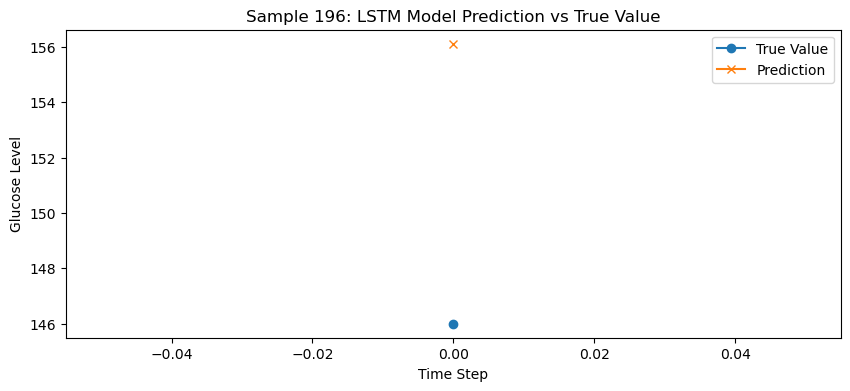

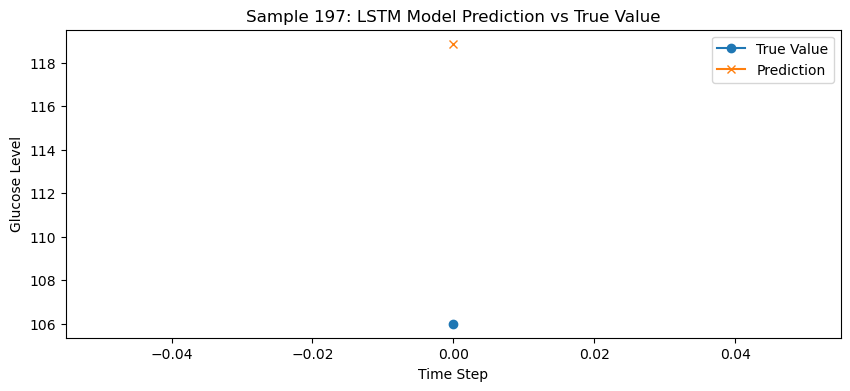

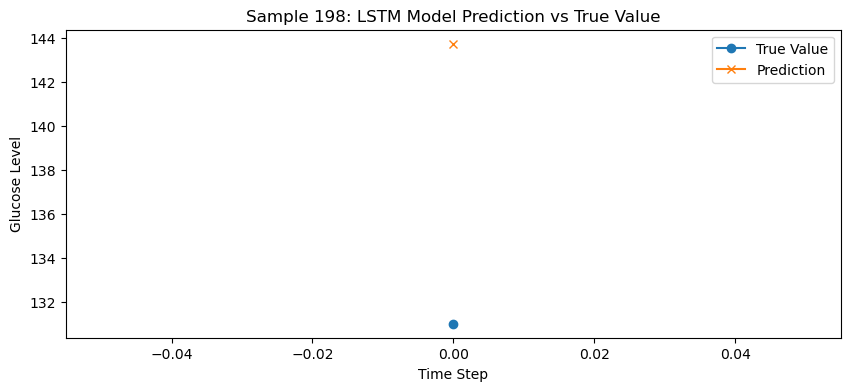

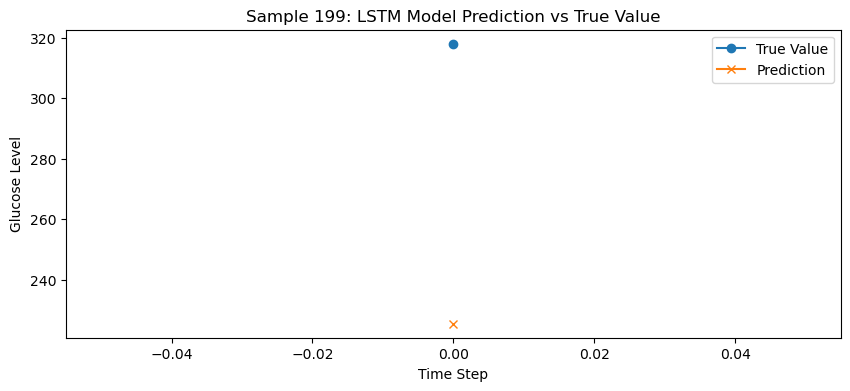

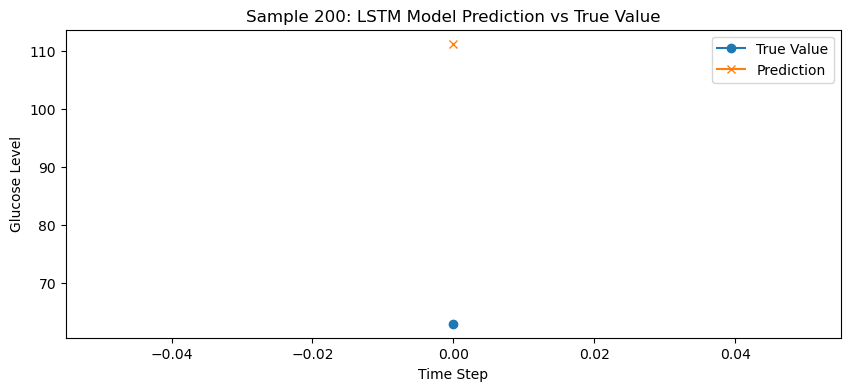

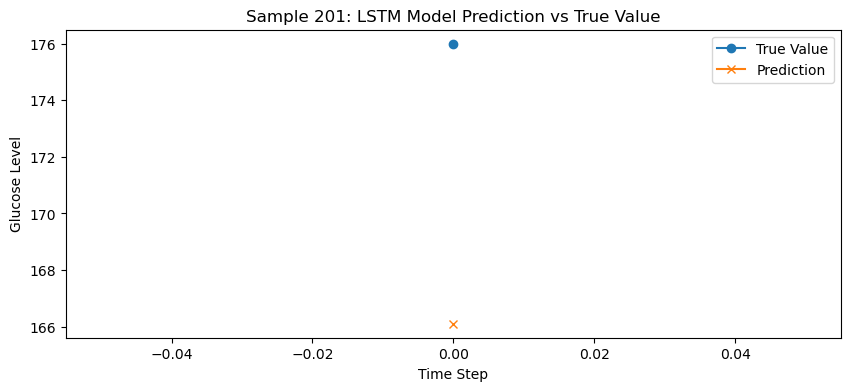

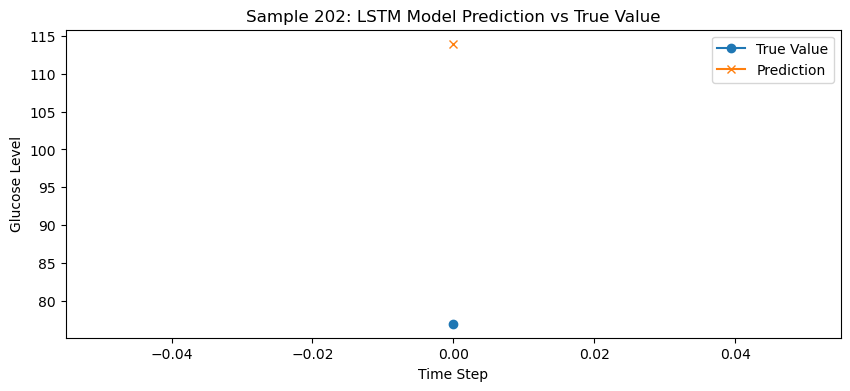

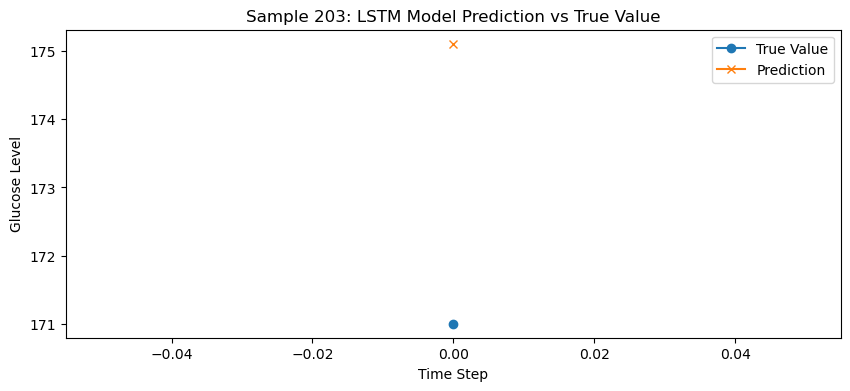

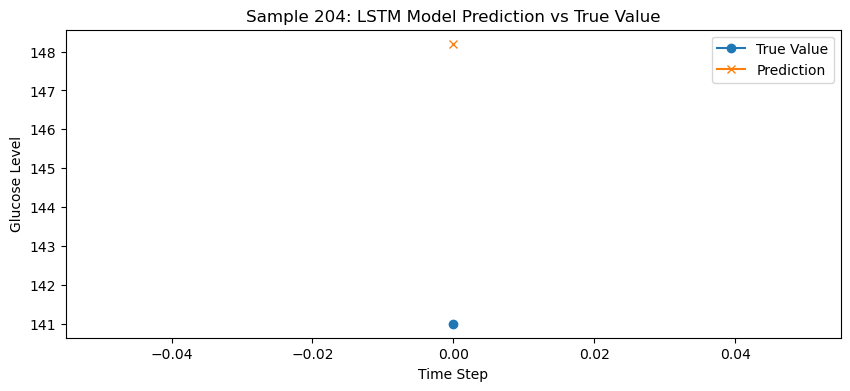

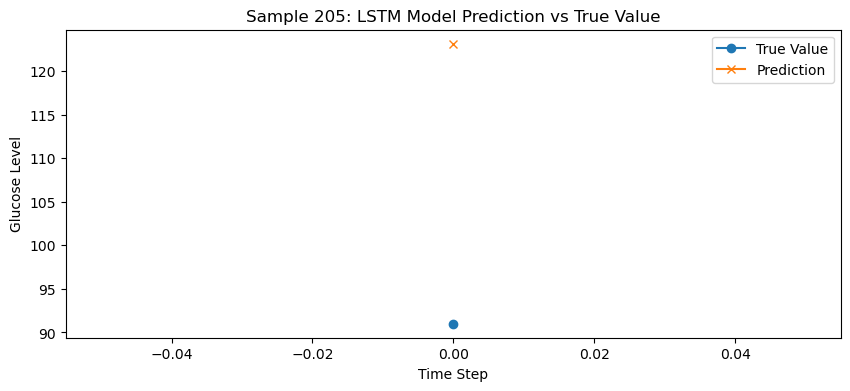

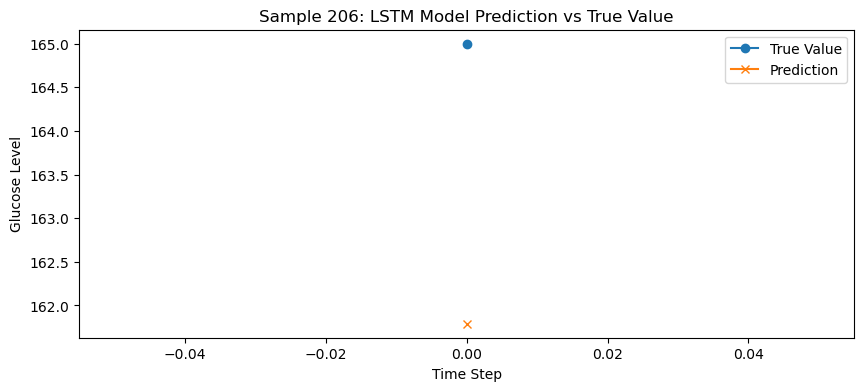

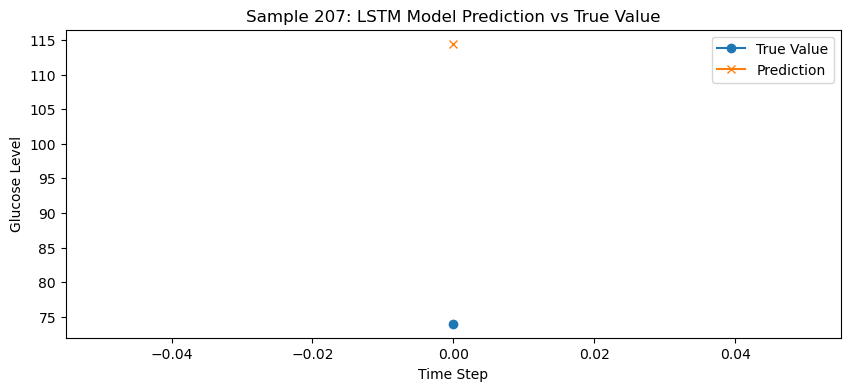

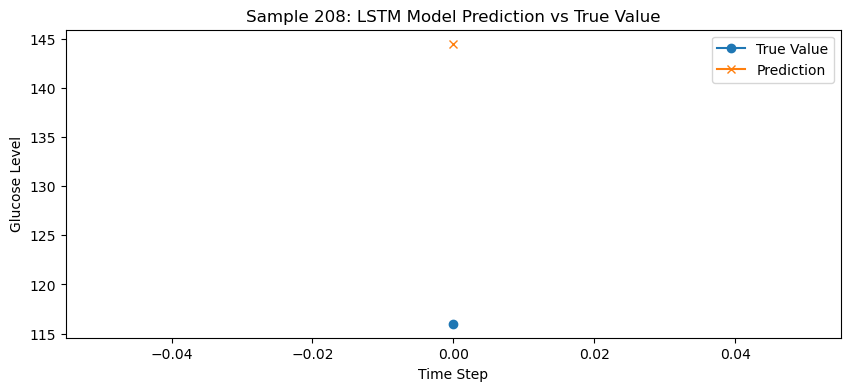

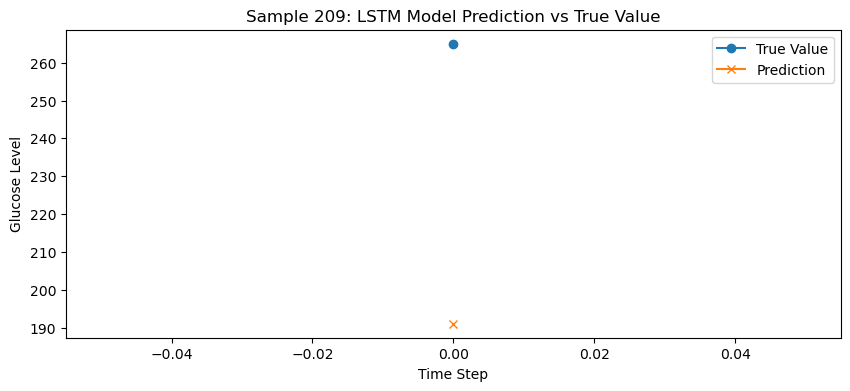

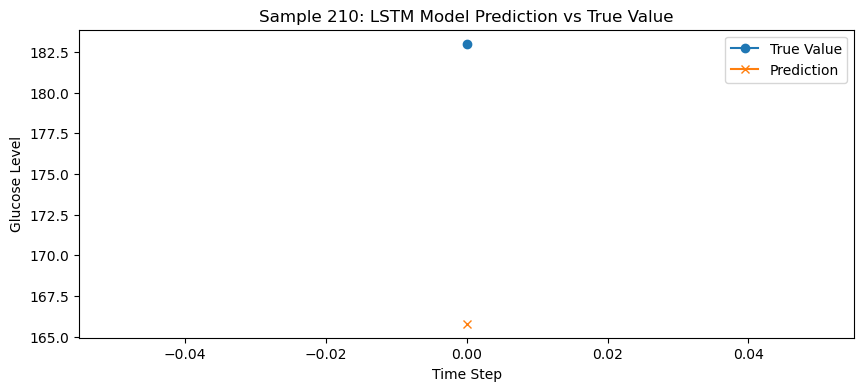

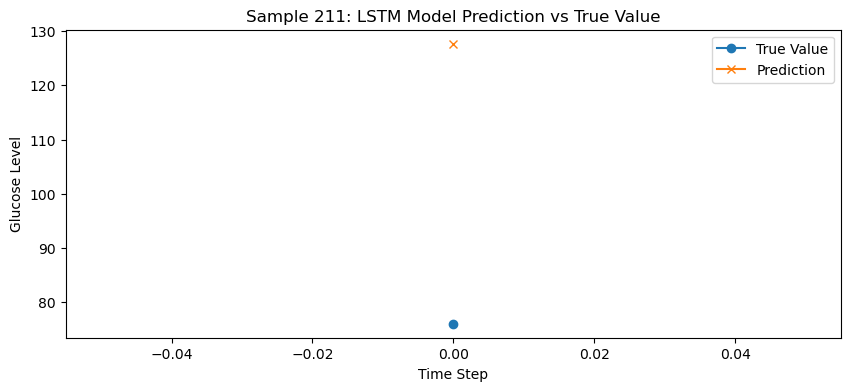

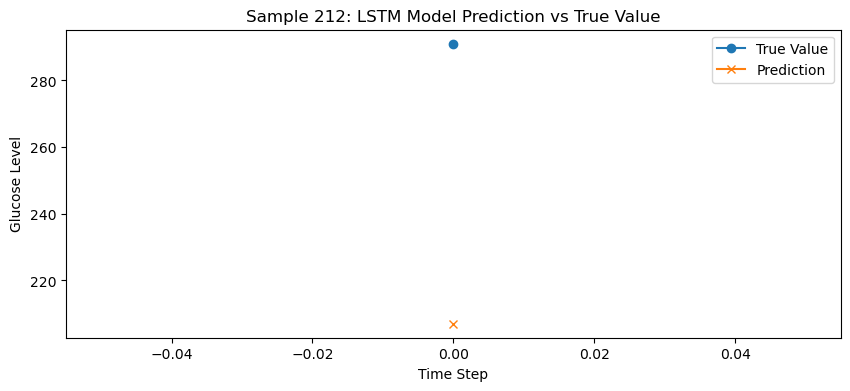

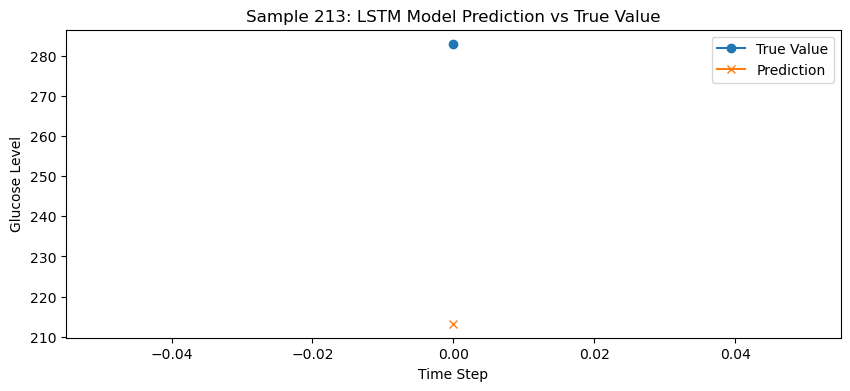

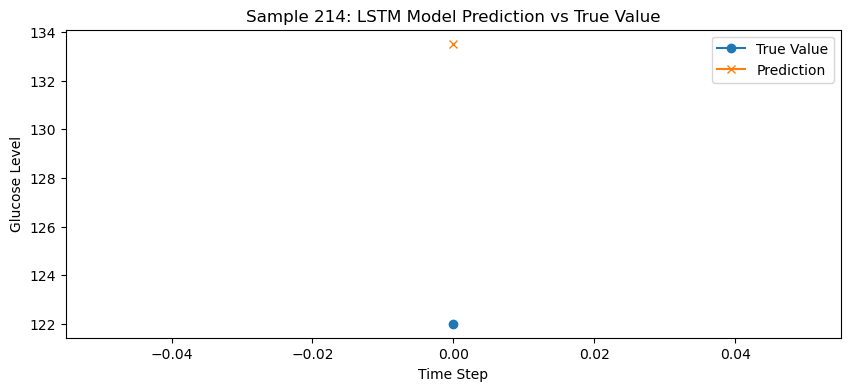

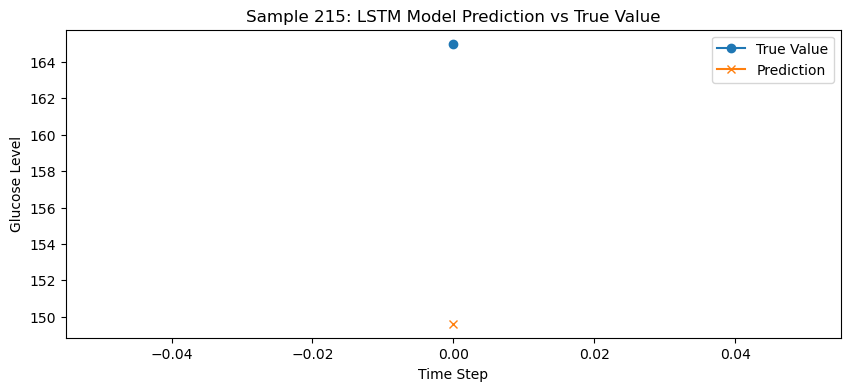

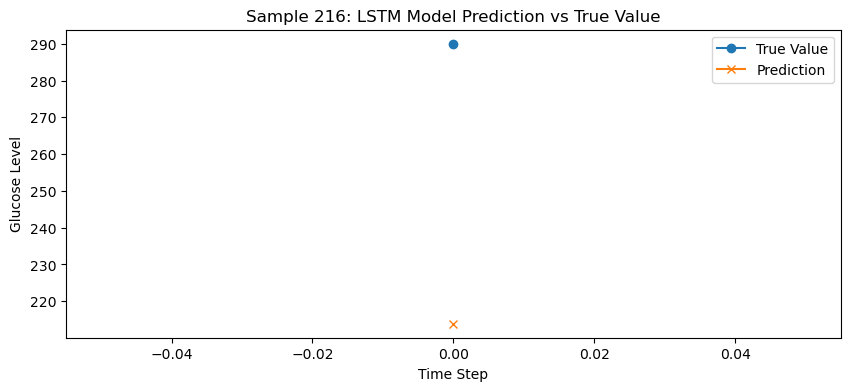

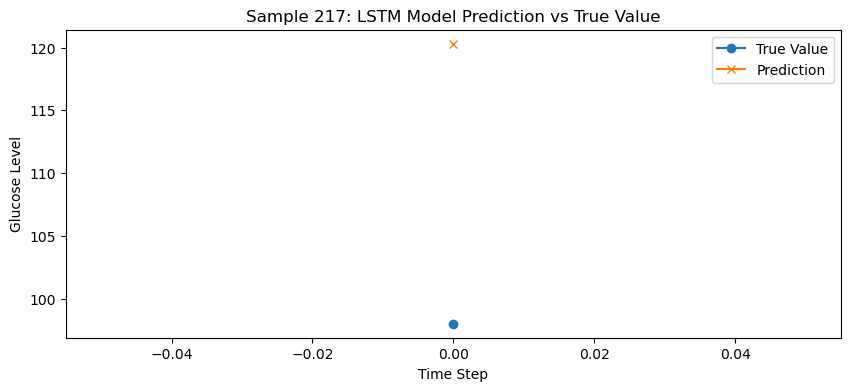

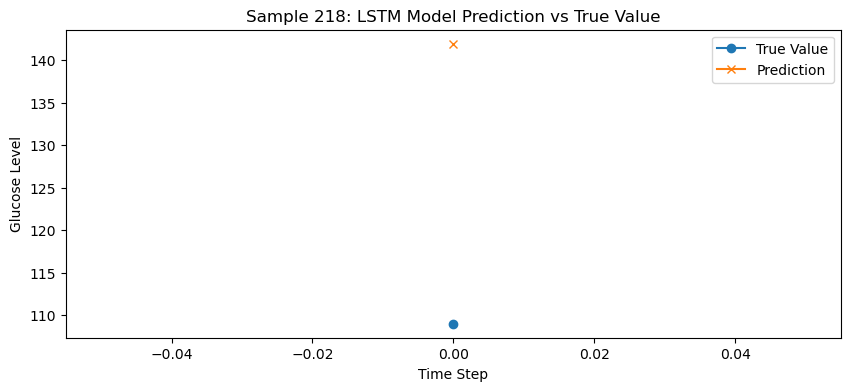

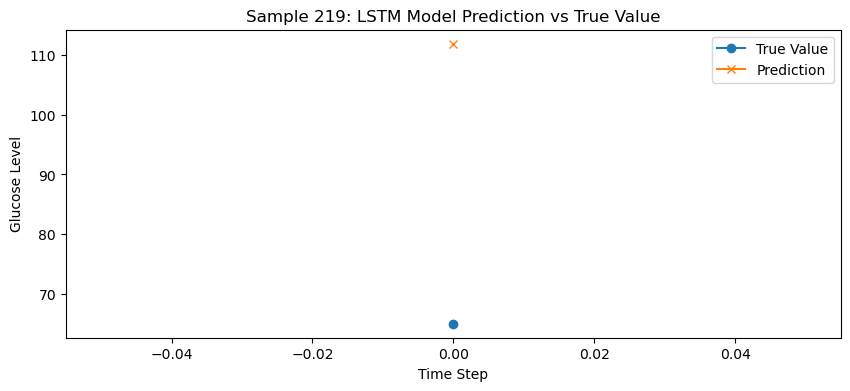

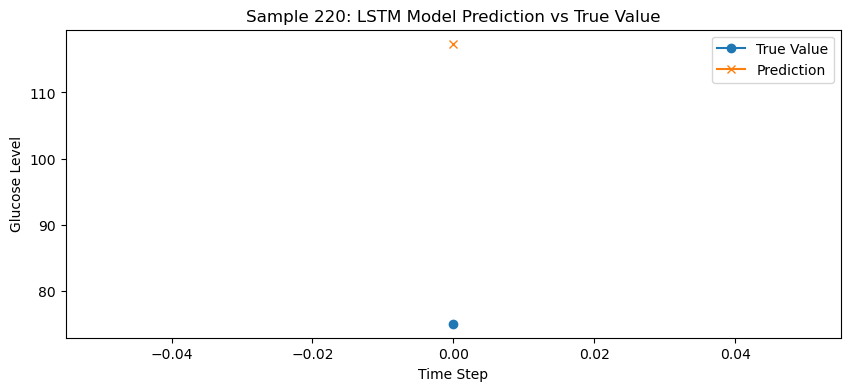

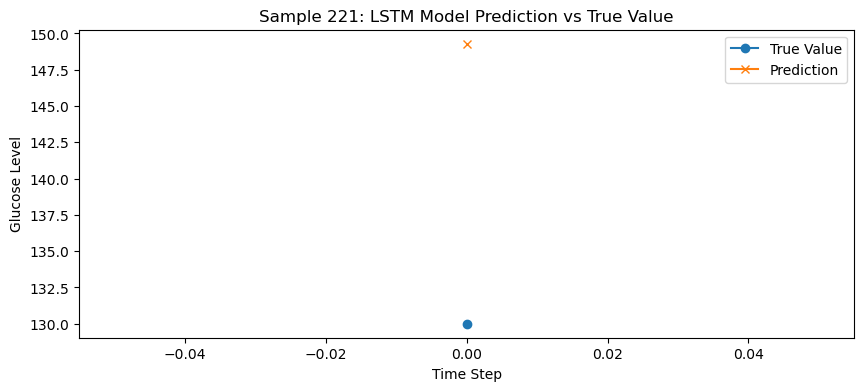

In [3]:
# Plot the predictions vs the true values for each sample
for i in range(len(y_pred)):
    plt.figure(figsize=(10, 4))
    plt.plot(y_true[i], label="True Value", marker='o')
    plt.plot(y_pred[i], label="Prediction", marker='x')
    plt.xlabel("Time Step")
    plt.ylabel("Glucose Level")
    plt.title(f"Sample {i+1}: LSTM Model Prediction vs True Value")
    plt.legend()
    plt.show()